# Investigate results of fitting procedure

In [2]:
import sys
sys.path.append("../python/")
#sys.path.append("../python/cluster/")


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
#import bokeh.palettes
import _corner
import imp
imp.reload(_corner)
from _corner import corner
from scipy.stats import gaussian_kde
import pickle
from matplotlib.offsetbox import AnchoredText
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM
from scipy.interpolate import griddata
import matplotlib.colors as colors
import utils_plots
imp.reload(utils_plots)
#from utils_plots import plot_FSE_grid_f_gamma_ex1, plot_1Dposterior_ex1, plot_FSE_grid_f_gamma_ex2, plot_1Dposterior_ex1_f, plot_1Dposterior_ex1_gamma
from utils import gNFW_rho
import pickle

import imp
import utils_plots
imp.reload(utils_plots)
from utils_plots import grid_FSE, add_hatch

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':22})
#rc('text', usetex=True)

## Exercise 1

- Only consider uncertainty in observed temperature, rest of parameters are estimated with 100% precision
- In gNFW profile, we fix $r_s=20\,\rm kpc$ and $\rho_0=0.42\,\rm GeV/cm^3$
- 2 free parameters of analysis: capture rate $f$ and $\gamma$

### Dependence of results with relative uncertainty 

Plot posterior

0.8452422416044016 1.052955241832966


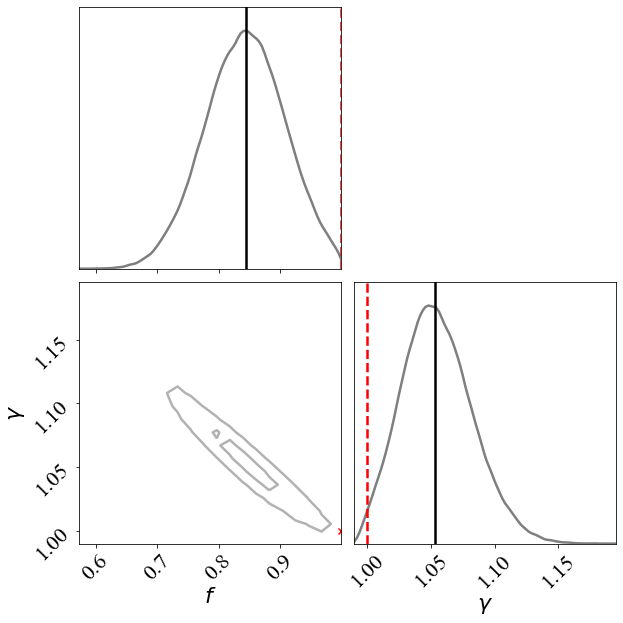

In [18]:
_file   = open("../results/bayesian/likelihood_game0_uncTobs_0.03v97", "rb") 
like    = pickle.load(_file)
_file   = open("../results/bayesian/posterior_game0_uncTobs_0.03v97", "rb") 
samples = pickle.load(_file)

smooth=0.5
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth)

# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 3], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5, alpha=0.5)

ML = samples[np.argmax(like)]
axes[0, 0].axvline(ML[0], ls="-", lw=2.5, color="k")
axes[1, 1].axvline(ML[1], ls="-", lw=2.5, color="k")
axes[0, 0].axvline(1., ls="--", lw=2.5, color="red")
axes[1, 1].axvline(1., ls="--", lw=2.5, color="red")
axes[1, 0].scatter(1., 1., marker="x", color="red")

axes[1, 0].set_ylabel(r"$\gamma$")
axes[1, 0].set_xlabel(r"$f$")
axes[1, 1].set_xlabel(r"$\gamma$")

print(ML[0], ML[1])

In [17]:
def FSE_f_gamma(filepath, f_true, gamma_true, rel_unc_Tobs=[0.01, 0.02, 0.03, 0.05, 0.10, 0.25, 0.50]):
    """
    Return Fractional Standard Error
    """
    mean = {}; median = {}; MAP = {}; ML = {};
    for rel_unc in rel_unc_Tobs:
        data = np.genfromtxt(filepath + ("statistics_game0_uncTobs_%.2f.dat" %rel_unc), unpack=True)
        mean[rel_unc]   = np.array((data[0], data[1]))
        #print(mean[rel_unc].shape, mean[rel_unc][:, 0], mean[rel_unc][0])
        median[rel_unc] = np.array((data[2], data[3]))
        MAP[rel_unc]    = np.array((data[4], data[5]))
        ML[rel_unc]     = np.array((data[6], data[7]))
        
    true          = [f_true, gamma_true]
    rank          = mean[rel_unc].shape[1]
    D             = mean[rel_unc].shape[0] # dimension parameter space
    FSE           = {}
    FSE["mean"]   = []
    FSE["median"] = []
    FSE["MAP"]    = []
    FSE["ML"]     = []
    
    for i in range(D):
        FSE["mean"].append([])
        FSE["median"].append([])
        FSE["MAP"].append([])
        FSE["ML"].append([])
        for rel_unc in rel_unc_Tobs:
            FSE["mean"][i].append(np.sqrt(1/rank*np.sum(np.power(mean[rel_unc][i] - true[i], 2)))/true[i])
            FSE["median"][i].append(np.sqrt(1/rank*np.sum(np.power(median[rel_unc][i] - true[i], 2)))/true[i])
            FSE["MAP"][i].append(np.sqrt(1/rank*np.sum(np.power(MAP[rel_unc][i] - true[i], 2)))/true[i])
            FSE["ML"][i].append(np.sqrt(1/rank*np.sum(np.power(ML[rel_unc][i] - true[i], 2)))/true[i])
    return FSE

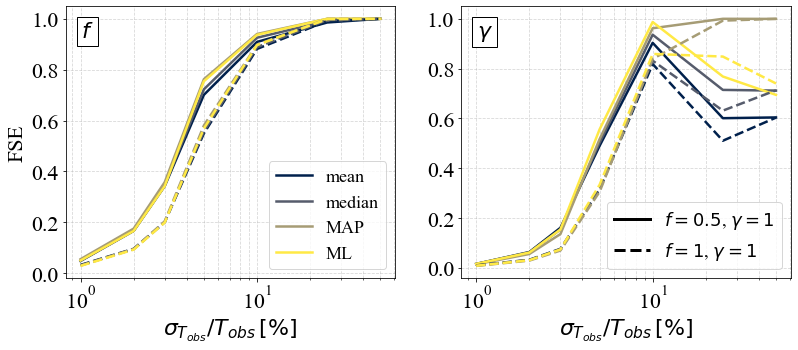

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

filepath     = "../results/bayesian/game0/"
labels       = ["mean", "median", "MAP", "ML"]
rel_unc_Tobs = [0.01, 0.02, 0.03, 0.05, 0.10, 0.25, 0.50]

gamma_true = 1
f_true     = [0.5, 1.]
folder     = ["f05gamma1/", "f1gamma1/"] # CAREFULL!!
ls         = ["-", "--"]
lines      = [Line2D([0], [0], color="k", linewidth=3, linestyle=l) for l in ls]
llabels    = ["$f=0.5$, $\gamma=1$", "$f=1$, $\gamma=1$"] # CAREFULL!!

nPE        = 4 # number point estimates
colors     = bokeh.palettes.cividis(nPE)
j          = -1

for i in range(len(f_true)):
    j += 1
    FSE = FSE_f_gamma(filepath + folder[i], f_true[i], gamma_true)
    for k in range(nPE):
        if j==0:
            ax[0].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][0], label=labels[k], lw=2.5, 
                       color=colors[k], ls=ls[j])
        else:
            ax[0].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][0], lw=2.5, color=colors[k], ls=ls[j])
        ax[1].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][1], lw=2.5, color=colors[k], ls=ls[j])

ax[0].legend(frameon=True, fontsize=18)
ax[1].legend(lines, llabels, frameon=True, fontsize=18)
ax[0].set_ylabel("FSE")
ax[0].set_xlabel(r"$\sigma_{T_{obs}}/T_{obs}\, [\%]$")
ax[1].set_xlabel(r"$\sigma_{T_{obs}}/T_{obs}\, [\%]$")

text_box = AnchoredText(r"$f$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[0].add_artist(text_box)
text_box = AnchoredText(r"$\gamma$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[1].add_artist(text_box)

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[1].grid(which="both", ls="--", alpha=0.5)

fig.savefig("../Figs/game0_FS1_nBDs10000.pdf", bbox_inches="tight")

**Understand why funny shape FSE for $\gamma$**

Text(0.5, 0, '$\\gamma$')

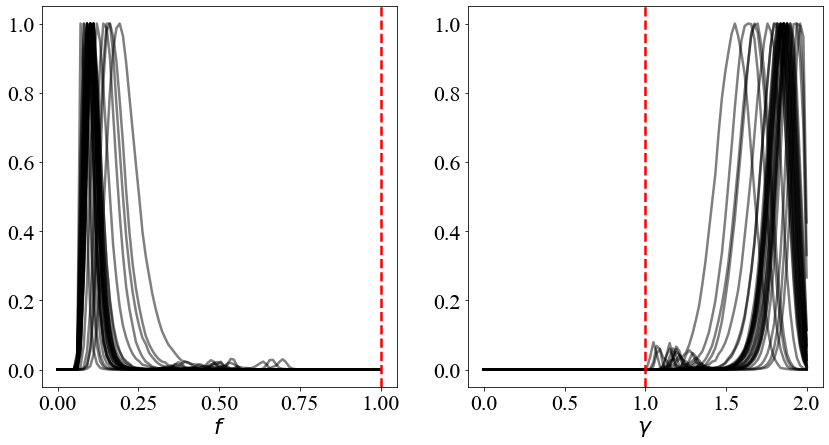

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

xvals0 = np.linspace(0, 1, 100)
xvals1 = np.linspace(0, 2, 100)
    
for i in range(30):
    _file   = open("../results/bayesian/posterior_game0_uncTobs_0.1v" + str(i), "rb") 
    samples = pickle.load(_file)
    kde   = gaussian_kde(samples.T[0])
    ax[0].plot(xvals0, kde(xvals0)/np.max(kde(xvals0)), color="k", lw=2.5, alpha=0.5)
    kde   = gaussian_kde(samples.T[1])
    ax[1].plot(xvals1, kde(xvals1)/np.max(kde(xvals1)), color="k", lw=2.5, alpha=0.5)

ax[0].axvline(1., ls="--", lw=2.5, color="red")
ax[1].axvline(1., ls="--", lw=2.5, color="red")

ax[0].set_xlabel(r"$f$")
ax[1].set_xlabel(r"$\gamma$")

Text(0.5, 0, '$\\gamma$')

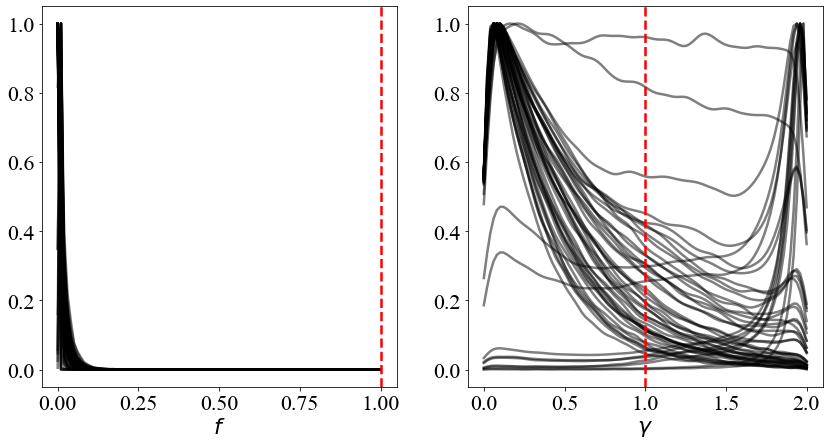

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

xvals0 = np.linspace(0, 1, 100)
xvals1 = np.linspace(0, 2, 100)
    
for i in range(50):
    _file   = open("../results/bayesian/posterior_game0_uncTobs_0.25v" + str(i), "rb") 
    samples = pickle.load(_file)
    kde   = gaussian_kde(samples.T[0])
    ax[0].plot(xvals0, kde(xvals0)/np.max(kde(xvals0)), color="k", lw=2.5, alpha=0.5)
    kde   = gaussian_kde(samples.T[1])
    ax[1].plot(xvals1, kde(xvals1)/np.max(kde(xvals1)), color="k", lw=2.5, alpha=0.5)

ax[0].axvline(1., ls="--", lw=2.5, color="red")
ax[1].axvline(1., ls="--", lw=2.5, color="red")

ax[0].set_xlabel(r"$f$")
ax[1].set_xlabel(r"$\gamma$")

Text(0.5, 0, '$\\gamma$')

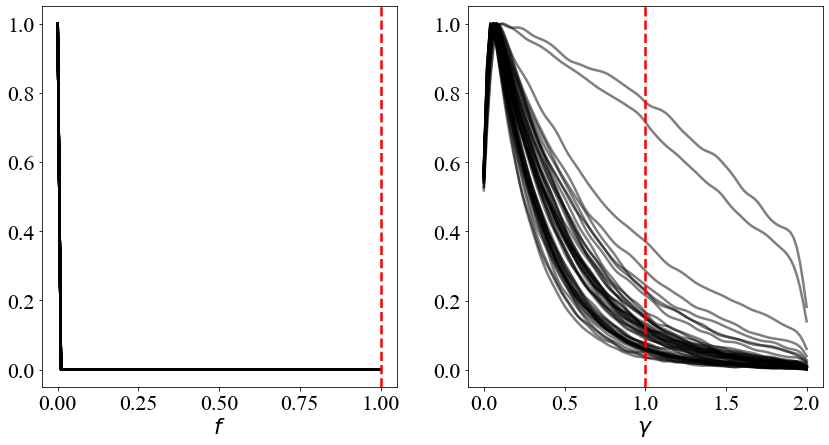

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

xvals0 = np.linspace(0, 1, 100)
xvals1 = np.linspace(0, 2, 100)
    
for i in range(50):
    _file   = open("../results/bayesian/posterior_game0_uncTobs_0.5v" + str(i), "rb") 
    samples = pickle.load(_file)
    kde   = gaussian_kde(samples.T[0])
    ax[0].plot(xvals0, kde(xvals0)/np.max(kde(xvals0)), color="k", lw=2.5, alpha=0.5)
    kde   = gaussian_kde(samples.T[1])
    ax[1].plot(xvals1, kde(xvals1)/np.max(kde(xvals1)), color="k", lw=2.5, alpha=0.5)

ax[0].axvline(1., ls="--", lw=2.5, color="red")
ax[1].axvline(1., ls="--", lw=2.5, color="red")

ax[0].set_xlabel(r"$f$")
ax[1].set_xlabel(r"$\gamma$")

### Dependence of results with observed number of BDs

In [36]:
def FSE_f_gamma(filepath, f_true, gamma_true, nBDs=[1000, 5000, 10000, 20000, 50000, 100000]):
    """
    Return Fractional Standard Error
    """
    mean = {}; median = {}; MAP = {}; ML = {};
    for n in nBDs:
        if n==10000:
            data = np.genfromtxt(filepath + "statistics_game0_uncTobs_0.05.dat", unpack=True)
        else:
            data = np.genfromtxt(filepath + ("statistics_game0_nBDs_%i.dat" %n), unpack=True)
        mean[n]   = np.array((data[0], data[1]))
        median[n] = np.array((data[2], data[3]))
        MAP[n]    = np.array((data[4], data[5]))
        ML[n]     = np.array((data[6], data[7]))
        
    true          = [f_true, gamma_true]
    rank          = mean[n].shape[1]
    D             = mean[n].shape[0] # dimension parameter space
    FSE           = {}
    FSE["mean"]   = []
    FSE["median"] = []
    FSE["MAP"]    = []
    FSE["ML"]     = []
    
    for i in range(D):
        FSE["mean"].append([])
        FSE["median"].append([])
        FSE["MAP"].append([])
        FSE["ML"].append([])
        for n in nBDs:
            FSE["mean"][i].append(np.sqrt(1/rank*np.sum(np.power(mean[n][i] - true[i], 2)))/true[i])
            FSE["median"][i].append(np.sqrt(1/rank*np.sum(np.power(median[n][i] - true[i], 2)))/true[i])
            FSE["MAP"][i].append(np.sqrt(1/rank*np.sum(np.power(MAP[n][i] - true[i], 2)))/true[i])
            FSE["ML"][i].append(np.sqrt(1/rank*np.sum(np.power(ML[n][i] - true[i], 2)))/true[i])
    return FSE

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

filepath     = "../results/bayesian/game0/"
labels       = ["mean", "median", "MAP", "ML"]
rel_unc_Tobs = [0.01, 0.02, 0.03, 0.05, 0.10, 0.25, 0.50]

gamma_true = 1
f_true     = [0.5, 1.]
folder     = ["f05gamma1/", "f1gamma1/"] # CAREFULL!!
ls         = ["-", "--"]
lines      = [Line2D([0], [0], color="k", linewidth=3, linestyle=l) for l in ls]
llabels    = ["$f=0.5$, $\gamma=1$", "$f=1$, $\gamma=1$"] # CAREFULL!!

nPE        = 4 # number point estimates
colors     = bokeh.palettes.cividis(nPE)
j          = -1

for i in range(len(f_true)):
    j += 1
    FSE = FSE_f_gamma(filepath + folder[i], f_true[i], gamma_true)
    for k in range(nPE):
        if j==0:
            ax[0].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][0], label=labels[k], lw=2.5, 
                       color=colors[k], ls=ls[j])
        else:
            ax[0].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][0], lw=2.5, color=colors[k], ls=ls[j])
        ax[1].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][1], lw=2.5, color=colors[k], ls=ls[j])

ax[0].legend(frameon=True, fontsize=18)
ax[1].legend(lines, llabels, frameon=True, fontsize=18)
ax[0].set_ylabel("FSE")
ax[0].set_xlabel(r"$\sigma_{T_{obs}}/T_{obs}\, [\%]$")
ax[1].set_xlabel(r"$\sigma_{T_{obs}}/T_{obs}\, [\%]$")

text_box = AnchoredText(r"$f$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[0].add_artist(text_box)
text_box = AnchoredText(r"$\gamma$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[1].add_artist(text_box)

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[1].grid(which="both", ls="--", alpha=0.5)

fig.savefig("../Figs/game0_FS1_nBDs10000.pdf", bbox_inches="tight")

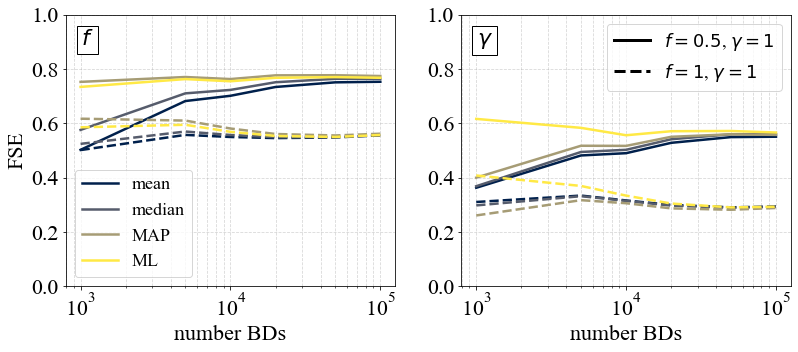

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

filepath     = "../results/bayesian/game0/"
labels       = ["mean", "median", "MAP", "ML"]
nBDs         = [1000, 5000, 10000, 20000, 50000, 100000]

gamma_true = 1
f_true     = [0.5, 1.]
folder     = ["f05gamma1/", "f1gamma1/"] # CAREFULL!!
ls         = ["-", "--"]
lines      = [Line2D([0], [0], color="k", linewidth=3, linestyle=l) for l in ls]
llabels    = ["$f=0.5$, $\gamma=1$", "$f=1$, $\gamma=1$"] # CAREFULL!!

nPE        = 4 # number point estimates
colors     = bokeh.palettes.cividis(nPE)
j          = -1

for i in range(len(f_true)):
    j += 1
    FSE = FSE_f_gamma(filepath + folder[i], f_true[i], gamma_true)
    for k in range(nPE):
        if j==0:
            ax[0].plot(nBDs, FSE[labels[k]][0], label=labels[k], lw=2.5, color=colors[k], ls=ls[j])
        else:
            ax[0].plot(nBDs, FSE[labels[k]][0], lw=2.5, color=colors[k], ls=ls[j])
        ax[1].plot(nBDs, FSE[labels[k]][1], lw=2.5, color=colors[k], ls=ls[j])

ax[0].legend(frameon=True, fontsize=18)
ax[1].legend(lines, llabels, frameon=True, fontsize=18)
ax[0].set_ylabel("FSE")
ax[0].set_xlabel("number BDs")
ax[1].set_xlabel("number BDs")

text_box = AnchoredText(r"$f$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[0].add_artist(text_box)
text_box = AnchoredText(r"$\gamma$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[1].add_artist(text_box)

ax[0].set_ylim([0, 1])
ax[1].set_ylim([0, 1])

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[1].grid(which="both", ls="--", alpha=0.5)

fig.savefig("../Figs/game0_FS1_uncTobs0.05.pdf", bbox_inches="tight")

## DM density profile

In [8]:
def einasto_rho(R0, r, parameters):
    alpha = parameters[0]
    Rs    = parameters[1]
    rho0  = parameters[2]
    # return
    return rho0*np.exp(-(2./alpha)*(np.power(r/Rs, alpha)-np.power(R0/Rs, alpha)))

def burkert_rho(R0, r, parameters):
    Rc   = parameters[0]
    rho0 = parameters[1]
    return rho0*(R0+Rc)*(R0**2 + Rc**2)/(r+Rc)/(r*r + Rc**2)

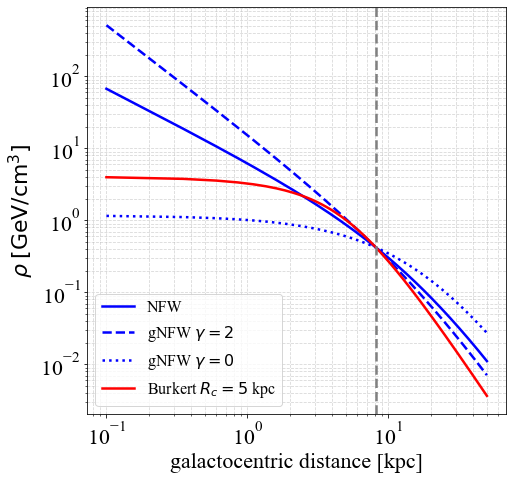

In [3]:
r  = np.linspace(0.1, 50, 200)
R0 = 8.178

rho1 = gNFW_rho(R0, r, [1., 20., 0.42])
rho2 = gNFW_rho(R0, r, [1.5, 20., 0.42])
rho3 = gNFW_rho(R0, r, [0., 20., 0.42])

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.plot(r, rho1, color="blue", lw=2.5, label="NFW")
ax.plot(r, rho2, color="blue", lw=2.5, ls="--", label=r"gNFW $\gamma=2$")
ax.plot(r, rho3, color="blue", lw=2.5, ls=":", label=r"gNFW $\gamma=0$")

ax.plot(r, burkert_rho(R0, r, [5., 0.42]), color="red", lw=2.5, label=r"Burkert $R_c=5.$ kpc")
#ax.plot(r, burkert_rho(R0, r, [10., 0.42]), color="red", lw=2.5, ls=":", label=r"Burkert $R_c=10$ kpc")

#ax.plot(r, einasto_rho(R0, r, [1., 20., 0.42]), color="green", lw=2.5, label=r"Einasto")

ax.axvline(R0, ls="--", color="grey", lw=2.5)

ax.grid(which="both", ls="--", alpha=0.5)
ax.set_ylabel(r"$\rho$ $\rm [GeV/cm^3]$")
ax.set_xlabel("galactocentric distance [kpc]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(fontsize=16)

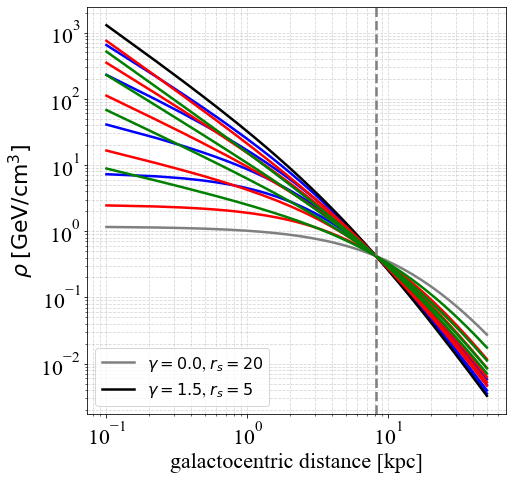

In [16]:
r  = np.linspace(0.1, 50, 400)
R0 = 8.178

gamma = [0., 0.5, 1., 1.3, 1.5]
rs    = [5., 10., 20.]

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
color=["blue", "red", "green"]
for g in gamma:
    i = 0
    for s in rs:
        if g==0. and s==20.:
            ax.plot(r, gNFW_rho(R0, r, [g, s, 0.42]), lw=2.5, color="grey", ls="-",
                label=(r"$\gamma=%.1f$, $r_s=%i$" %(g, int(s))))
        elif g==1.5 and s==5.:
            ax.plot(r, gNFW_rho(R0, r, [g, s, 0.42]), lw=2.5, color="k", ls="-",
                label=(r"$\gamma=%.1f$, $r_s=%i$" %(g, int(s))))
        else:
            ax.plot(r, gNFW_rho(R0, r, [g, s, 0.42]), lw=2.5, color=color[i], ls="-")
        i+=1
ax.axvline(R0, ls="--", color="grey", lw=2.5)

ax.grid(which="both", ls="--", alpha=0.5)
ax.set_ylabel(r"$\rho$ $\rm [GeV/cm^3]$")
ax.set_xlabel("galactocentric distance [kpc]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(fontsize=16)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


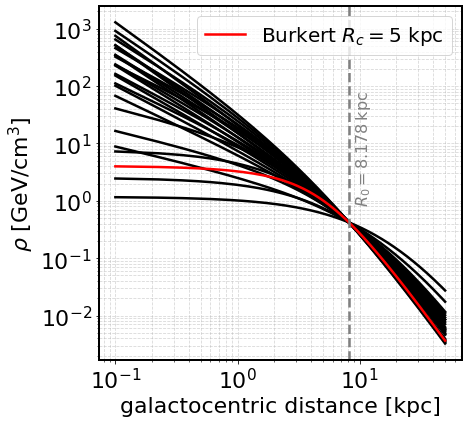

In [9]:
r  = np.linspace(0.1, 50, 400)
R0 = 8.178

gamma = [0., 0.5, 1., 1.1, 1.2, 1.3, 1.4, 1.5]
rs    = [5., 10., 20.]

fig, ax = plt.subplots(1, 1, figsize=(6.5, 6.5))
for g in gamma:
    for s in rs:
        ax.plot(r, gNFW_rho(R0, r, [g, s, 0.42]), lw=2.5, color="k", ls="-")
ax.plot(r, burkert_rho(R0, r, [5., 0.42]), color="red", lw=2.5, label=r"Burkert $R_c=5.$ kpc")
ax.axvline(R0, ls="--", color="grey", lw=2.5)
ax.text(9., 1, r"$R_0=8.178\,\rm kpc$", rotation=90, color="grey", fontsize=16)

ax.grid(which="both", ls="--", alpha=0.5)
ax.set_ylabel(r"$\rho$ $\rm [GeV/cm^3]$", fontsize=22)
ax.set_xlabel("galactocentric distance [kpc]", fontsize=22)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(fontsize=20)

for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.)
        
fig.savefig("../../results/Figs/rhoDM.pdf", bbox_inches="tight")

# Final Run

- Remember the problem with $\gamma=0$ in the FSE definition!

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


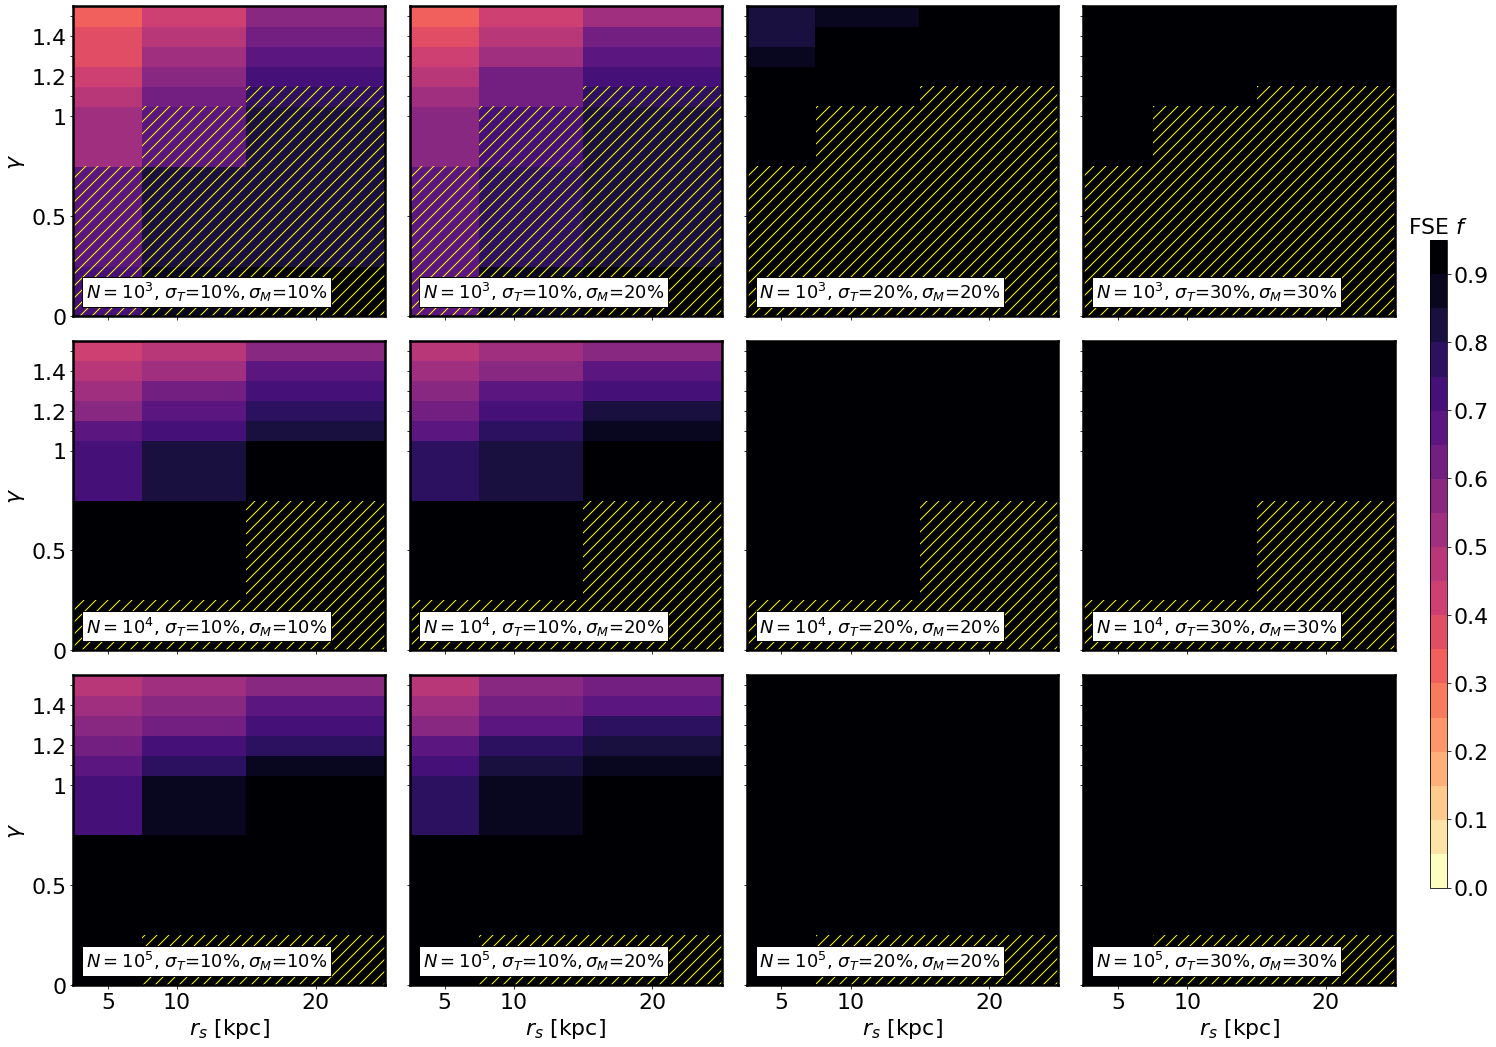

In [22]:
fig, ax = plt.subplots(3, 4, figsize=(24, 18))

path = "/home/mariacst/exoplanets/results/"
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex3", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex3", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex3", ax[0, 2], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex3", ax[0, 3], "median", True, False, False, False)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 0], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 0], 15, 1.05, 10, 0.1)
add_hatch(ax[0, 1], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 1], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 1], 15, 1.05, 10, 0.1)
add_hatch(ax[0, 2], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 2], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 2], 15, 1.05, 10, 0.1)
add_hatch(ax[0, 3], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 3], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 3], 15, 1.05, 10, 0.1)

im   = grid_FSE(path, 10000, 0.1, 0.1, "ex3", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE(path, 10000, 0.1, 0.2, "ex3", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE(path, 10000, 0.2, 0.2, "ex3", ax[1, 2], "median", True, False, False, False)
im   = grid_FSE(path, 10000, 0.3, 0.3, "ex3", ax[1, 3], "median", True, False, False, False)

add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 15, 0.25, 10, 0.5);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 15, 0.25, 10., 0.5)
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 15, 0.25, 10., 0.5)
add_hatch(ax[1, 3], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 3], 15, 0.25, 10., 0.5)

im   = grid_FSE(path, 100000, 0.1, 0.1, "ex3", ax[2, 0], "median", True, False, True, True)
im   = grid_FSE(path, 100000, 0.1, 0.2, "ex3", ax[2, 1], "median", True, False, False, True)
im   = grid_FSE(path, 100000, 0.2, 0.2, "ex3", ax[2, 2], "median", True, False, False, True)
im   = grid_FSE(path, 100000, 0.3, 0.3, "ex3", ax[2, 3], "median", True, False, False, True)

add_hatch(ax[2, 0], 7.5, 0, 17.5, 0.25); add_hatch(ax[2, 1], 7.5, 0, 17.5, 0.25);
add_hatch(ax[2, 2], 7.5, 0, 17.5, 0.25); add_hatch(ax[2, 3], 7.5, 0, 17.5, 0.25);

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("FSE $f$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("/home/mariacst/exoplanets/Figs/FSE_f_all.pdf", bbox_inches="tight")

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


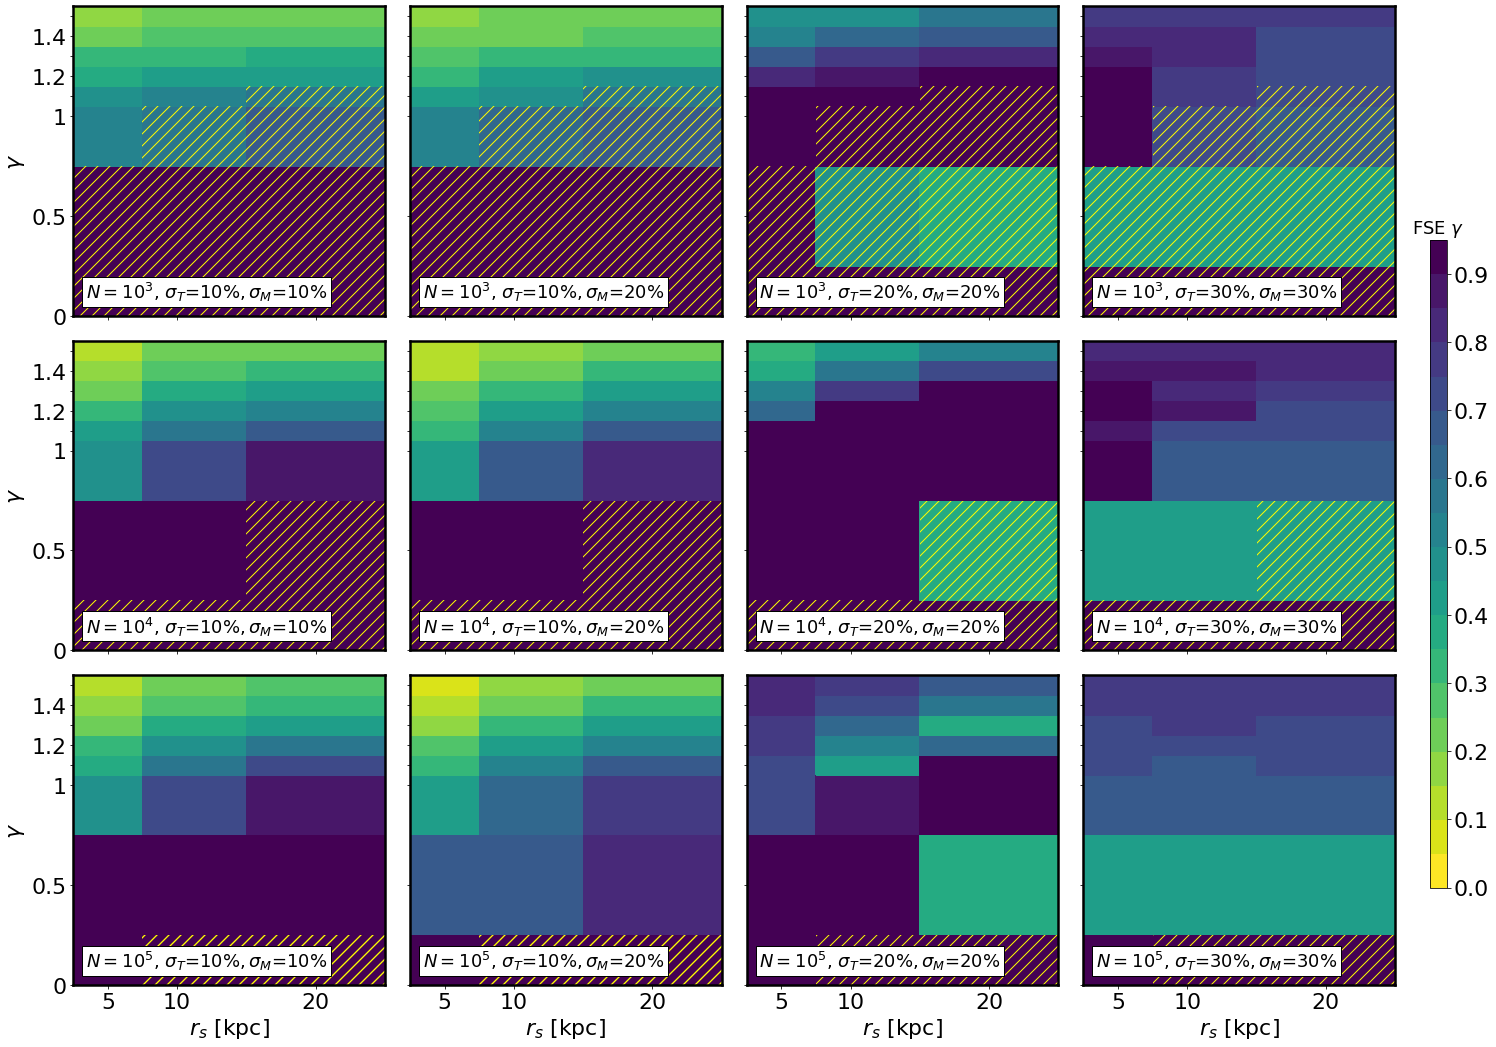

In [21]:
fig, ax = plt.subplots(3, 4, figsize=(24, 18))

path = "/home/mariacst/exoplanets/results/"
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex3", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex3", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex3", ax[0, 2], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex3", ax[0, 3], "median", False, True, False, False)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 0], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 0], 15, 1.05, 10, 0.1)
add_hatch(ax[0, 1], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 1], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 1], 15, 1.05, 10, 0.1)
add_hatch(ax[0, 2], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 2], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 2], 15, 1.05, 10, 0.1)
add_hatch(ax[0, 3], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 3], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 3], 15, 1.05, 10, 0.1)

im   = grid_FSE(path, 10000, 0.1, 0.1, "ex3", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE(path, 10000, 0.1, 0.2, "ex3", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE(path, 10000, 0.2, 0.2, "ex3", ax[1, 2], "median", False, True, False, False)
im   = grid_FSE(path, 10000, 0.3, 0.3, "ex3", ax[1, 3], "median", False, True, False, False)

add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 15, 0.25, 10, 0.5);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 15, 0.25, 10., 0.5)
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 15, 0.25, 10., 0.5)
add_hatch(ax[1, 3], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 3], 15, 0.25, 10., 0.5)

im   = grid_FSE(path, 100000, 0.1, 0.1, "ex3", ax[2, 0], "median", False, True, True, True)
im   = grid_FSE(path, 100000, 0.1, 0.2, "ex3", ax[2, 1], "median", False, True, False, True)
im   = grid_FSE(path, 100000, 0.2, 0.2, "ex3", ax[2, 2], "median", False, True, False, True)
im   = grid_FSE(path, 100000, 0.3, 0.3, "ex3", ax[2, 3], "median", False, True, False, True)

add_hatch(ax[2, 0], 7.5, 0, 17.5, 0.25); add_hatch(ax[2, 1], 7.5, 0, 17.5, 0.25);
add_hatch(ax[2, 0], 7.5, 0, 17.5, 0.25); add_hatch(ax[2, 1], 7.5, 0, 17.5, 0.25);
add_hatch(ax[2, 2], 7.5, 0, 17.5, 0.25); add_hatch(ax[2, 3], 7.5, 0, 17.5, 0.25);

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("/home/mariacst/exoplanets/Figs/FSE_gamma_all.pdf", bbox_inches="tight")

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


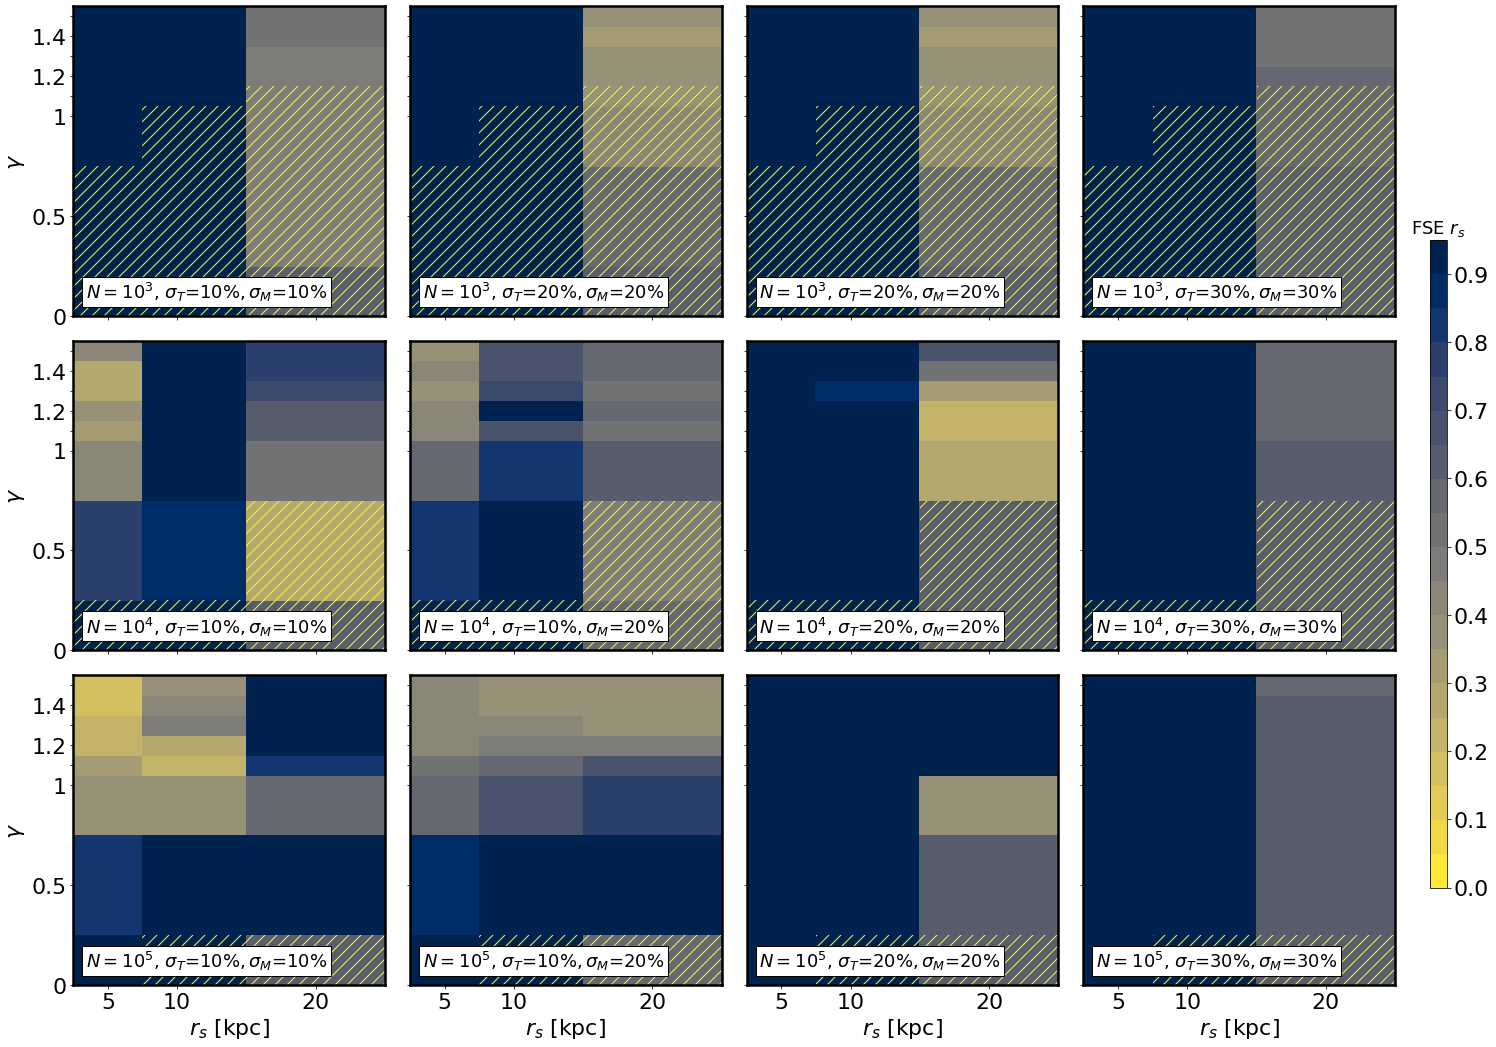

In [20]:
fig, ax = plt.subplots(3, 4, figsize=(24, 18))

path = "/home/mariacst/exoplanets/results/"
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex3", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex3", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex3", ax[0, 2], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex3", ax[0, 3], "median", False, False, False, False)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 0], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 0], 15, 1.05, 10, 0.1)
add_hatch(ax[0, 1], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 1], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 1], 15, 1.05, 10, 0.1)
add_hatch(ax[0, 2], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 2], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 2], 15, 1.05, 10, 0.1)
add_hatch(ax[0, 3], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 3], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 3], 15, 1.05, 10, 0.1)

im   = grid_FSE(path, 10000, 0.1, 0.1, "ex3", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE(path, 10000, 0.1, 0.2, "ex3", ax[1, 1], "median", False, False, False, False)
im   = grid_FSE(path, 10000, 0.2, 0.2, "ex3", ax[1, 2], "median", False, False, False, False)
im   = grid_FSE(path, 10000, 0.3, 0.3, "ex3", ax[1, 3], "median", False, False, False, False)

add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 15, 0.25, 10, 0.5);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 15, 0.25, 10., 0.5)
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 15, 0.25, 10., 0.5)
add_hatch(ax[1, 3], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 3], 15, 0.25, 10., 0.5)

im   = grid_FSE(path, 100000, 0.1, 0.1, "ex3", ax[2, 0], "median", False, False, True, True)
im   = grid_FSE(path, 100000, 0.1, 0.2, "ex3", ax[2, 1], "median", False, False, False, True)
im   = grid_FSE(path, 100000, 0.2, 0.2, "ex3", ax[2, 2], "median", False, False, False, True)
im   = grid_FSE(path, 100000, 0.3, 0.3, "ex3", ax[2, 3], "median", False, False, False, True)

add_hatch(ax[2, 0], 7.5, 0, 17.5, 0.25); add_hatch(ax[2, 1], 7.5, 0, 17.5, 0.25);
add_hatch(ax[2, 2], 7.5, 0, 17.5, 0.25); add_hatch(ax[2, 3], 7.5, 0, 17.5, 0.25);

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("/home/mariacst/exoplanets/Figs/FSE_rs_all.pdf", bbox_inches="tight")

## Galactic center

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


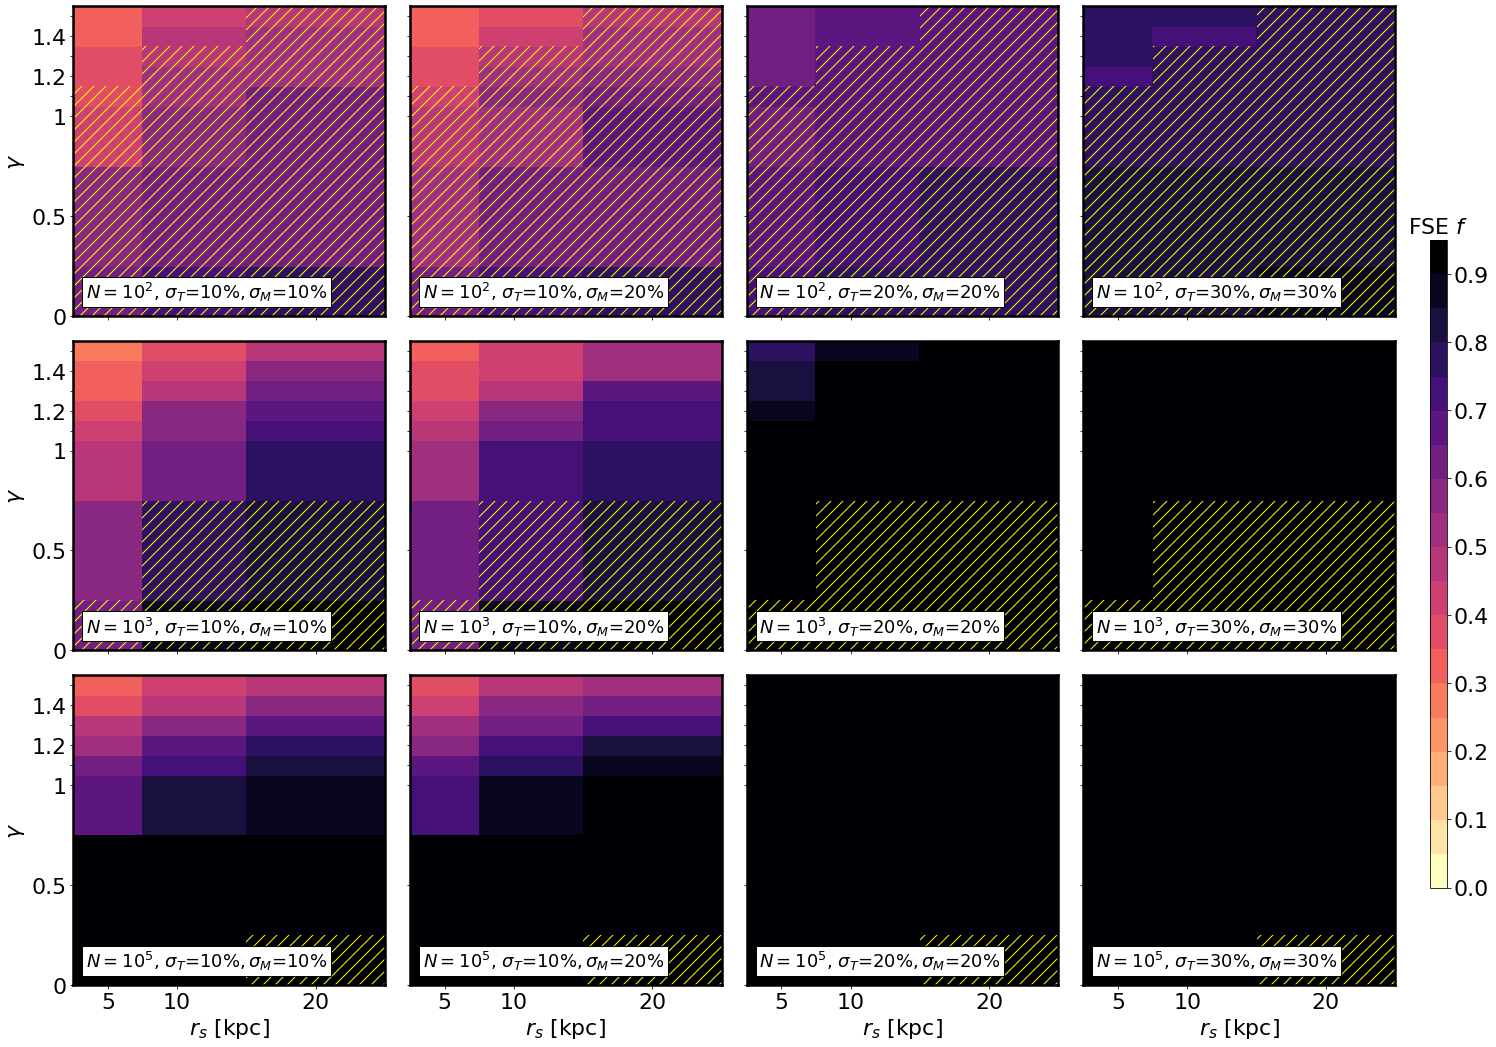

In [17]:
fig, ax = plt.subplots(3, 4, figsize=(24, 18))

path = "/home/mariacst/exoplanets/results/"

im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex4", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex4", ax[0, 2], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex4", ax[0, 3], "median", True, False, False, False)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 0], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 0], 15, 1.35, 10, 0.20);
add_hatch(ax[0, 1], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 1], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 1], 15, 1.35, 10, 0.20);
add_hatch(ax[0, 2], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 2], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 2], 15, 1.35, 10, 0.20);
add_hatch(ax[0, 3], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 3], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 3], 15, 1.35, 10, 0.20);


im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex4", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex4", ax[1, 2], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex4", ax[1, 3], "median", True, False, False, False)

add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 3], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 3], 7.5, 0.25, 17.5, 0.5);

im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 0], "median", True, False, True, True)
im   = grid_FSE(path, 100000, 0.1, 0.2, "ex4", ax[2, 1], "median", True, False, False, True)
im   = grid_FSE(path, 100000, 0.2, 0.2, "ex4", ax[2, 2], "median", True, False, False, True)
im   = grid_FSE(path, 100000, 0.3, 0.3, "ex4", ax[2, 3], "median", True, False, False, True)

add_hatch(ax[2, 0], 15, 0, 10, 0.25); add_hatch(ax[2, 1], 15, 0, 10, 0.25);
add_hatch(ax[2, 2], 15, 0, 10, 0.25); add_hatch(ax[2, 3], 15, 0, 10, 0.25);

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("FSE $f$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("/home/mariacst/exoplanets/Figs/FSE_f_GC.pdf", bbox_inches="tight")

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


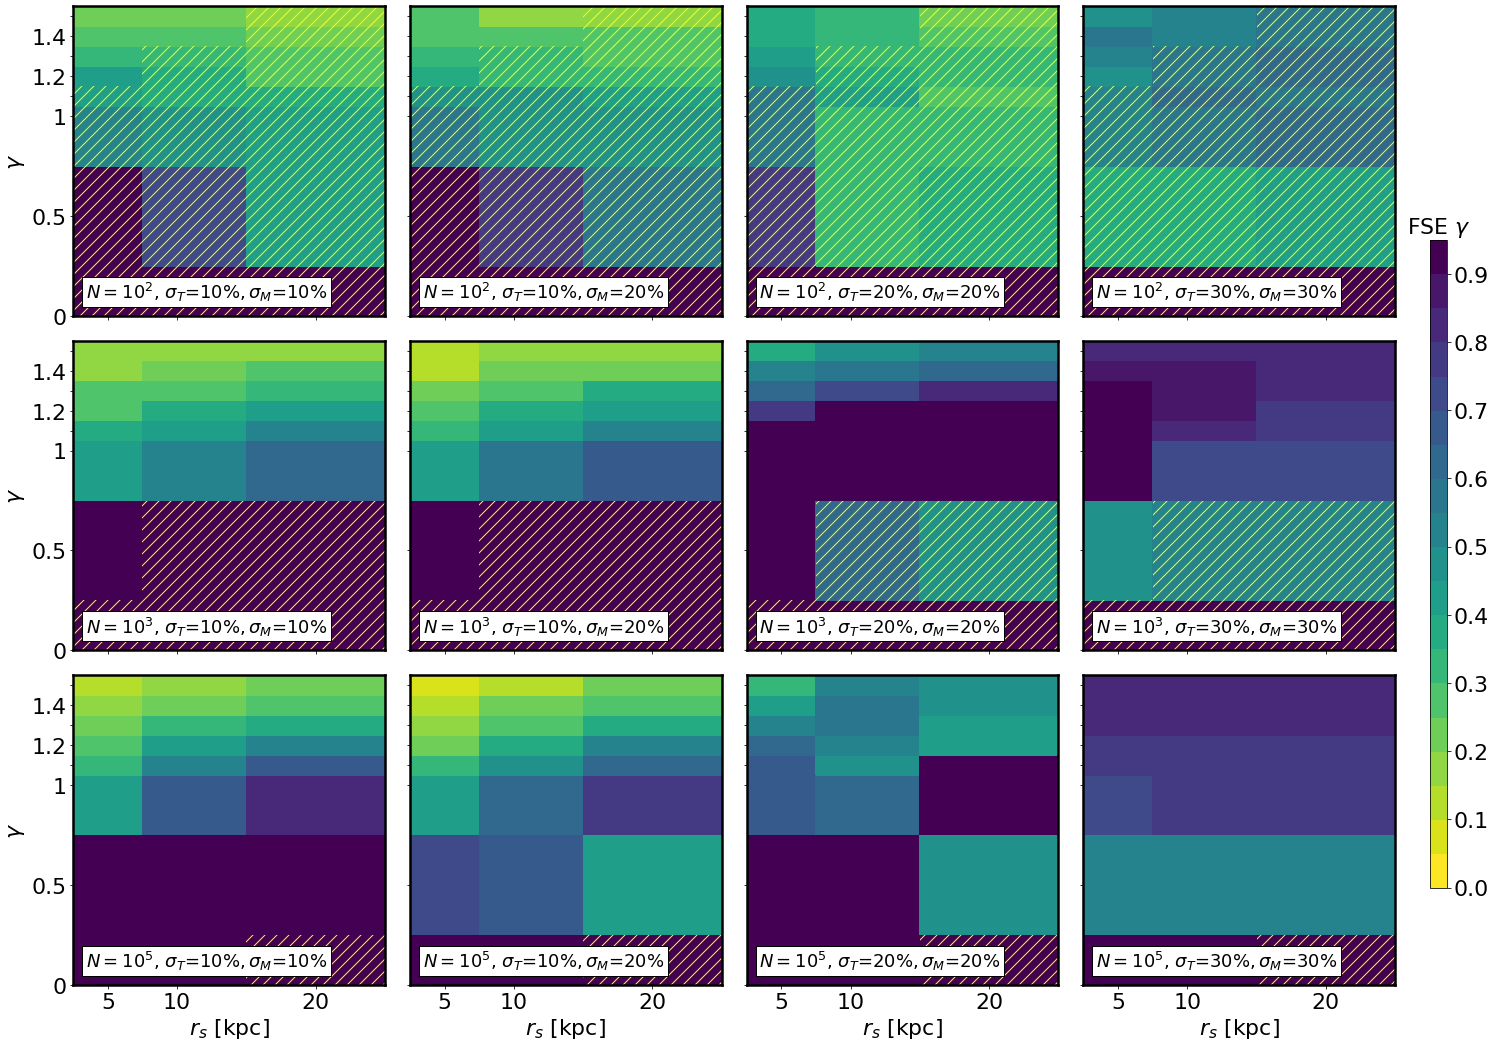

In [18]:
fig, ax = plt.subplots(3, 4, figsize=(24, 18))

path = "/home/mariacst/exoplanets/results/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex4", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex4", ax[0, 2], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex4", ax[0, 3], "median", False, True, False, False)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 0], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 0], 15, 1.35, 10, 0.20);
add_hatch(ax[0, 1], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 1], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 1], 15, 1.35, 10, 0.20);
add_hatch(ax[0, 2], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 2], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 2], 15, 1.35, 10, 0.20);
add_hatch(ax[0, 3], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 3], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 3], 15, 1.35, 10, 0.20);


im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex4", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex4", ax[1, 2], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex4", ax[1, 3], "median", False, True, False, False)

add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 3], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 3], 7.5, 0.25, 17.5, 0.5);

im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 0], "median", False, True, True, True)
im   = grid_FSE(path, 100000, 0.1, 0.2, "ex4", ax[2, 1], "median", False, True, False, True)
im   = grid_FSE(path, 100000, 0.2, 0.2, "ex4", ax[2, 2], "median", False, True, False, True)
im   = grid_FSE(path, 100000, 0.3, 0.3, "ex4", ax[2, 3], "median", False, True, False, True)

add_hatch(ax[2, 0], 15, 0, 10, 0.25); add_hatch(ax[2, 1], 15, 0, 10, 0.25);
add_hatch(ax[2, 2], 15, 0, 10, 0.25); add_hatch(ax[2, 3], 15, 0, 10, 0.25);

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("/home/mariacst/exoplanets/Figs/FSE_gamma_GC.pdf", bbox_inches="tight")

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


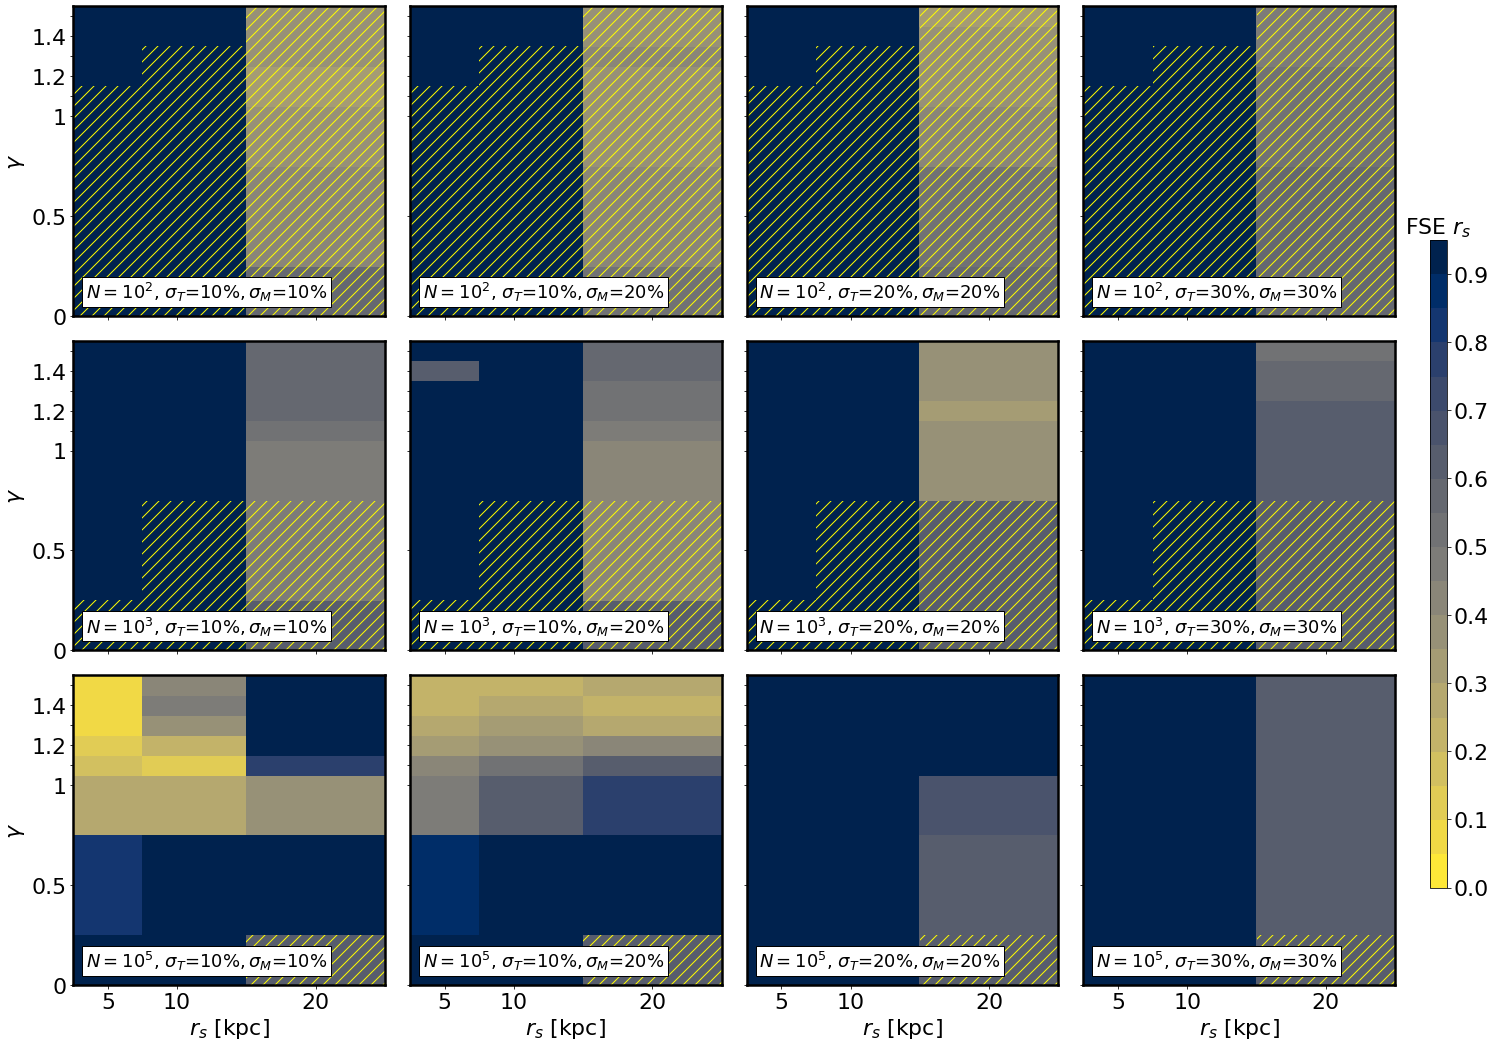

In [19]:
fig, ax = plt.subplots(3, 4, figsize=(24, 18))

path = "/home/mariacst/exoplanets/results/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex4", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex4", ax[0, 2], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex4", ax[0, 3], "median", False, False, False, False)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 0], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 0], 15, 1.35, 10, 0.20);
add_hatch(ax[0, 1], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 1], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 1], 15, 1.35, 10, 0.20);
add_hatch(ax[0, 2], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 2], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 2], 15, 1.35, 10, 0.20);
add_hatch(ax[0, 3], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 3], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 3], 15, 1.35, 10, 0.20);

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex4", ax[1, 1], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex4", ax[1, 2], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex4", ax[1, 3], "median", False, False, False, False)

add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 3], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 3], 7.5, 0.25, 17.5, 0.5);

im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 0], "median", False, False, True, True)
im   = grid_FSE(path, 100000, 0.1, 0.2, "ex4", ax[2, 1], "median", False, False, False, True)
im   = grid_FSE(path, 100000, 0.2, 0.2, "ex4", ax[2, 2], "median", False, False, False, True)
im   = grid_FSE(path, 100000, 0.3, 0.3, "ex4", ax[2, 3], "median", False, False, False, True)

add_hatch(ax[2, 0], 15, 0, 10, 0.25); add_hatch(ax[2, 1], 15, 0, 10, 0.25);
add_hatch(ax[2, 2], 15, 0, 10, 0.25); add_hatch(ax[2, 3], 15, 0, 10, 0.25);

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("/home/mariacst/exoplanets/Figs/FSE_rs_GC.pdf", bbox_inches="tight")

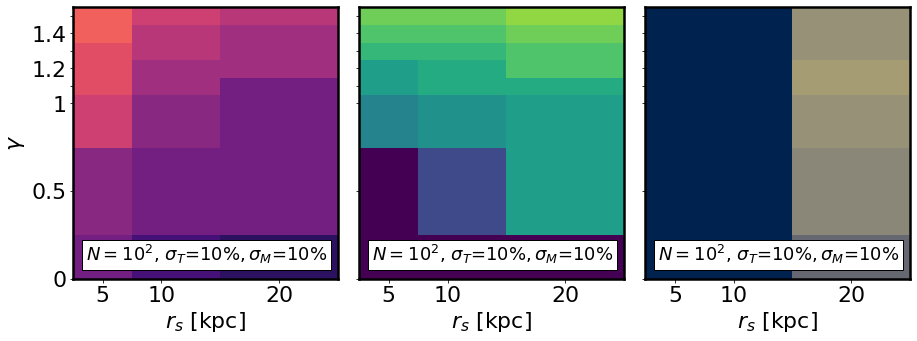

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

path = "/home/mariacst/exoplanets/results/GC/"
im1  = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0], "median", True, False, True, True)
im2  = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[1], "median", False, True, False, True)
im3  = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[2], "median", False, False, False, True)

fig.subplots_adjust(wspace=0.08, hspace=0.08)

In [8]:
1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)

array([0.1175031 , 0.39346934, 0.67534753, 0.86466472])

In [13]:
1-np.exp(-2)

0.8646647167633873

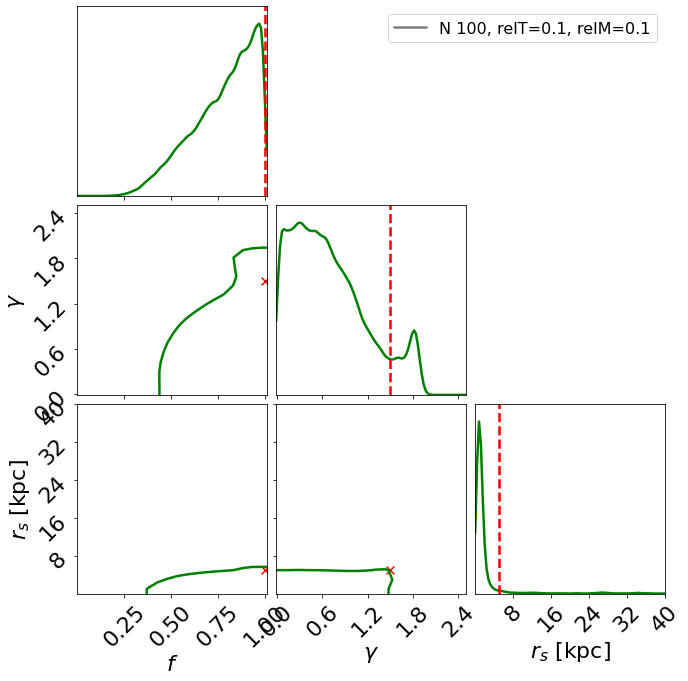

In [22]:
nBDs     = 100
relT     = 0.10
relM     = 0.10
f        = 1.
gamma    = 1.5
rs       = 5.
filepath = ("/hdfs/local/mariacst/exoplanets/results/final_round/Tmin/N%irelT%.2frelM%.2f/" %(nBDs, relT, relM))

_file    = open(filepath + 
                ("posterior_ex5_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-2),), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="green",
                   range=[(0., 1.01), (-0.01, 2.5), (0., 40.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="green", lw=2.5)    

"""
for i in range(5):
    _file    = open(filepath + 
                ("posterior_ex4_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv%i" 
                 %(nBDs, relT, relM, gamma, rs, i+1)), "rb") 
    samples  = pickle.load(_file)
    smooth=1.
    corner(samples, levels=(1-np.exp(-2),), plot_datapoints=False, 
                       plot_density=False, fill_contours=False, smooth=smooth, color="green",
                       range=[(0., 1.01), (-0.01, 2.5), (0., 40.)], fig=fig)
    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 4, 8], samples.T):
        kde   = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="green", lw=2.5)     
"""    
    
axes[0, 0].axvline(1., color="r", ls="--", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="--", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

colors = ['grey']
lines = [Line2D([0], [0], color=c, linewidth=2.5, linestyle='-') for c in colors]
labels = ['N %i, relT=%.1f, relM=%.1f' %(nBDs, relT, relM)]
axes[0, 2].legend(lines, labels, fontsize=16)

#fig.savefig(("../../Figs/corner_ex4_N%irelT%.2frelM%.2f_g%.1frs%.1f.pdf" %(nBDs, relT, relM, gamma, rs)), 
#            bbox_inches="tight")

## Effect of DM velocities

222.74887162652013
441.5021670872908
0.26609939339216876 0.17995033857871634


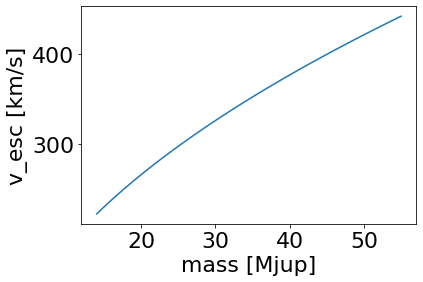

In [22]:
from astropy.constants import G, M_jup, R_jup
import astropy.units as u
from utils import heat_DM

def vesc(M, R):
    return (np.sqrt(2*G*M/R)).value*1e-3 # m/s


M = np.linspace(14, 55, 100)*M_jup.value

print(vesc(14*M_jup.value, R_jup.value))
print(vesc(55*M_jup.value, R_jup.value))

fig, ax = plt.subplots()
ax.plot(M/M_jup.value, vesc(M, R_jup.value))
ax.set_ylabel("v_esc [km/s]")
ax.set_xlabel("mass [Mjup]")

def ratio_heat_DM(vcp, vcm, M=M_jup.value, R=R_jup.value, ):
    """
    Heat flow due to DM capture and annihilation
    """
    vesc   = (np.sqrt(2*G*M/R)).value*1e-3 # m/s 
    _vDp    = np.sqrt(3/2.)*vcp
    _vDMp   =  np.sqrt(8./(3*np.pi))*_vDp # km/s
    
    _vDm    = np.sqrt(3/2.)*vcm
    _vDMm   =  np.sqrt(8./(3*np.pi))*_vDm # km/s

    # return
    return (_vDMp*(1+3./2.*np.power(vesc/_vDp, 2))/(_vDMm*(1+3./2.*np.power(vesc/_vDm, 2)))) # W

print(ratio_heat_DM(200., 30., 14*M_jup.value), ratio_heat_DM(200., 30., 55*M_jup.value))

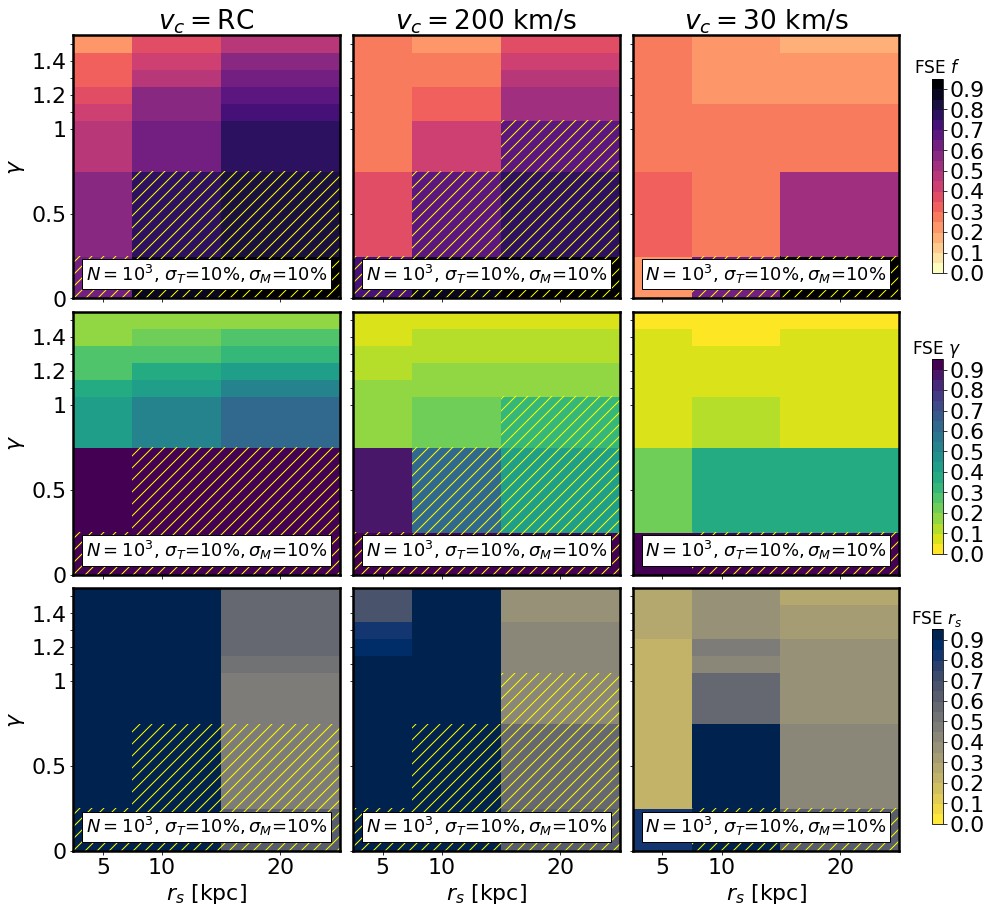

In [6]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

path = "/home/mariacst/exoplanets/results/GC/"
im1  = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[0, 0], "median", True, False, True, False)
im2  = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 0], "median", False, True, True, False)
im3  = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[2, 0], "median", False, False, True, True)

path = "/home/mariacst/exoplanets/results/velocity/"
im1  = grid_FSE(path, 1000, 0.1, 0.1, "ex6", ax[0, 1], "median", True, False, False, False)
im1  = grid_FSE(path, 1000, 0.1, 0.1, "ex7", ax[0, 2], "median", True, False, False, False)
im2  = grid_FSE(path, 1000, 0.1, 0.1, "ex6", ax[1, 1], "median", False, True, False, False)
im2  = grid_FSE(path, 1000, 0.1, 0.1, "ex7", ax[1, 2], "median", False, True, False, False)
im3  = grid_FSE(path, 1000, 0.1, 0.1, "ex6", ax[2, 1], "median", False, False, False, True)
im3  = grid_FSE(path, 1000, 0.1, 0.1, "ex7", ax[2, 2], "median", False, False, False, True)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[0, 0], 7.5, 0.25, 17.5, 0.5); 
add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 7.5, 0.25, 17.5, 0.5); 
add_hatch(ax[2, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[2, 0], 7.5, 0.25, 17.5, 0.5); 

add_hatch(ax[0, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[0, 1], 7.5, 0.25, 17.5, 0.5); add_hatch(ax[0, 1], 15, 0.75, 10, 0.3); 
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 7.5, 0.25, 17.5, 0.5); add_hatch(ax[1, 1], 15, 0.75, 10, 0.3); 
add_hatch(ax[2, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[2, 1], 7.5, 0.25, 17.5, 0.5); add_hatch(ax[2, 1], 15, 0.75, 10, 0.3); 

add_hatch(ax[0, 2], 7.5, 0, 17.5, 0.25); add_hatch(ax[1, 2], 7.5, 0, 17.5, 0.25); add_hatch(ax[2, 2], 7.5, 0, 17.5, 0.25);

fig.subplots_adjust(right=0.89)
cbar_ax1 = fig.add_axes([0.92, 0.66, 0.01, 0.18])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
cbar1.ax.set_title(r"FSE $f$", size=17.)
cbar_ax2 = fig.add_axes([0.92, 0.4, 0.01, 0.18])
cbar2 = fig.colorbar(im2, cax=cbar_ax2)
cbar2.ax.set_title(r"FSE $\gamma$", size=17.)
cbar_ax3 = fig.add_axes([0.92, 0.15, 0.01, 0.18])
cbar3 = fig.colorbar(im3, cax=cbar_ax3)
cbar3.ax.set_title(r"FSE $r_s$", size=17.)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

ax[0, 0].set_title(r"$v_{c}=$RC")
ax[0, 1].set_title(r"$v_{c}=200$ km/s")
ax[0, 2].set_title(r"$v_{c}=30$ km/s")

fig.savefig("../../Figs/DMvelocity_FSE.pdf", bbox_inches="tight")

## Investigate funny behaviour $(\gamma=1., rs=20)$ for $10^4$ BDs

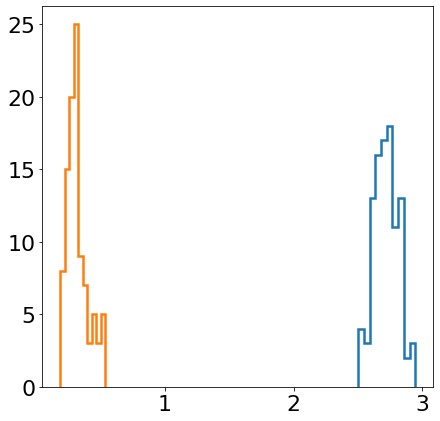

In [23]:
f = 1.; gamma = 1.; rs = 20.; nBDs = 10000
filepath = "../../results/"

relT = 0.2; relM=0.2
data = np.genfromtxt(filepath + "statistics_ex3" + ("_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1f"
                                  %(nBDs, relT, relM, f, gamma, rs)), unpack=True)
gamma02 = data[4]

relT = 0.3; relM=0.3
data = np.genfromtxt(filepath + "statistics_ex3" + ("_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1f"
                                  %(nBDs, relT, relM, f, gamma, rs)), unpack=True)
gamma03 = data[4]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

counts02, bins02, _ = ax.hist(gamma02, histtype="step", lw=2.5)
counts03, bins03, _ = ax.hist(gamma03, histtype="step", lw=2.5)

## Priors

In [4]:
#rc('font',**{'family':'serif','serif':['Palatino'], 'size':18})
from matplotlib.lines import Line2D

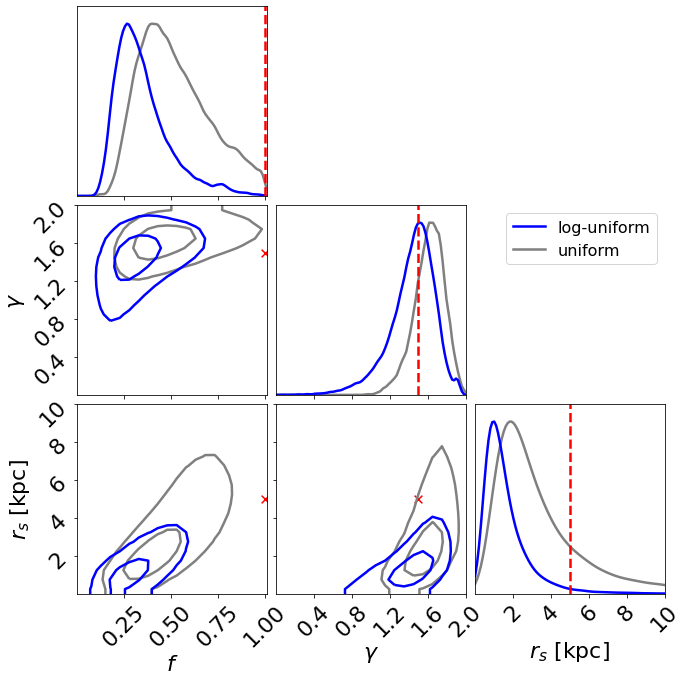

In [17]:
nBDs     = 1000
relT     = 0.10
relM     = 0.10
f        = 1.
gamma    = 1.5
rs       = 5.
filepath = "/home/mariacst/exoplanets/results/priors/"

_file    = open(filepath + 
                ("posterior_ex3_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1.0" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="grey", 
                   range=[(0., 1.01), (0., 2.), (0., 10.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="grey", lw=2.5)    

_file    = open(filepath + 
                ("posterior_ex3log_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1.0" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
samples[:, 0] = np.power(10, samples[:, 0]) # Transform log(f)->f
samples[:, 2] = np.power(10, samples[:, 2]) # Transform log(rs)->rs

smooth=1.
corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
       plot_density=False, fill_contours=False, smooth=smooth, color="blue", 
       range=[(0., 1.01), (0., 2.), (0., 10.)], fig=fig)
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="blue", lw=2.5)

axes[0, 0].axvline(1., color="r", ls="--", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="--", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

colors = ['blue', 'grey']
lines = [Line2D([0], [0], color=c, linewidth=2.5, linestyle='-') for c in colors]
labels = ['log-uniform', 'uniform']
axes[1, 2].legend(lines, labels, fontsize=16)

fig.savefig(("../../Figs/posterior_prior_N%irelT%.2frelM%.2f_g%.1frs%.1f.pdf" %(nBDs, relT, relM, gamma, rs)), 
            bbox_inches="tight")

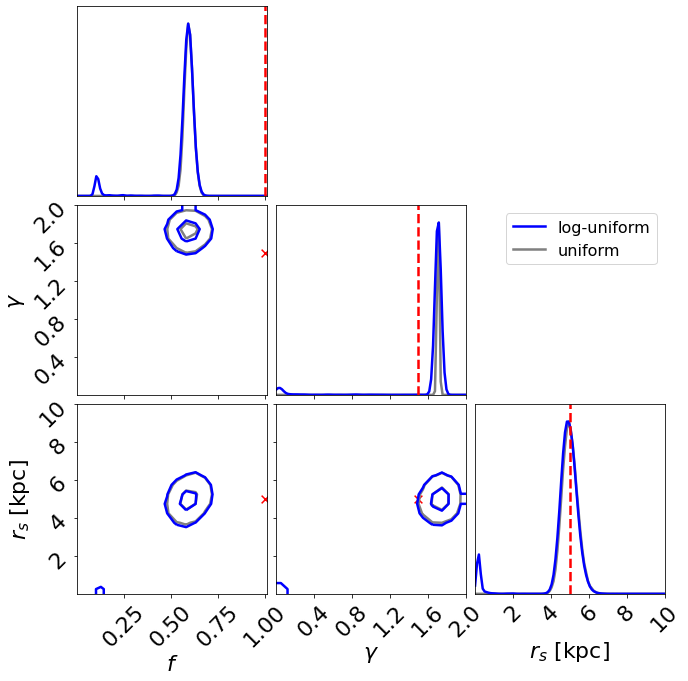

In [11]:
nBDs     = 100000
relT     = 0.10
relM     = 0.10
f        = 1.
gamma    = 1.5
rs       = 5.
filepath = "/home/mariacst/exoplanets/results/priors/"

_file    = open(filepath + 
                ("posterior_ex3_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1.0" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="grey",
                   range=[(0., 1.01), (0., 2.), (0., 10.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="grey", lw=2.5)    

_file    = open(filepath + 
                ("posterior_ex3log_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1.0" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
samples[:, 0] = np.power(10, samples[:, 0]) # Transform log(f)->f
samples[:, 2] = np.power(10, samples[:, 2]) # Transform log(rs)->rs

smooth=1.
corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
       plot_density=False, fill_contours=False, smooth=smooth, color="blue", 
       range=[(0., 1.01), (0., 2.), (0., 10.)], fig=fig)
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="blue", lw=2.5)

axes[0, 0].axvline(1., color="r", ls="--", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="--", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

colors = ['blue', 'grey']
lines = [Line2D([0], [0], color=c, linewidth=2.5, linestyle='-') for c in colors]
labels = ['log-uniform', 'uniform']
axes[1, 2].legend(lines, labels, fontsize=16)

fig.savefig(("../../Figs/posterior_prior_N%irelT%.2frelM%.2f_g%.1frs%.1f.pdf" %(nBDs, relT, relM, gamma, rs)), 
            bbox_inches="tight")

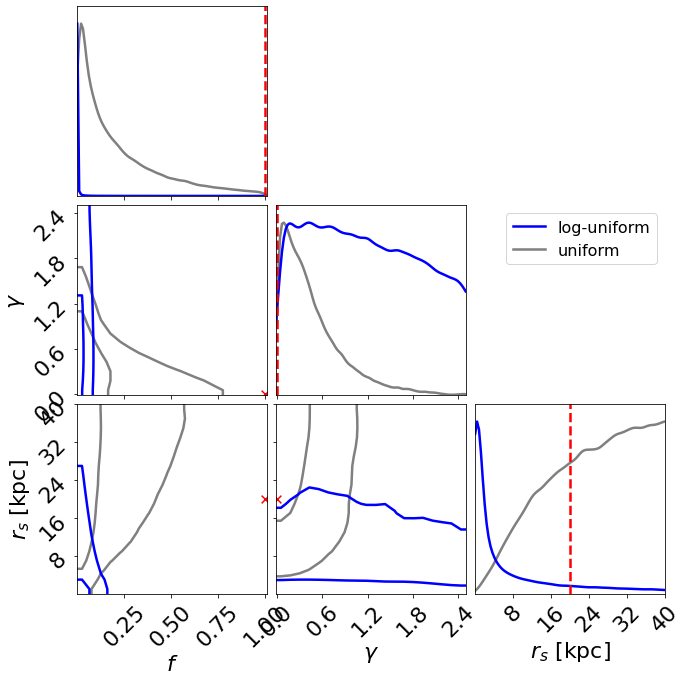

In [15]:
nBDs     = 1000
relT     = 0.10
relM     = 0.10
f        = 1.
gamma    = 0.
rs       = 20.
filepath = "/home/mariacst/exoplanets/results/priors/"

_file    = open(filepath + 
                ("posterior_ex3_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1.0" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="grey",
                   range=[(0., 1.01), (-0.01, 2.5), (0., 40.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="grey", lw=2.5)    

_file    = open(filepath + 
                ("posterior_ex3log_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1.0" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
samples[:, 0] = np.power(10, samples[:, 0]) # Transform log(f)->f
samples[:, 2] = np.power(10, samples[:, 2]) # Transform log(rs)->rs

smooth=1.
corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
       plot_density=False, fill_contours=False, smooth=smooth, color="blue", 
       range=[(0., 1.01), (-0.01, 2.5), (0., 40.)], fig=fig)
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="blue", lw=2.5)

axes[0, 0].axvline(1., color="r", ls="--", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="--", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

colors = ['blue', 'grey']
lines = [Line2D([0], [0], color=c, linewidth=2.5, linestyle='-') for c in colors]
labels = ['log-uniform', 'uniform']
axes[1, 2].legend(lines, labels, fontsize=16)

fig.savefig(("../../Figs/posterior_prior_N%irelT%.2frelM%.2f_g%.1frs%.1f.pdf" %(nBDs, relT, relM, gamma, rs)), 
            bbox_inches="tight")

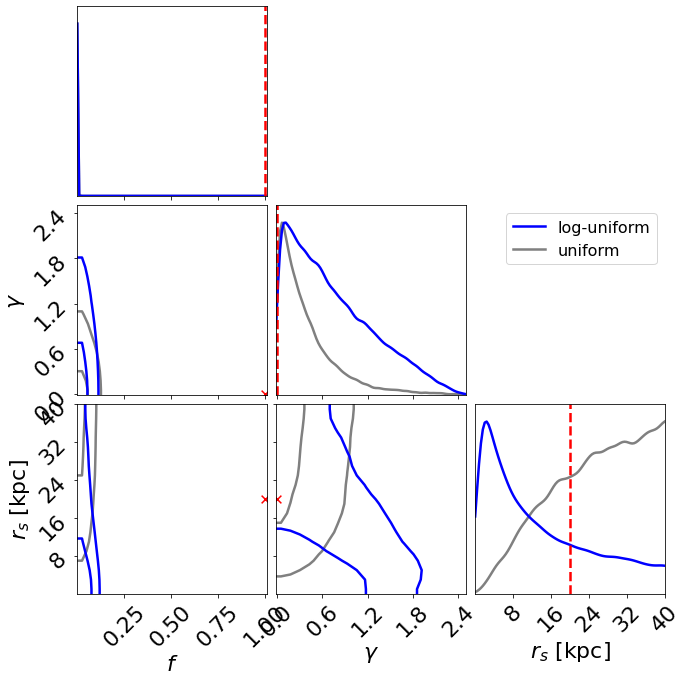

In [16]:
nBDs     = 100000
relT     = 0.10
relM     = 0.10
f        = 1.
gamma    = 0.
rs       = 20.
filepath = "/home/mariacst/exoplanets/results/priors/"

_file    = open(filepath + 
                ("posterior_ex3_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1.0" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="grey",
                   range=[(0., 1.01), (-0.01, 2.5), (0., 40.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="grey", lw=2.5)    

_file    = open(filepath + 
                ("posterior_ex3log_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1.0" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
samples[:, 0] = np.power(10, samples[:, 0]) # Transform log(f)->f
samples[:, 2] = np.power(10, samples[:, 2]) # Transform log(rs)->rs

smooth=1.
corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
       plot_density=False, fill_contours=False, smooth=smooth, color="blue", 
       range=[(0., 1.01), (-0.01, 2.5), (0., 40.)], fig=fig)
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="blue", lw=2.5)

axes[0, 0].axvline(1., color="r", ls="--", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="--", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

colors = ['blue', 'grey']
lines = [Line2D([0], [0], color=c, linewidth=2.5, linestyle='-') for c in colors]
labels = ['log-uniform', 'uniform']
axes[1, 2].legend(lines, labels, fontsize=16)

fig.savefig(("../../Figs/posterior_prior_N%irelT%.2frelM%.2f_g%.1frs%.1f.pdf" %(nBDs, relT, relM, gamma, rs)), 
            bbox_inches="tight")

## Galactic center with $T_{min}=650$ K

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


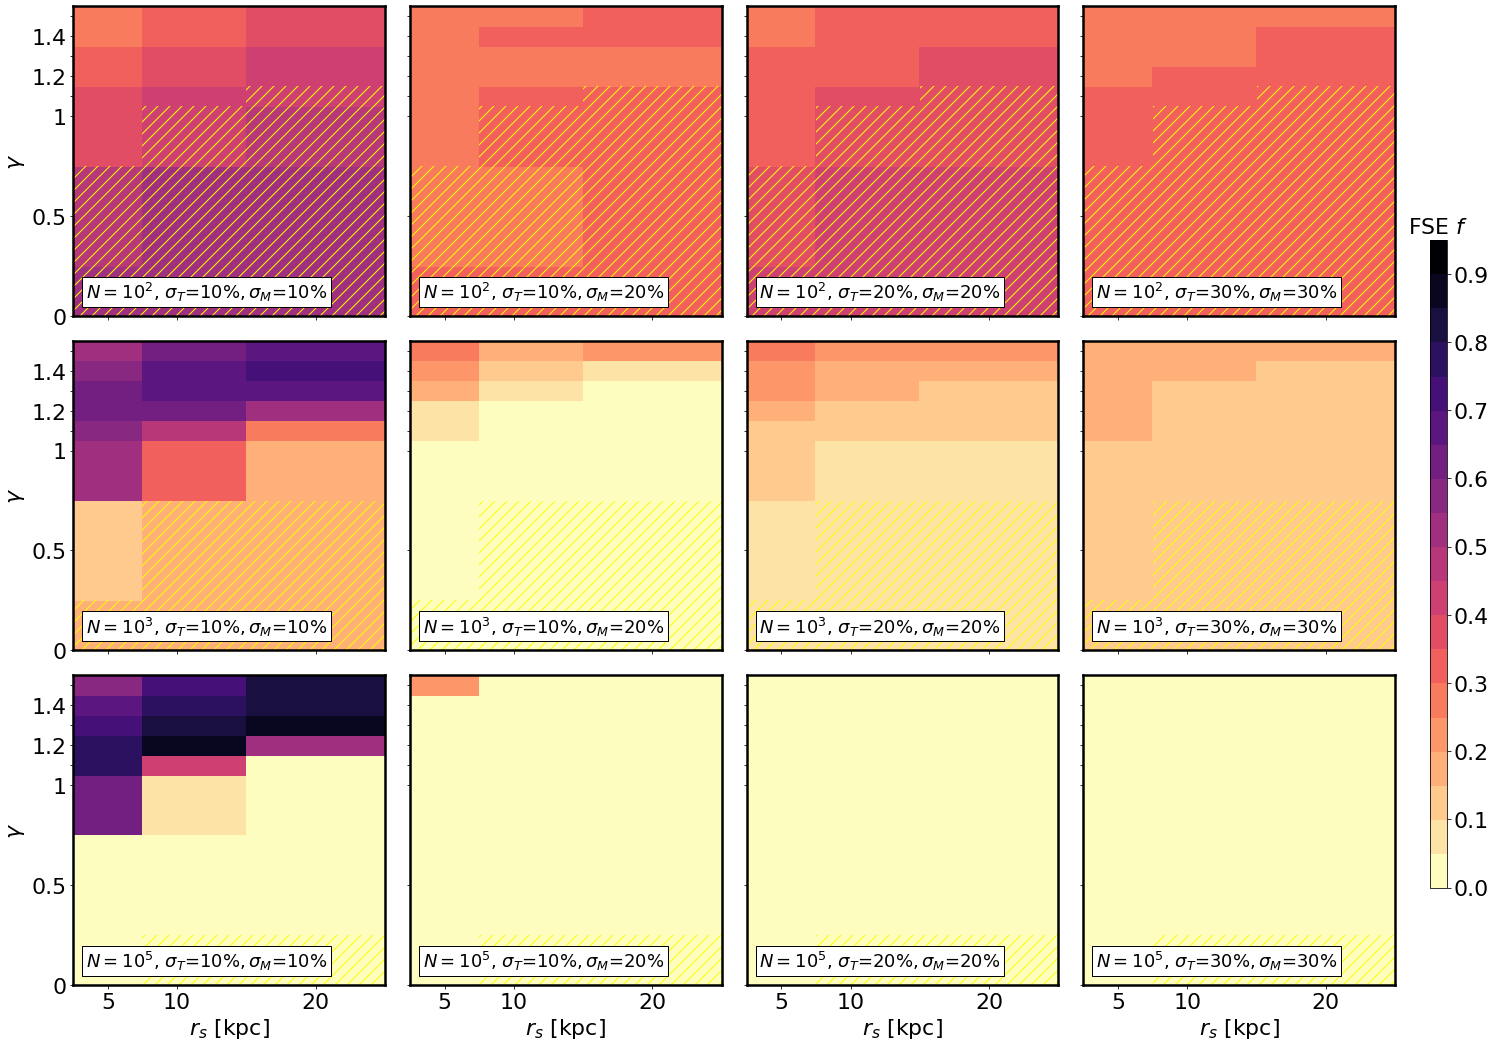

In [4]:
fig, ax = plt.subplots(3, 4, figsize=(24, 18))

path = "/home/mariacst/exoplanets/results/Tmin/"

im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex4", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex4", ax[0, 2], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex4", ax[0, 3], "median", True, False, False, False)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 0], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 0], 15, 1.05, 10, 0.1);
add_hatch(ax[0, 1], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 1], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 1], 15, 1.05, 10, 0.1);
add_hatch(ax[0, 2], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 2], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 2], 15, 1.05, 10, 0.1);
add_hatch(ax[0, 3], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 3], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 3], 15, 1.05, 10, 0.1);

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex4", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex4", ax[1, 2], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex4", ax[1, 3], "median", True, False, False, False)

add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 3], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 3], 7.5, 0.25, 17.5, 0.5);

im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 0], "median", True, False, True, True)
im   = grid_FSE(path, 100000, 0.1, 0.2, "ex4", ax[2, 1], "median", True, False, False, True)
im   = grid_FSE(path, 100000, 0.2, 0.2, "ex4", ax[2, 2], "median", True, False, False, True)
im   = grid_FSE(path, 100000, 0.3, 0.3, "ex4", ax[2, 3], "median", True, False, False, True)

add_hatch(ax[2, 0], 7.5, 0, 17.5, 0.25);
add_hatch(ax[2, 1], 7.5, 0, 17.5, 0.25);
add_hatch(ax[2, 2], 7.5, 0, 17.5, 0.25);
add_hatch(ax[2, 3], 7.5, 0, 17.5, 0.25);


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("FSE $f$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("/home/mariacst/exoplanets/Figs/FSE_f_GC_Tmin.pdf", bbox_inches="tight")

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


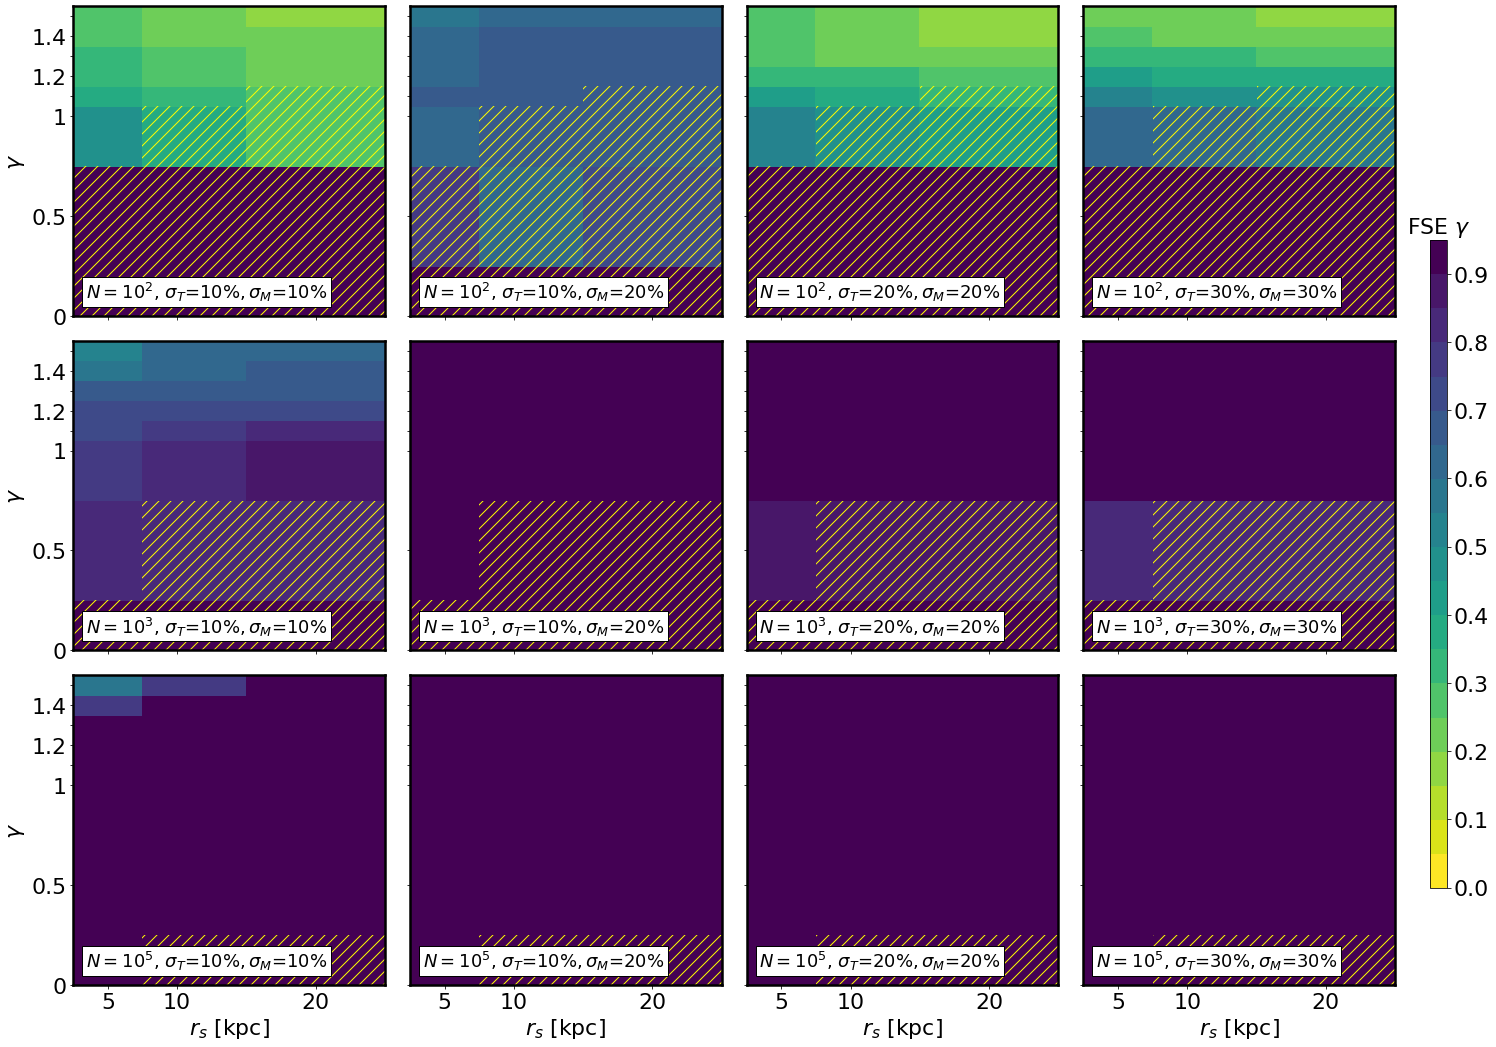

In [35]:
fig, ax = plt.subplots(3, 4, figsize=(24, 18))

path = "/home/mariacst/exoplanets/results/Tmin/"

im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex5", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex4", ax[0, 2], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex4", ax[0, 3], "median", False, True, False, False)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 0], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 0], 15, 1.05, 10, 0.1);
add_hatch(ax[0, 1], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 1], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 1], 15, 1.05, 10, 0.1);
add_hatch(ax[0, 2], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 2], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 2], 15, 1.05, 10, 0.1);
add_hatch(ax[0, 3], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 3], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 3], 15, 1.05, 10, 0.1);


im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex4", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex4", ax[1, 2], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex4", ax[1, 3], "median", False, True, False, False)

add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 3], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 3], 7.5, 0.25, 17.5, 0.5);

im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 0], "median", False, True, True, True)
im   = grid_FSE(path, 100000, 0.1, 0.2, "ex4", ax[2, 1], "median", False, True, False, True)
im   = grid_FSE(path, 100000, 0.2, 0.2, "ex4", ax[2, 2], "median", False, True, False, True)
im   = grid_FSE(path, 100000, 0.3, 0.3, "ex4", ax[2, 3], "median", False, True, False, True)

add_hatch(ax[2, 0], 7.5, 0, 17.5, 0.25);
add_hatch(ax[2, 1], 7.5, 0, 17.5, 0.25);
add_hatch(ax[2, 2], 7.5, 0, 17.5, 0.25);
add_hatch(ax[2, 3], 7.5, 0, 17.5, 0.25);


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("/home/mariacst/exoplanets/Figs/FSE_gamma_GC_Tmin.pdf", bbox_inches="tight")

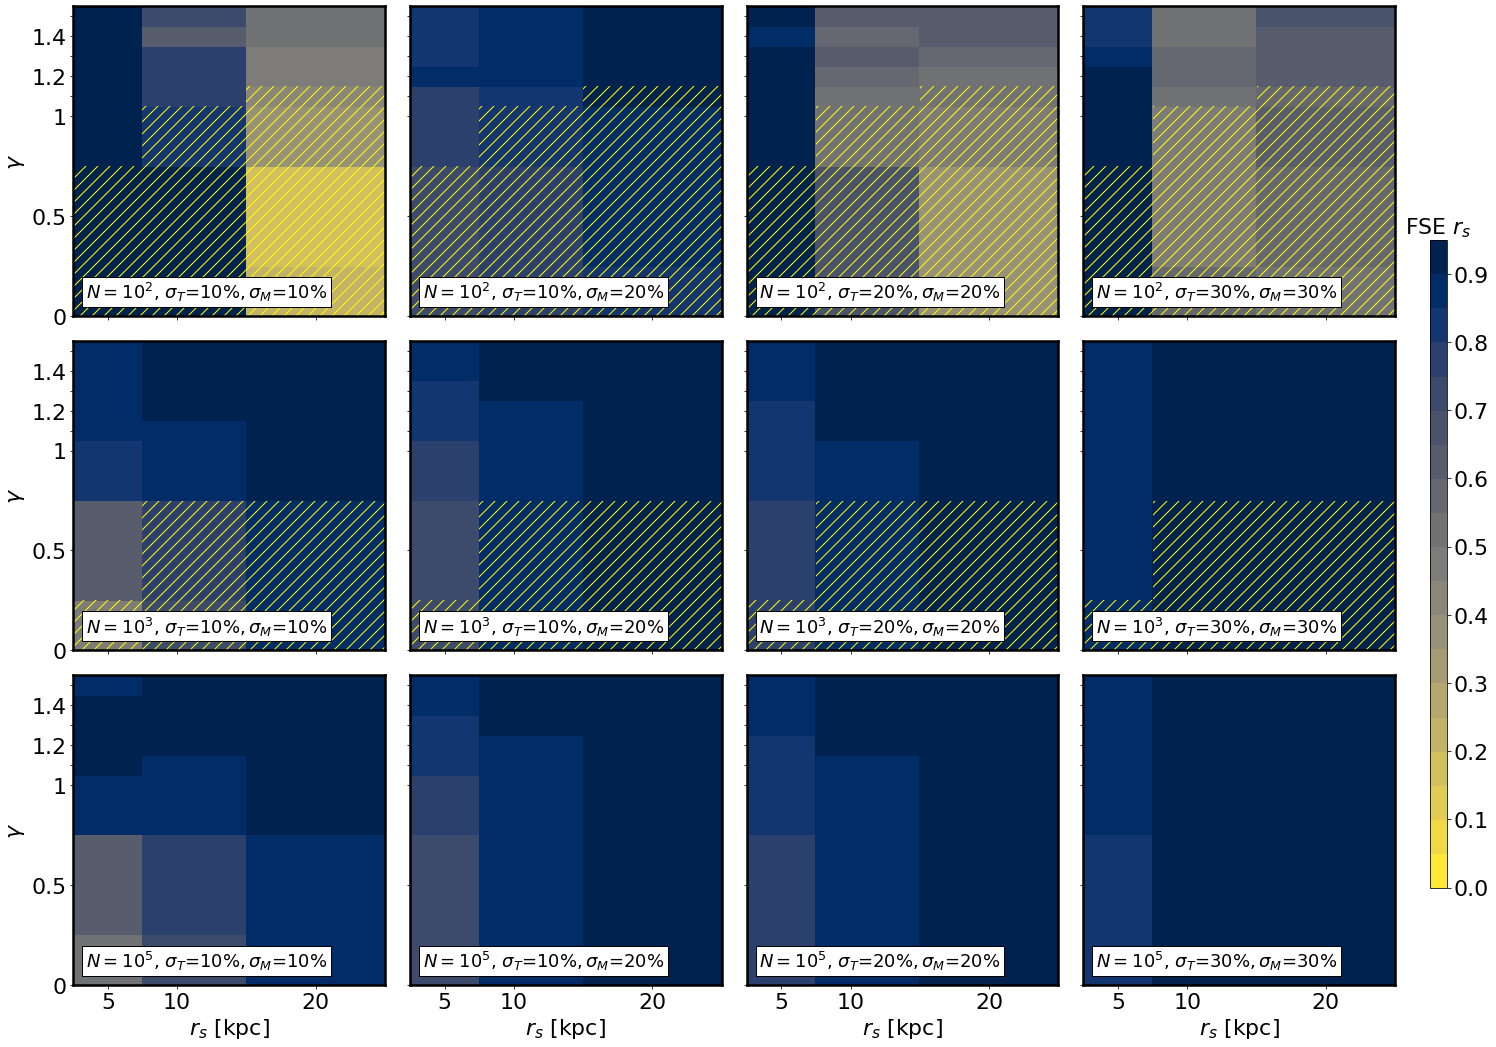

In [9]:
fig, ax = plt.subplots(3, 4, figsize=(24, 18))

path = "/home/mariacst/exoplanets/results/Tmin/"

im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex4", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex4", ax[0, 2], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex4", ax[0, 3], "median", False, False, False, False)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 0], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 0], 15, 1.05, 10, 0.1);
add_hatch(ax[0, 1], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 1], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 1], 15, 1.05, 10, 0.1);
add_hatch(ax[0, 2], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 2], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 2], 15, 1.05, 10, 0.1);
add_hatch(ax[0, 3], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 3], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 3], 15, 1.05, 10, 0.1);


im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex4", ax[1, 1], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex4", ax[1, 2], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex4", ax[1, 3], "median", False, False, False, False)

add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[1, 3], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 3], 7.5, 0.25, 17.5, 0.5);

im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 0], "median", False, False, True, True)
im   = grid_FSE(path, 100000, 0.1, 0.2, "ex4", ax[2, 1], "median", False, False, False, True)
im   = grid_FSE(path, 100000, 0.2, 0.2, "ex4", ax[2, 2], "median", False, False, False, True)
im   = grid_FSE(path, 100000, 0.3, 0.3, "ex4", ax[2, 3], "median", False, False, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("/home/mariacst/exoplanets/Figs/FSE_rs_GC_Tmin.pdf", bbox_inches="tight")

In [13]:
imp.reload(mock_generation)

from mock_generation import mock_population
#mock_population?

In [70]:
N = 100; gamma=1.5; rs = 5.; f = 1.

simu=100

bins_robs = np.logspace(-1, 0, 10)
bins_mass = np.linspace(0.013, 0.053, 10)
bins_ages = np.linspace(1, 10, 10)

counts_robs0 = np.zeros((simu, 9)); counts_robs1 = np.zeros((simu, 9)); counts_robs2 = np.zeros((simu, 9))
counts_mass0 = np.zeros((simu, 9)); counts_mass1 = np.zeros((simu, 9)); counts_mass2 = np.zeros((simu, 9))
counts_ages0 = np.zeros((simu, 9)); counts_ages1 = np.zeros((simu, 9)); counts_ages2 = np.zeros((simu, 9))

for i in range(simu):
    robs0, Tobs0, mass0, ages0 = mock_population(N, 0.10, 0.10, f, gamma, rs, Tmin=650.)
    robs1, Tobs1, mass1, ages1 = mock_population(N, 0.10, 0.20, f, gamma, rs, Tmin=650.)
    robs2, Tobs2, mass2, ages2 = mock_population(N, 0.20, 0.20, f, gamma, rs, Tmin=650.)
    
    c_robs0, _ = np.histogram(robs0, bins=bins_robs); c_robs1, _ = np.histogram(robs1, bins=bins_robs)
    c_robs2, _ = np.histogram(robs2, bins=bins_robs)
    c_mass0, _ = np.histogram(mass0, bins=bins_mass); c_mass1, _ = np.histogram(mass1, bins=bins_mass)
    c_mass2, _ = np.histogram(mass2, bins=bins_mass)
    c_ages0, _ = np.histogram(ages0, bins=bins_ages); c_ages1, _ = np.histogram(ages1, bins=bins_ages)
    c_ages2, _ = np.histogram(ages2, bins=bins_ages)
    
    counts_robs0[i] = c_robs0; counts_robs1[i] = c_robs1; counts_robs2[i] = c_robs2
    counts_mass0[i] = c_mass0; counts_mass1[i] = c_mass1; counts_mass2[i] = c_mass2
    counts_ages0[i] = c_ages0; counts_ages1[i] = c_ages1; counts_ages2[i] = c_ages2

Text(0.5, 0, 'ages [Gyr]')

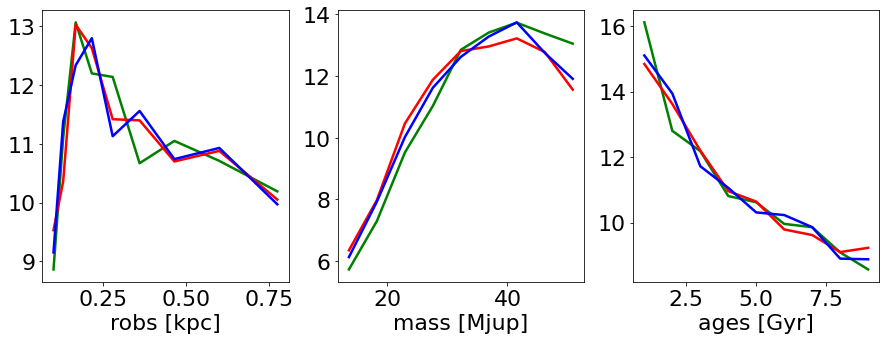

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(bins_robs[:-1], np.mean(counts_robs0, axis=0), color="green", lw=2.5)
ax[0].plot(bins_robs[:-1], np.mean(counts_robs1, axis=0), color="red", lw=2.5)
ax[0].plot(bins_robs[:-1], np.mean(counts_robs2, axis=0), color="blue", lw=2.5)
ax[0].set_xlabel("robs [kpc]")

ax[1].plot(bins_mass[:-1]*M_sun.value/M_jup.value, np.mean(counts_mass0, axis=0), color="green", lw=2.5)
ax[1].plot(bins_mass[:-1]*M_sun.value/M_jup.value, np.mean(counts_mass1, axis=0), color="red", lw=2.5)
ax[1].plot(bins_mass[:-1]*M_sun.value/M_jup.value, np.mean(counts_mass2, axis=0), color="blue", lw=2.5)
ax[1].set_xlabel("mass [Mjup]")

ax[2].plot(bins_ages[:-1], np.mean(counts_ages0, axis=0), color="green", lw=2.5)
ax[2].plot(bins_ages[:-1], np.mean(counts_ages1, axis=0), color="red", lw=2.5)
ax[2].plot(bins_ages[:-1], np.mean(counts_ages2, axis=0), color="blue", lw=2.5)
ax[2].set_xlabel("ages [Gyr]")

**Only imposing $T_{obs}^{real}>0$**

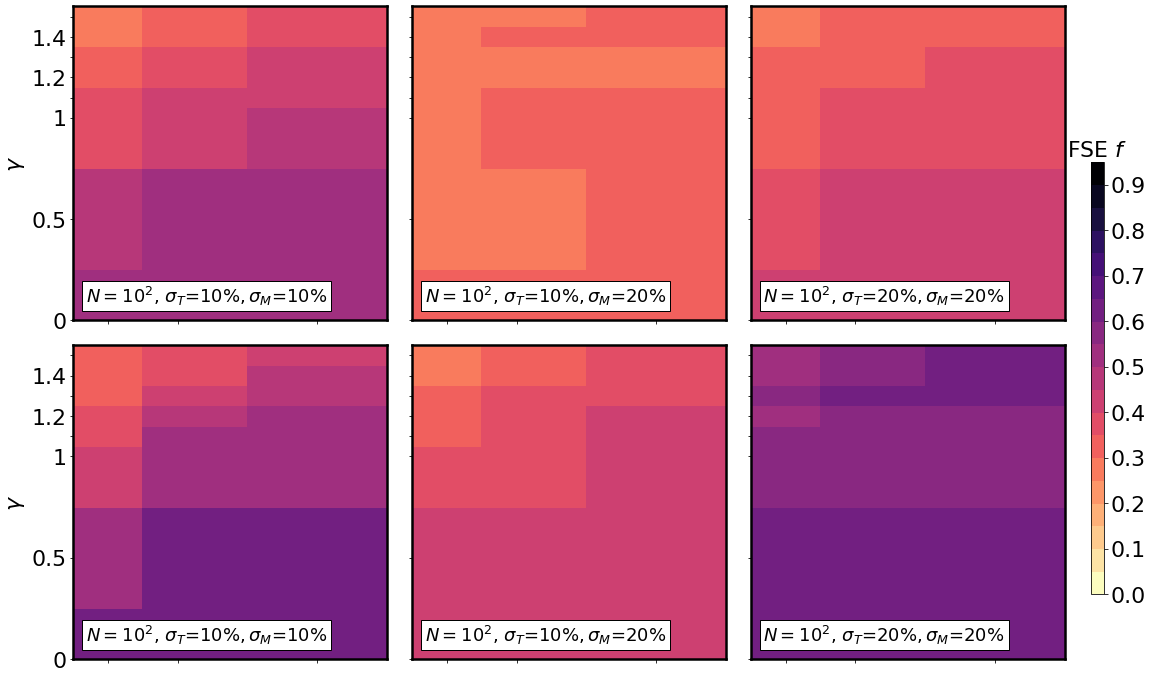

In [67]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

path = "/home/mariacst/exoplanets/results/Tmin/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex4", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex4", ax[0, 2], "median", True, False, False, False)

path = "/home/mariacst/exoplanets/results/Tmin/ex12/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex12", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex12", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex12", ax[1, 2], "median", True, False, False, False)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("FSE $f$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

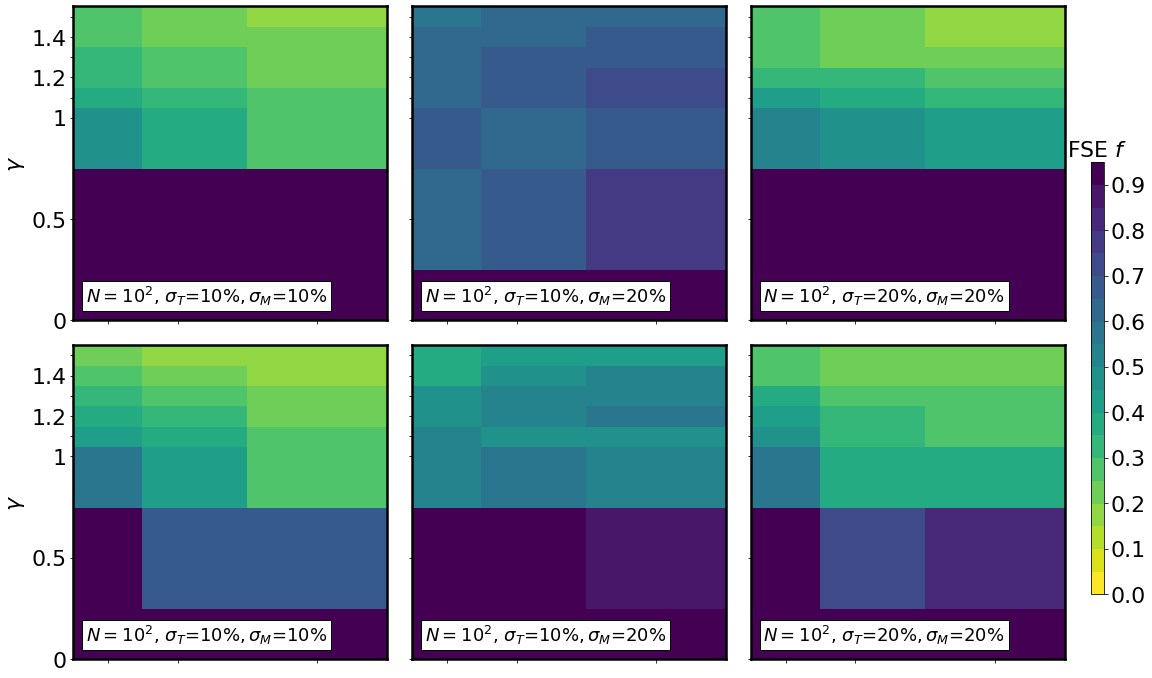

In [68]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

path = "/home/mariacst/exoplanets/results/Tmin/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex4", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex4", ax[0, 2], "median", False, True, False, False)

path = "/home/mariacst/exoplanets/results/Tmin/ex12/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex12", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex12", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex12", ax[1, 2], "median", False, True, False, False)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("FSE $f$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

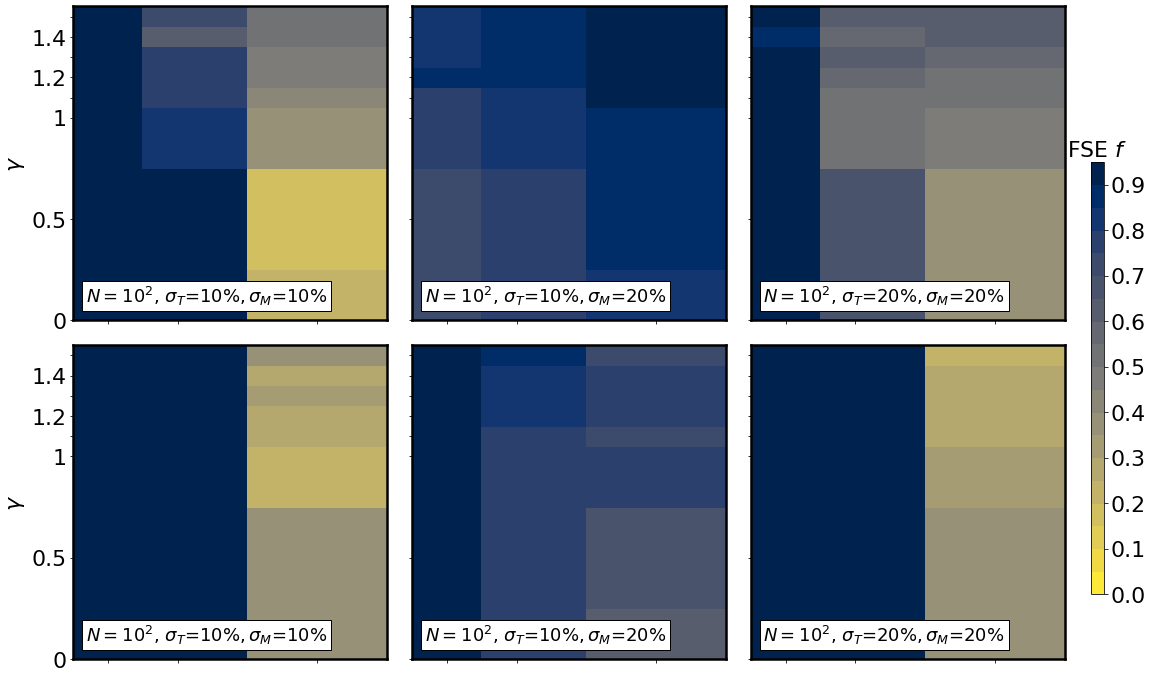

In [69]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

path = "/home/mariacst/exoplanets/results/Tmin/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex4", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex4", ax[0, 2], "median", False, False, False, False)

path = "/home/mariacst/exoplanets/results/Tmin/ex12/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex12", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex12", ax[1, 1], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex12", ax[1, 2], "median", False, False, False, False)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("FSE $f$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

## Comparison all analysis

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


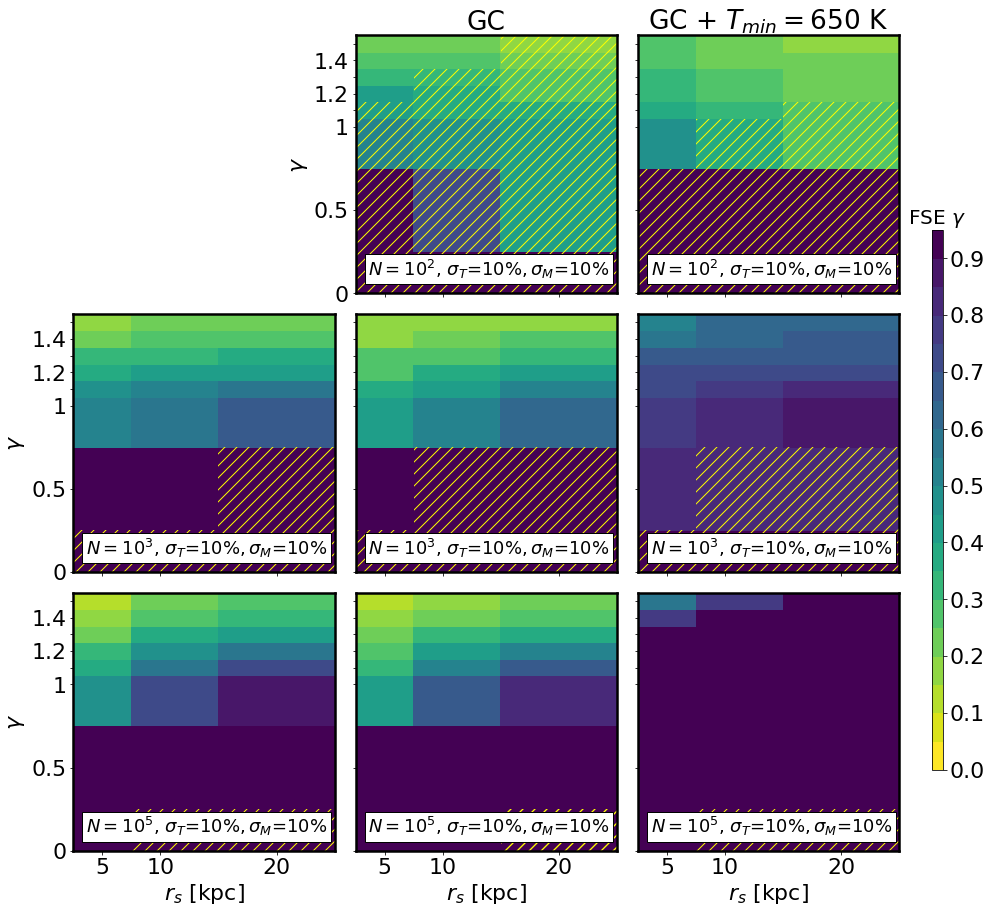

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

ax[0, 0].set_title("All Galaxy")
ax[0, 1].set_title("GC")
ax[0, 2].set_title(r"GC + $T_{min}=650$ K")

path = "/home/mariacst/exoplanets/results/whole/"
ax[0, 0].set_visible(False)
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex3", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100000, 0.1, 0.1, "ex3", ax[2, 0], "median", False, True, True, True)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 0], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 0], 15, 1.05, 10, 0.1)
add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 15, 0.25, 10, 0.5);
add_hatch(ax[2, 0], 7.5, 0, 17.5, 0.25); 


path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 1], "median", False, True, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 1], "median", False, True, False, True)

add_hatch(ax[0, 1], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 1], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 1], 15, 1.35, 10, 0.20);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[2, 1], 15, 0, 10, 0.25); add_hatch(ax[2, 1], 15, 0, 10, 0.25);

path = "/home/mariacst/exoplanets/results/Tmin/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 2], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 2], "median", False, True, False, False)
im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 2], "median", False, True, False, True)

add_hatch(ax[0, 2], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 2], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 2], 15, 1.05, 10, 0.1);
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[2, 2], 7.5, 0, 17.5, 0.25); 


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("/home/mariacst/exoplanets/Figs/FSE_gamma_comparison.pdf", bbox_inches="tight")

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


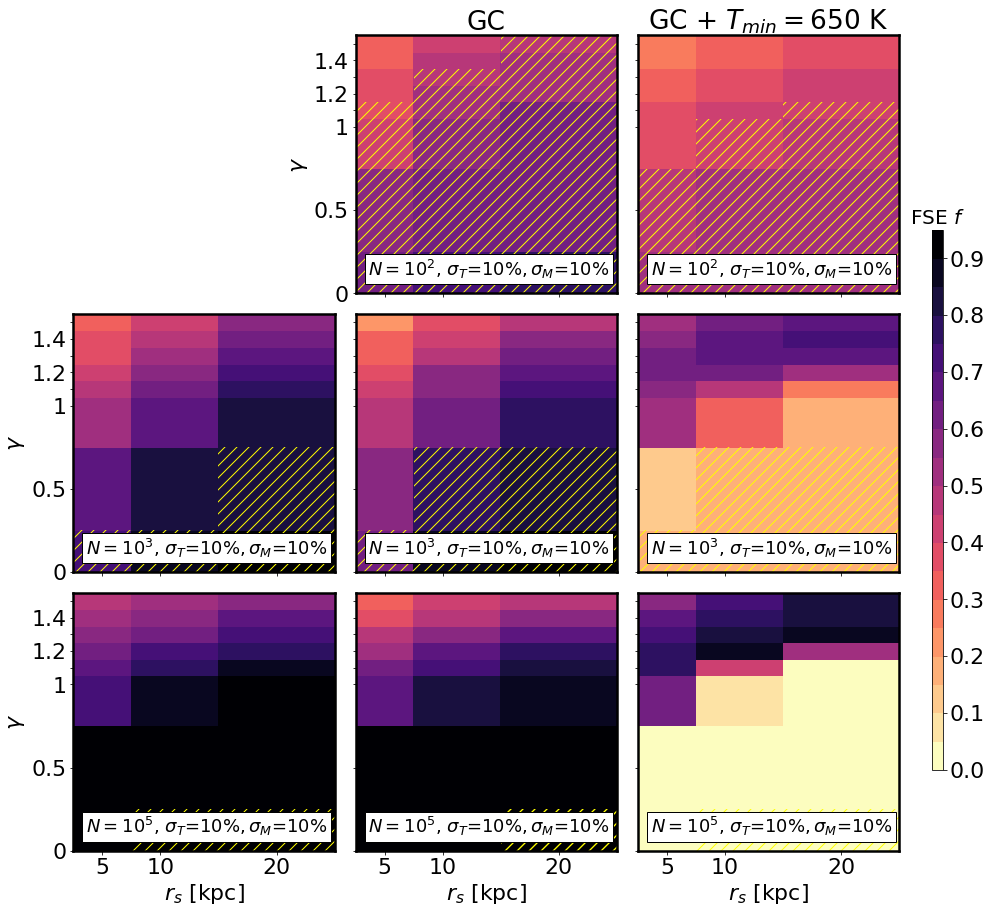

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

ax[0, 0].set_title("All Galaxy")
ax[0, 1].set_title("GC")
ax[0, 2].set_title(r"GC + $T_{min}=650$ K")

path = "/home/mariacst/exoplanets/results/whole/"
ax[0, 0].set_visible(False)
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex3", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE(path, 100000, 0.1, 0.1, "ex3", ax[2, 0], "median", True, False, True, True)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 0], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 0], 15, 1.05, 10, 0.1)
add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 15, 0.25, 10, 0.5);
add_hatch(ax[2, 0], 7.5, 0, 17.5, 0.25); 


path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 1], "median", True, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 1], "median", True, False, False, True)

add_hatch(ax[0, 1], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 1], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 1], 15, 1.35, 10, 0.20);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[2, 1], 15, 0, 10, 0.25); add_hatch(ax[2, 1], 15, 0, 10, 0.25);

path = "/home/mariacst/exoplanets/results/Tmin/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 2], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 2], "median", True, False, False, False)
im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 2], "median", True, False, False, True)

add_hatch(ax[0, 2], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 2], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 2], 15, 1.05, 10, 0.1);
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[2, 2], 7.5, 0, 17.5, 0.25); 

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $f$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("/home/mariacst/exoplanets/Figs/FSE_f_comparison.pdf", bbox_inches="tight")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


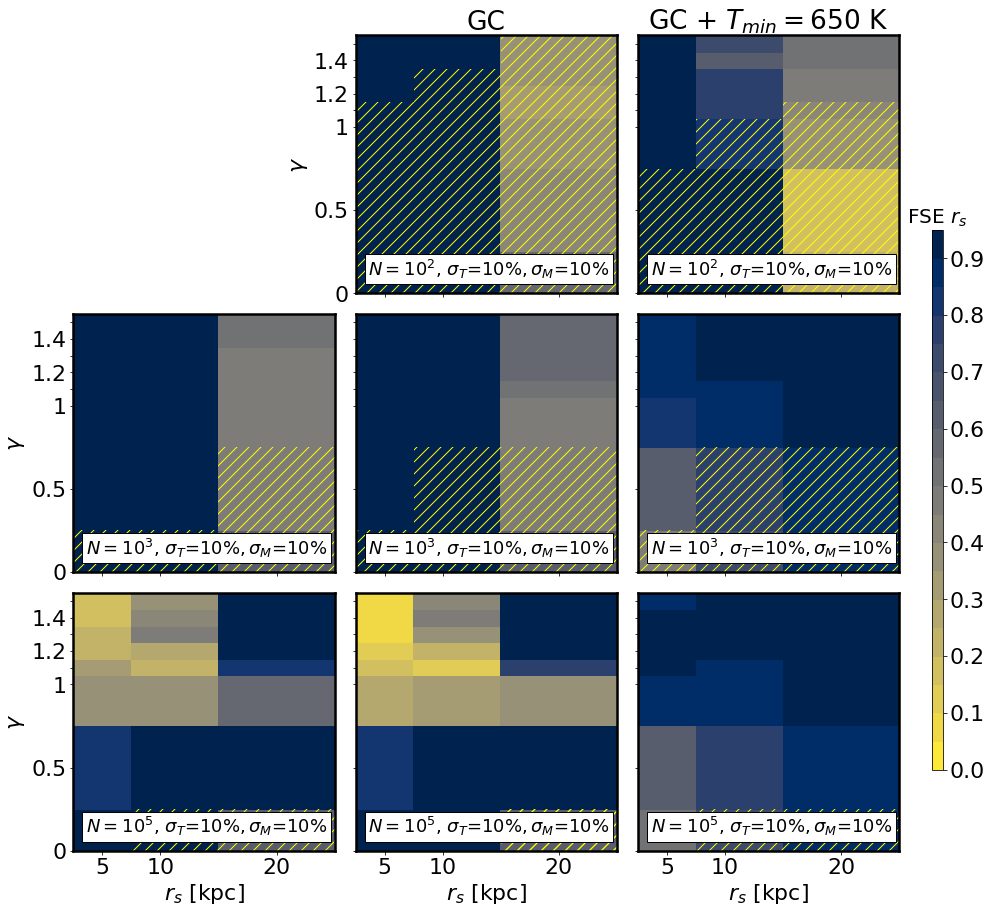

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

ax[0, 0].set_title("All Galaxy")
ax[0, 1].set_title("GC")
ax[0, 2].set_title(r"GC + $T_{min}=650$ K")

path = "/home/mariacst/exoplanets/results/whole/"
ax[0, 0].set_visible(False)
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex3", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE(path, 100000, 0.1, 0.1, "ex3", ax[2, 0], "median", False, False, True, True)

add_hatch(ax[0, 0], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 0], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 0], 15, 1.05, 10, 0.1)
add_hatch(ax[1, 0], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 0], 15, 0.25, 10, 0.5);
add_hatch(ax[2, 0], 7.5, 0, 17.5, 0.25); 


path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 1], "median", False, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 1], "median", False, False, False, False)
im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 1], "median", False, False, False, True)

add_hatch(ax[0, 1], 2.5, 0, 22.5, 1.15); add_hatch(ax[0, 1], 7.5, 1.15, 17.5, 0.20); add_hatch(ax[0, 1], 15, 1.35, 10, 0.20);
add_hatch(ax[1, 1], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 1], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[2, 1], 15, 0, 10, 0.25); add_hatch(ax[2, 1], 15, 0, 10, 0.25);

path = "/home/mariacst/exoplanets/results/Tmin/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex4", ax[0, 2], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.1, 0.1, "ex4", ax[1, 2], "median", False, False, False, False)
im   = grid_FSE(path, 100000, 0.1, 0.1, "ex4", ax[2, 2], "median", False, False, False, True)

add_hatch(ax[0, 2], 2.5, 0, 22.5, 0.75); add_hatch(ax[0, 2], 7.5, 0.75, 17.5, 0.3); add_hatch(ax[0, 2], 15, 1.05, 10, 0.1);
add_hatch(ax[1, 2], 2.5, 0, 22.5, 0.25); add_hatch(ax[1, 2], 7.5, 0.25, 17.5, 0.5);
add_hatch(ax[2, 2], 7.5, 0, 17.5, 0.25); 

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("/home/mariacst/exoplanets/Figs/FSE_rs_comparison.pdf", bbox_inches="tight")

In [26]:
filepath="/home/mariacst/exoplanets/results/"
nBDs = 100000; rel_unc=0.1; relM=0.1; ex="ex5"
f=1.; g=0.; rs=20.;
data = np.genfromtxt(filepath + "statistics_" + ex + ("_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1f" 
                     %(nBDs, rel_unc, relM, f, g, rs)), unpack=True)

pe = np.array((data[3], data[4], data[5]))

index=0; rank=100
true = [f, g, rs]
print(np.sqrt(1/rank*np.sum(np.power(pe[index] - true[index], 2)))/true[index])
index=1
print(np.sqrt(1/rank*np.sum(np.power(pe[index] - true[index], 2)))/true[index])
index=2
#print(np.sqrt(1/rank*np.sum(np.power(pe[index] - true[index], 2)))/true[index])

0.0029398639424299986
inf


/home/mariacst/exoplanets/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


In [30]:
filepath="/home/mariacst/exoplanets/results/"
nBDs = 100; rel_unc=0.1; relM=0.1; ex="ex5"
f=1.; g=1.5; rs=5.;
data = np.genfromtxt(filepath + "statistics_" + ex + ("_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1f" 
                     %(nBDs, rel_unc, relM, f, g, rs)), unpack=True)

pe = np.array((data[3], data[4], data[5]))

index=1; rank=100
true = [f, g, rs]
print(np.sqrt(1/rank*np.sum(np.power(pe[index] - true[index], 2)))/true[index])
index=1
print(np.sqrt(1/rank*np.sum(np.power(pe[index] - true[index], 2)))/true[index])

0.2870414306139253
0.2870414306139253


In [32]:
filepath="/home/mariacst/exoplanets/results/"
nBDs = 100; rel_unc=0.1; relM=0.2; ex="ex5"
f=1.; g=1.4; rs=5.;
data = np.genfromtxt(filepath + "statistics_" + ex + ("_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1f" 
                     %(nBDs, rel_unc, relM, f, g, rs)), unpack=True)

pe = np.array((data[3], data[4], data[5]))

index=1; rank=100
true = [f, g, rs]
print(np.sqrt(1/rank*np.sum(np.power(pe[index] - true[index], 2)))/true[index])
index=1
print(np.sqrt(1/rank*np.sum(np.power(pe[index] - true[index], 2)))/true[index])

0.6249037099703392
0.6249037099703392


In [31]:
filepath="/home/mariacst/exoplanets/results/"
nBDs = 100; rel_unc=0.2; relM=0.2; ex="ex5"
f=1.; g=1.4; rs=5.;
data = np.genfromtxt(filepath + "statistics_" + ex + ("_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1f" 
                     %(nBDs, rel_unc, relM, f, g, rs)), unpack=True)

pe = np.array((data[3], data[4], data[5]))

index=1; rank=100
true = [f, g, rs]
print(np.sqrt(1/rank*np.sum(np.power(pe[index] - true[index], 2)))/true[index])
index=1
print(np.sqrt(1/rank*np.sum(np.power(pe[index] - true[index], 2)))/true[index])

0.2755010794823105
0.2755010794823105


## Posteriors

In [3]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})

In [7]:
def plot_corner(samples, nBDs, relT, relM, f, gamma, rs, i=1, smooth=1.):

    fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                       plot_density=False, fill_contours=False, smooth=smooth, color="green",
                       range=[(0., 1.01), (-0.01, 2.5), (0., 40.)])
    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 4, 8], samples.T):
        kde   = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="green", lw=2.5)    
    
    axes[0, 0].axvline(1., color="r", ls="--", lw=2.5)
    axes[1, 1].axvline(gamma, color="r", ls="--", lw=2.5)
    axes[2, 2].axvline(rs, color="r", ls="--", lw=2.5)
    axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
    axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
    axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
        
    axes[1, 0].set_ylabel(r"$\gamma$")
    axes[2, 0].set_xlabel(r"$f$")
    axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
    axes[2, 1].set_xlabel(r"$\gamma$")
    axes[2, 2].set_xlabel(r"$r_s$ [kpc]")
    
    colors = ['green']
    lines = [Line2D([0], [0], color=c, linewidth=2.5, linestyle='-') for c in colors]
    labels = ['N %i, relT=%0.1f, relM=%.1f' %(nBDs, relT, relM)]
    axes[0, 2].legend(lines, labels, fontsize=16)
    
    fig.savefig(("../../Figs/corner_ex11_N%irelT%.2frelM%.2f_g%.1frs%.1f_%i.pdf" %(nBDs, relT, relM, gamma, rs, i+1)), 
                bbox_inches="tight")

../python/_corner.py:196: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(10, 10))


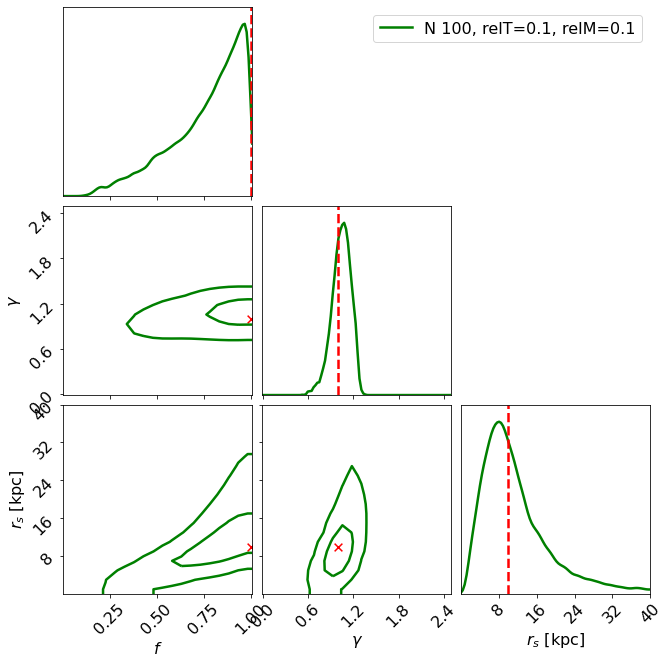

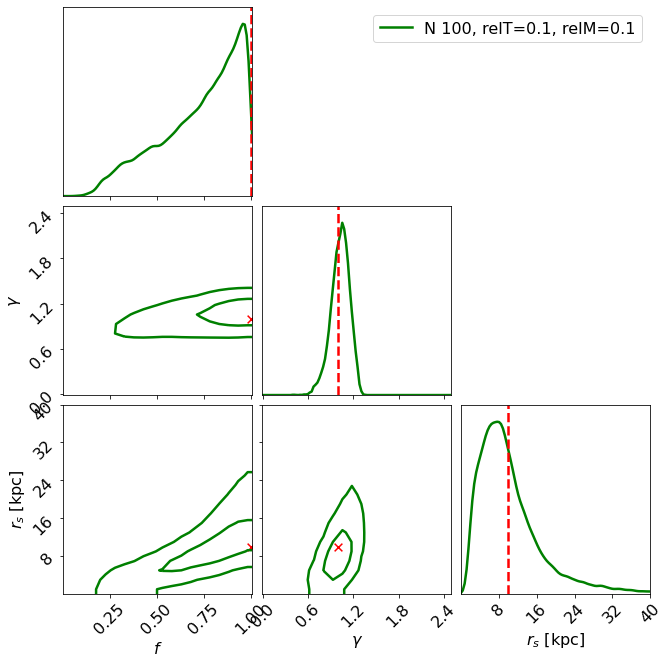

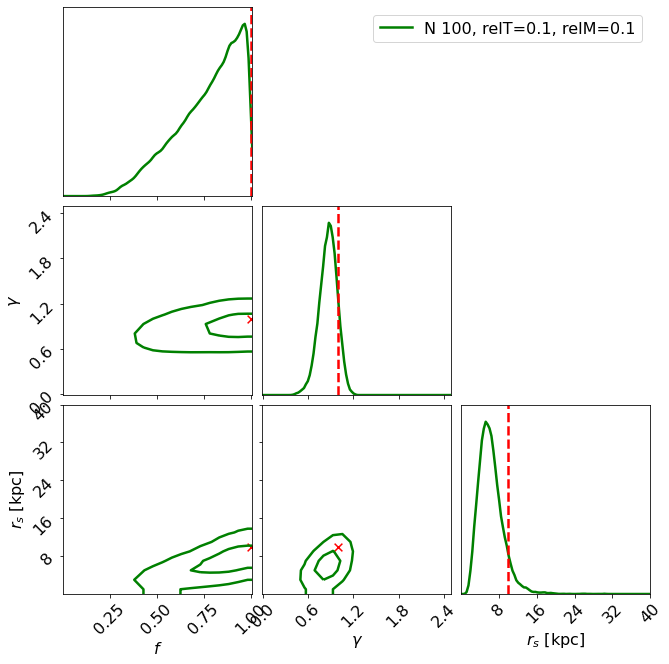

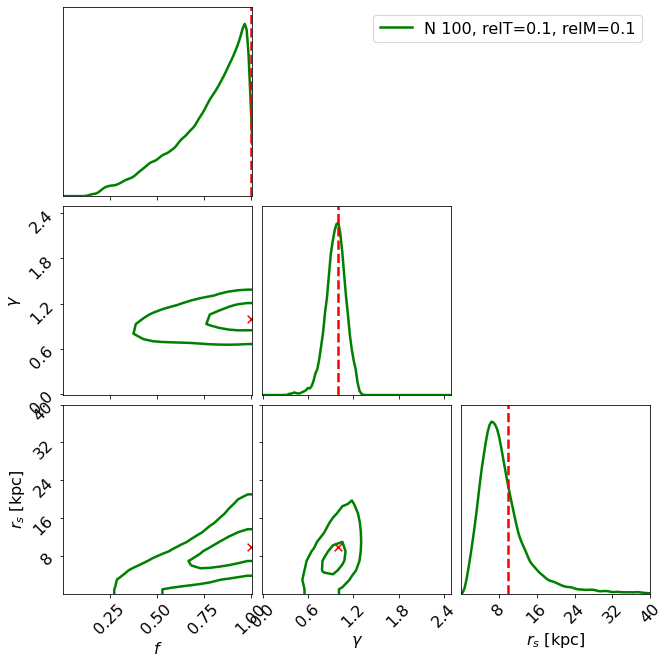

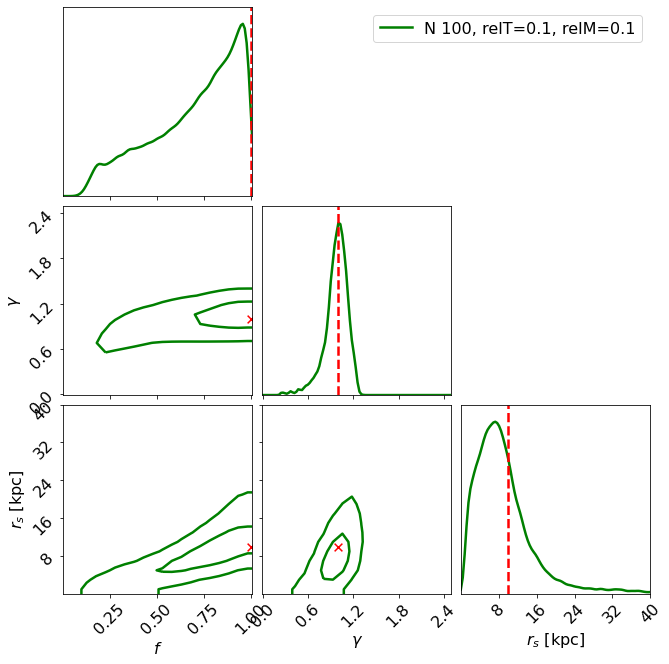

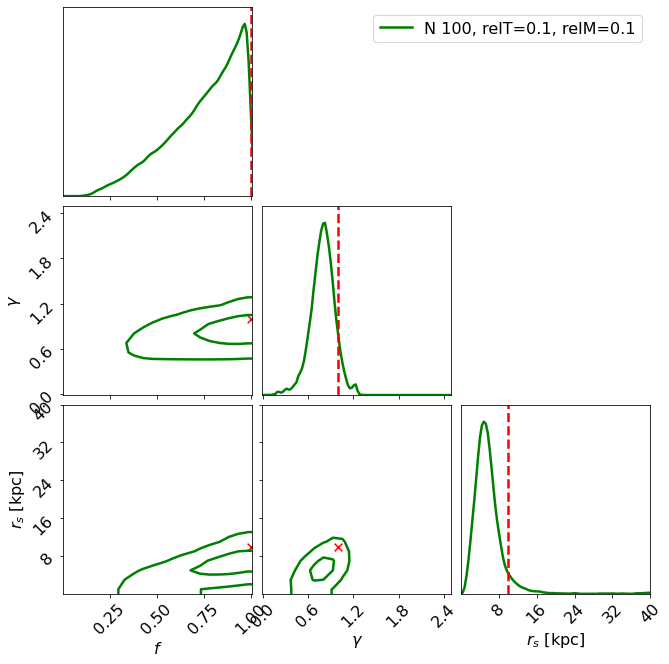

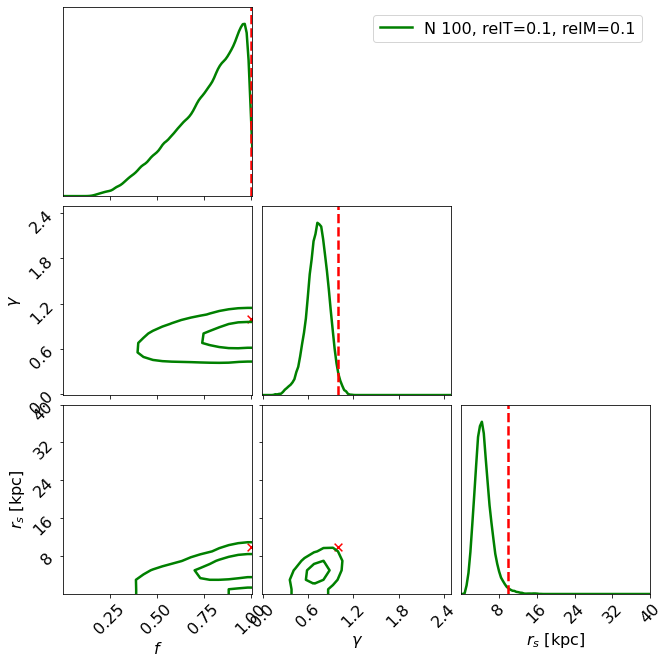

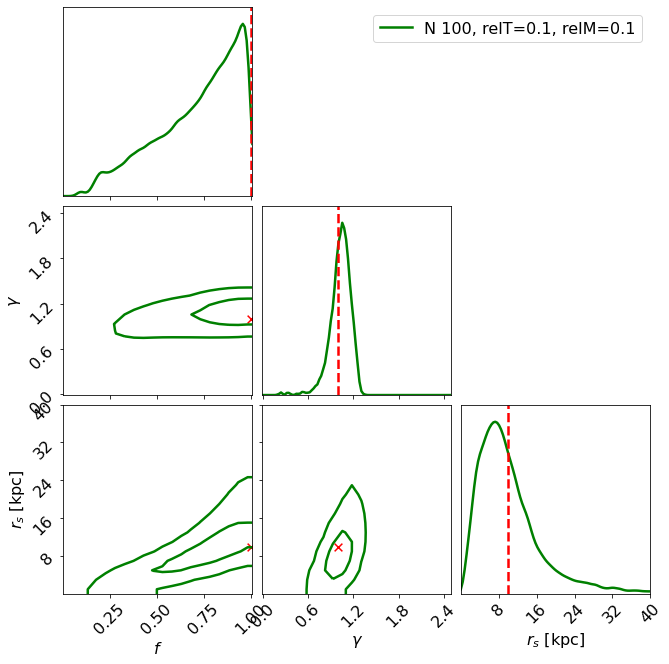

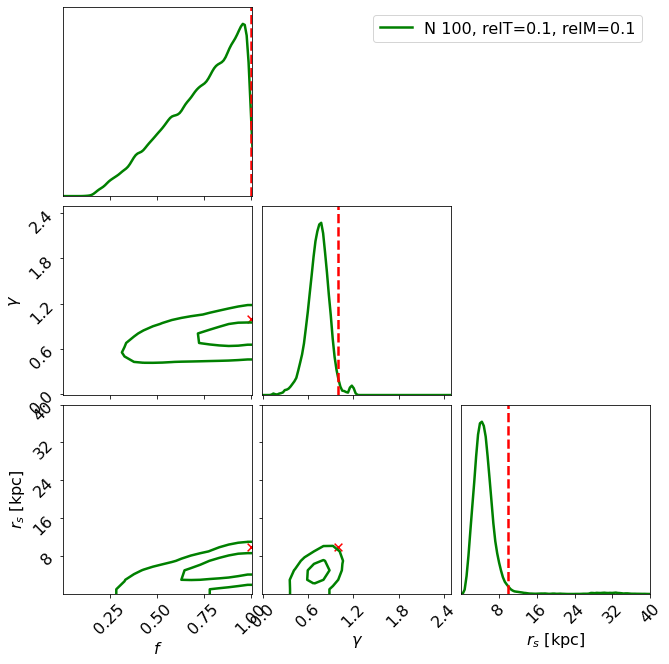

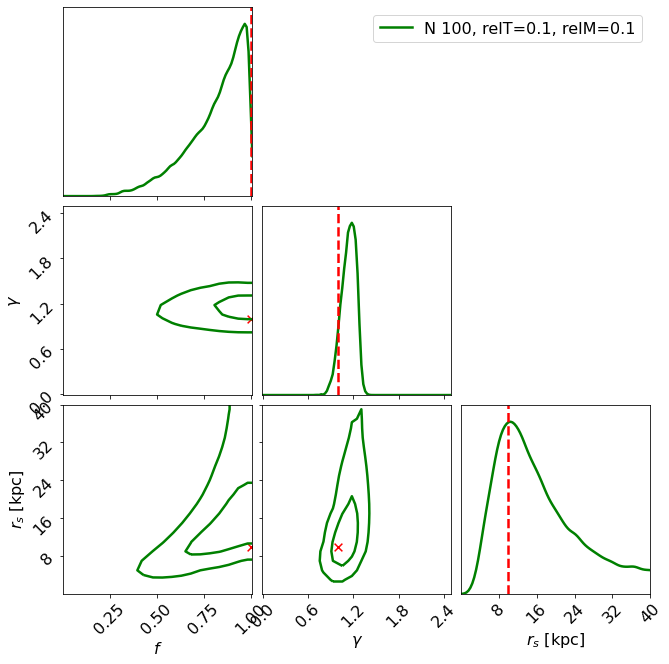

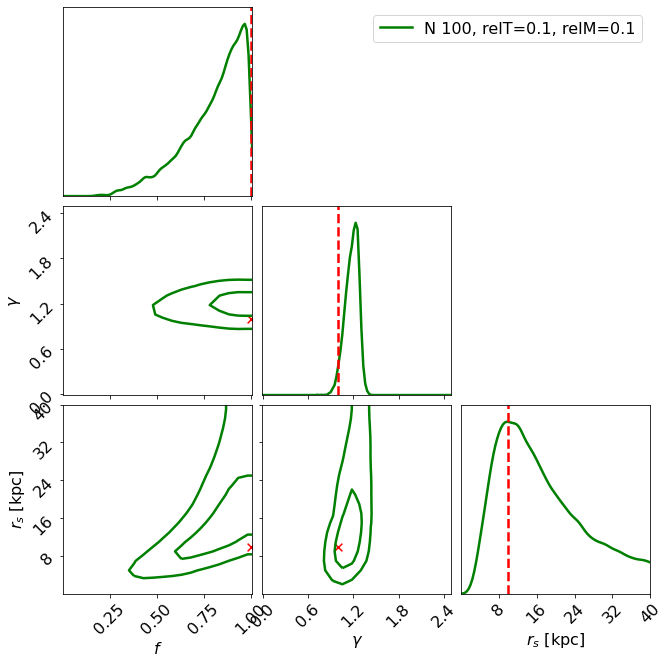

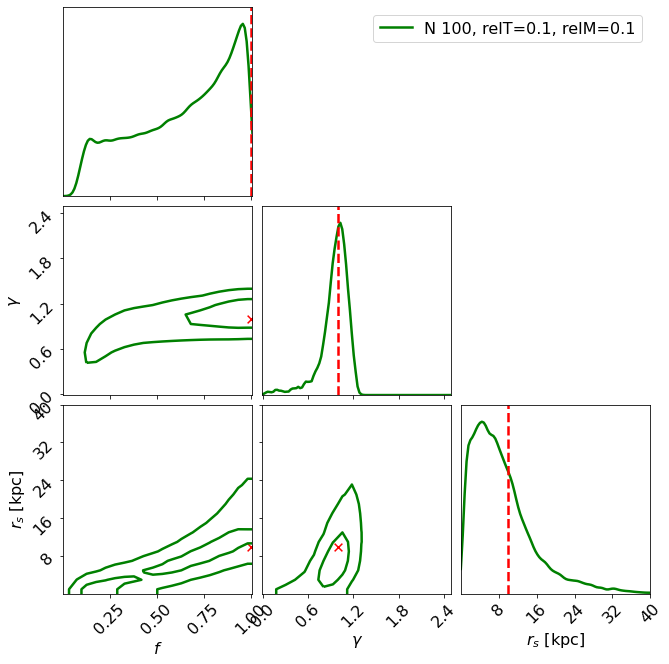

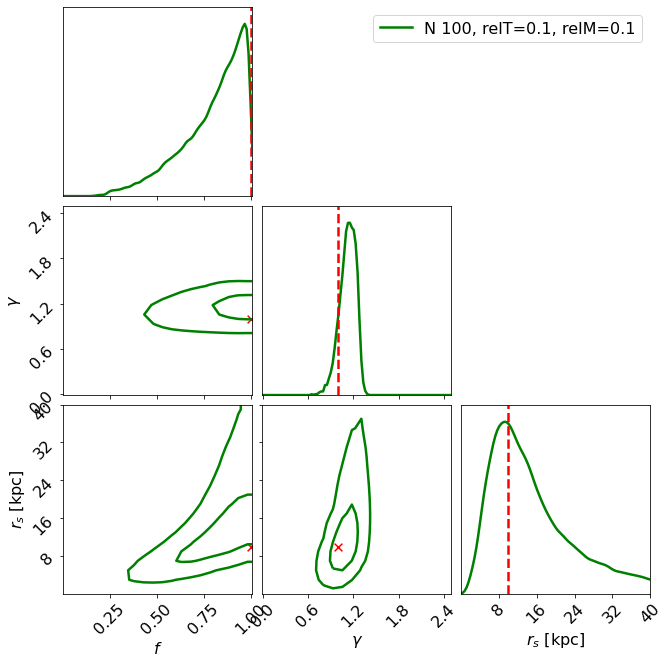

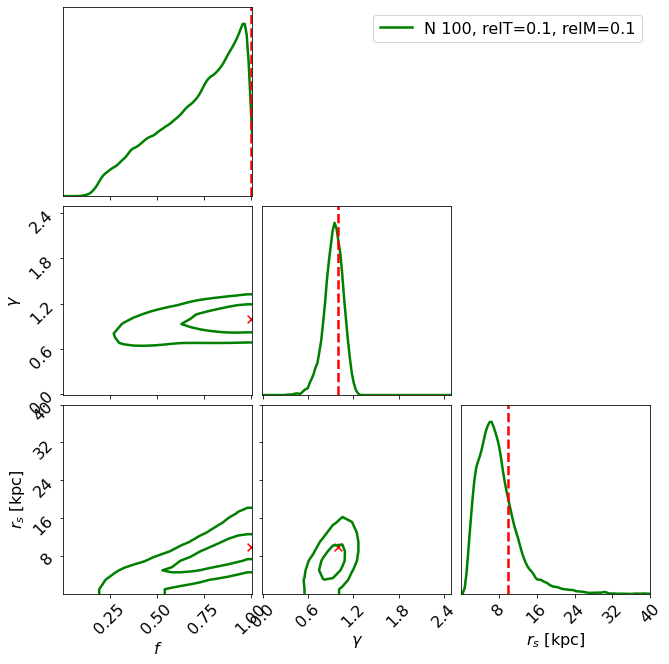

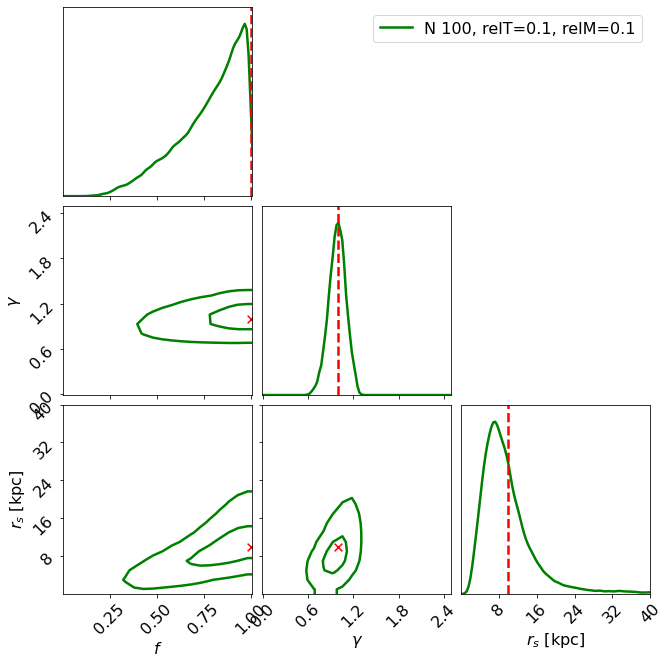

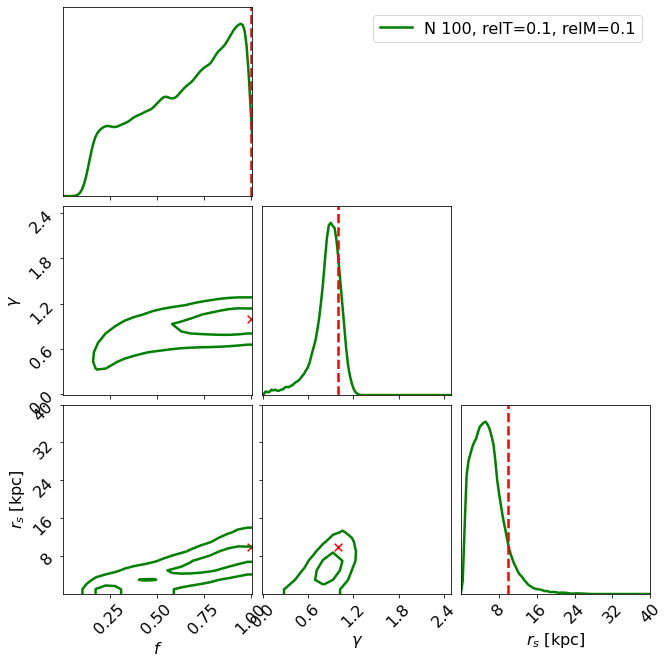

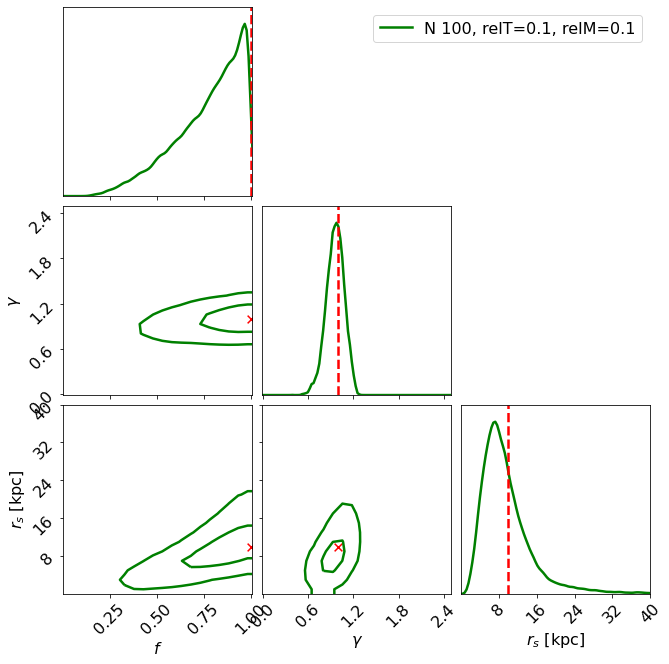

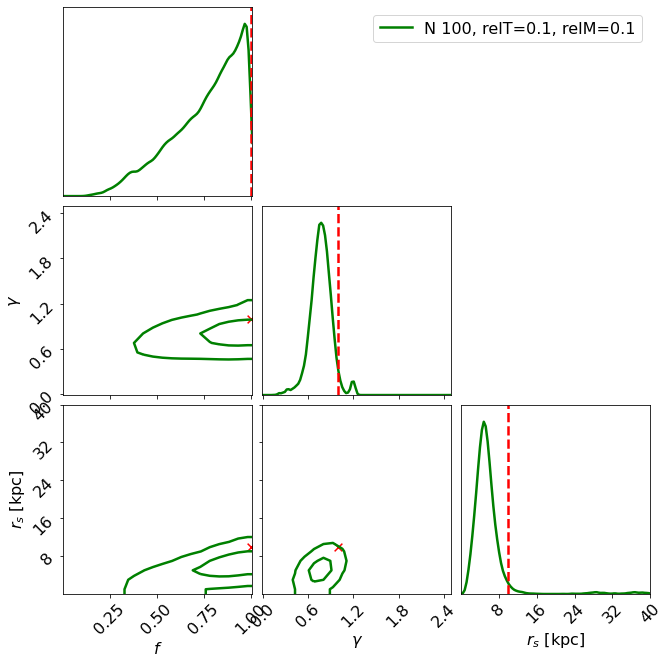

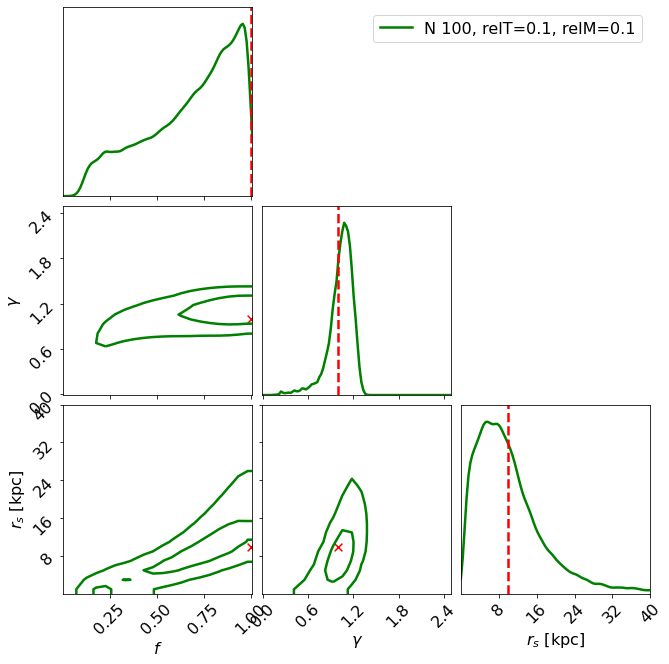

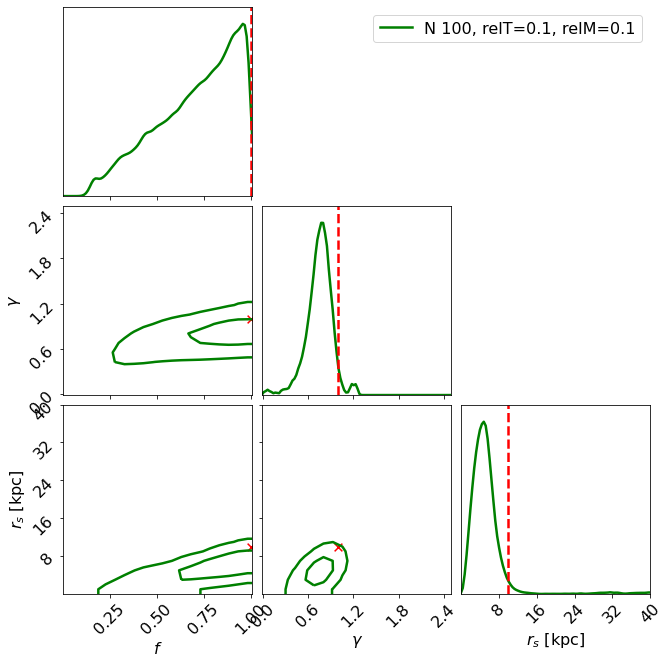

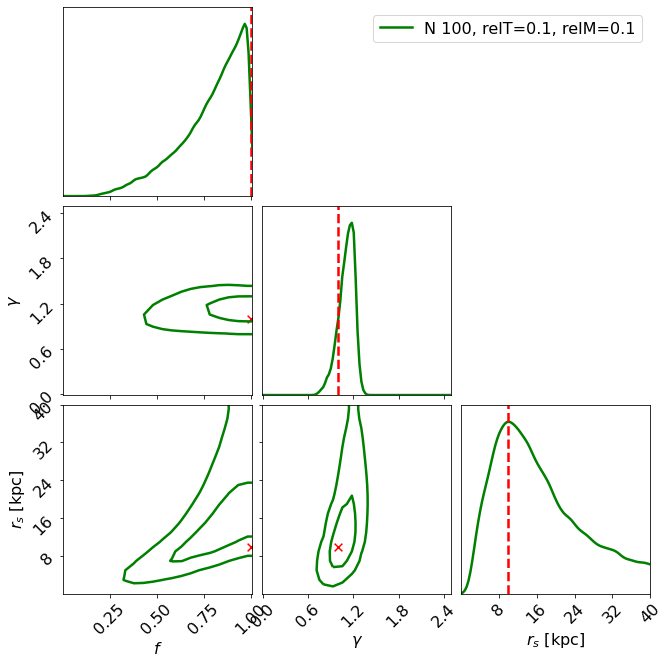

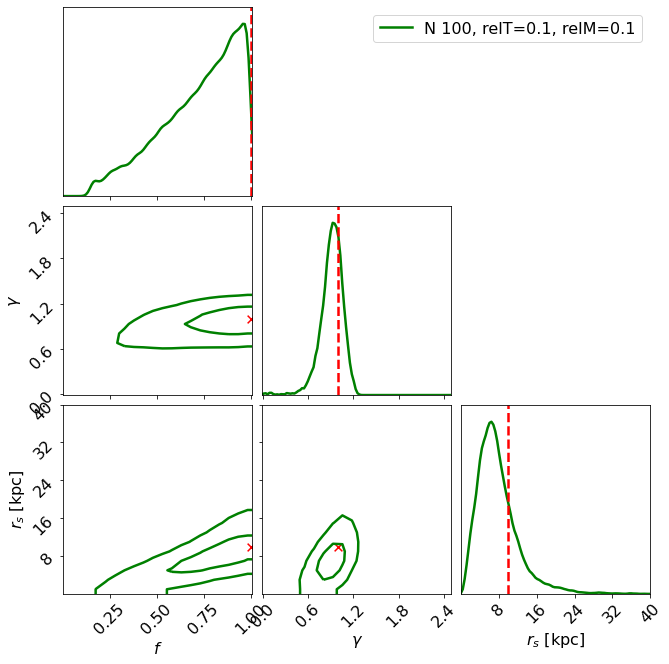

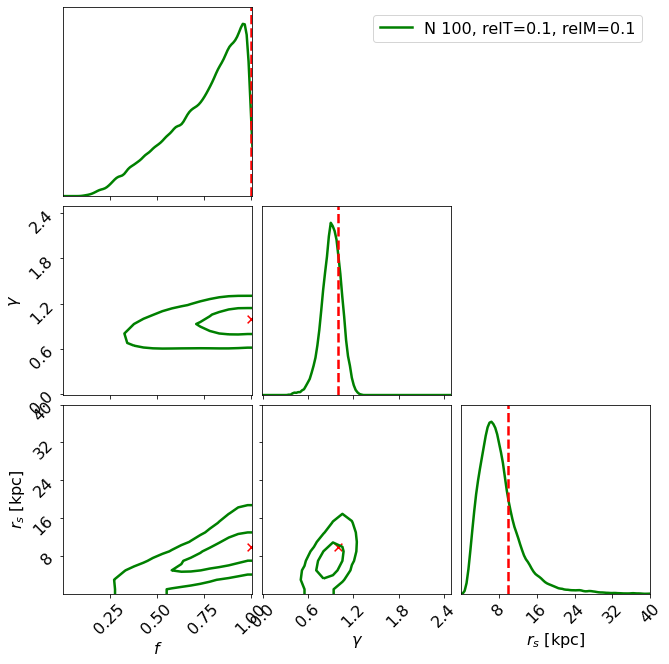

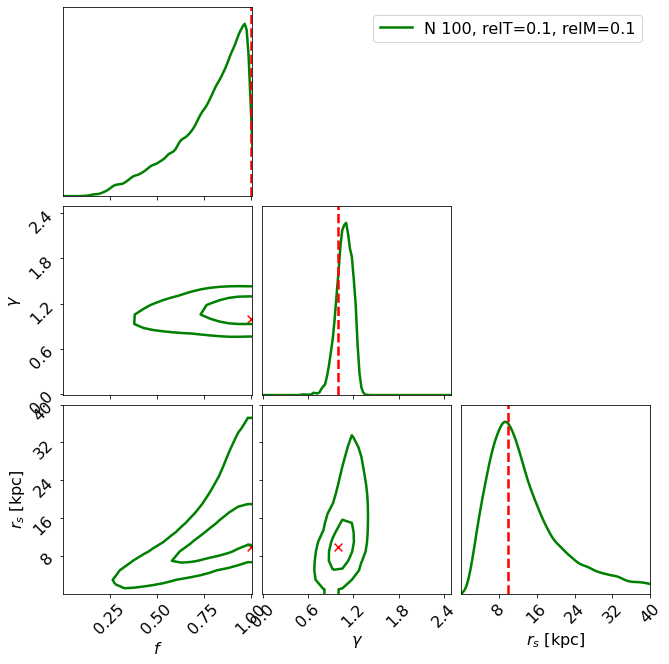

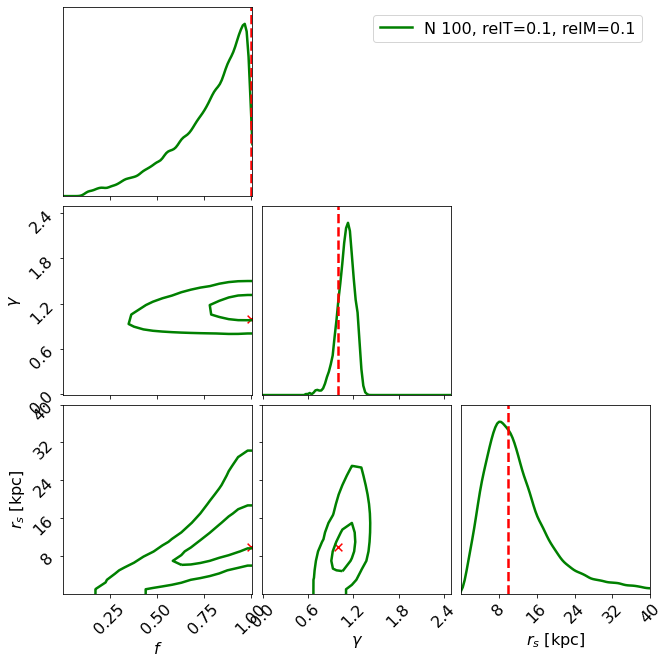

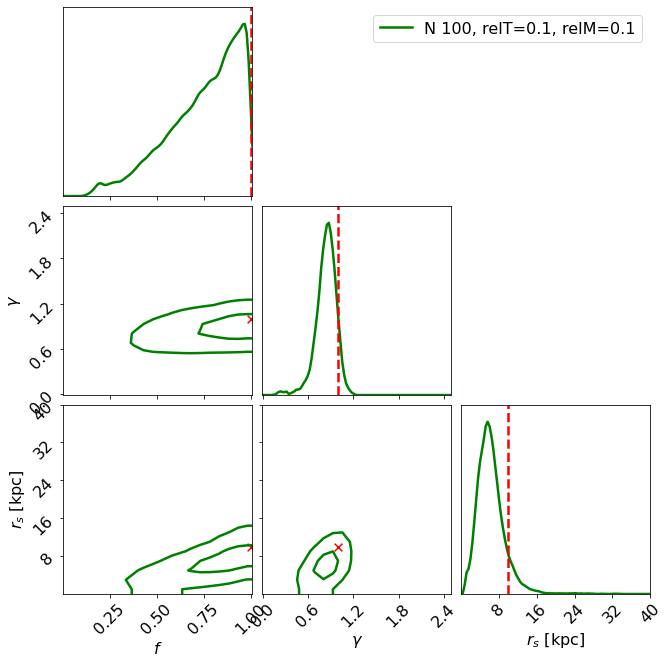

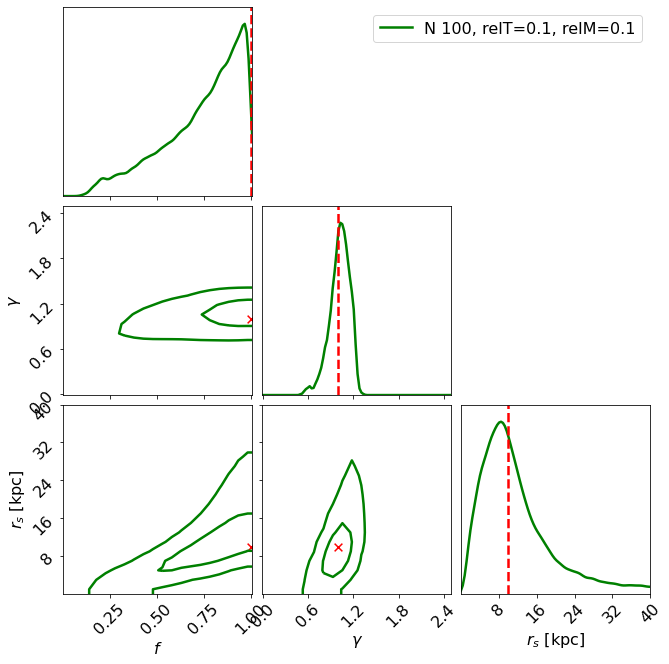

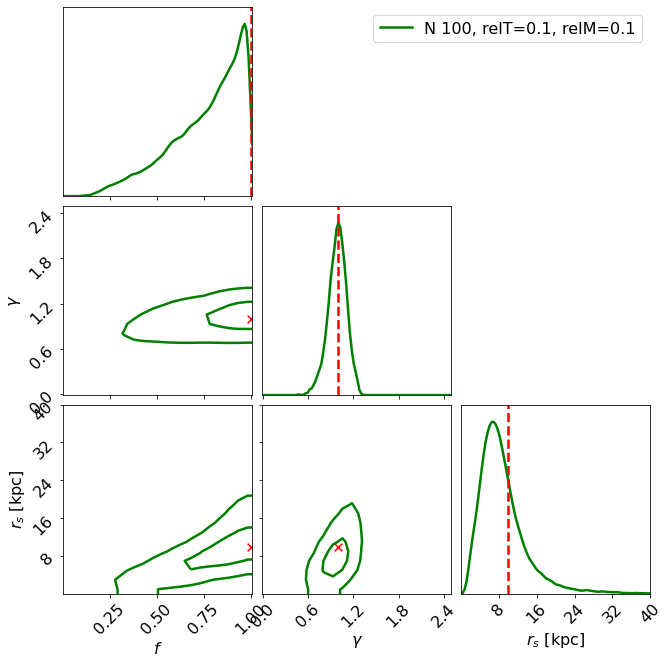

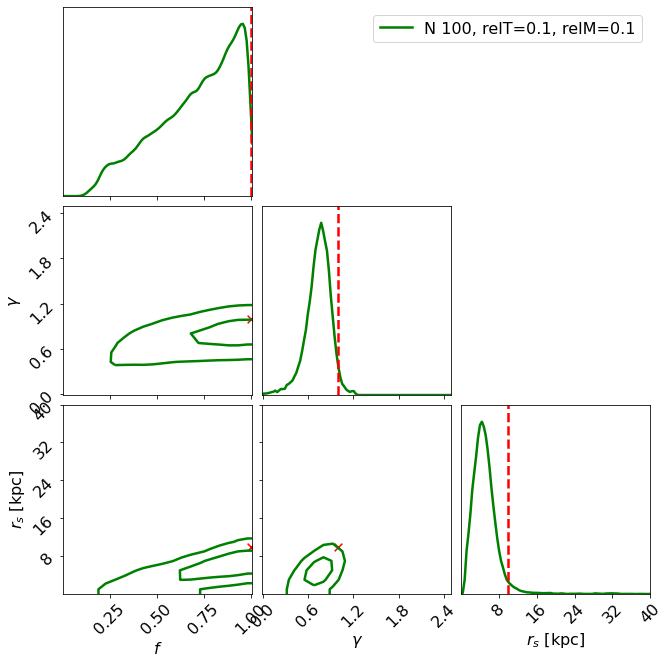

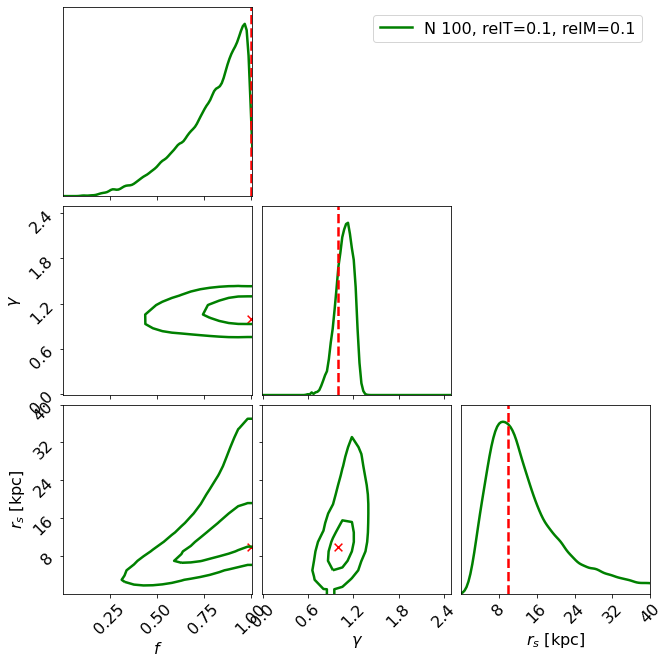

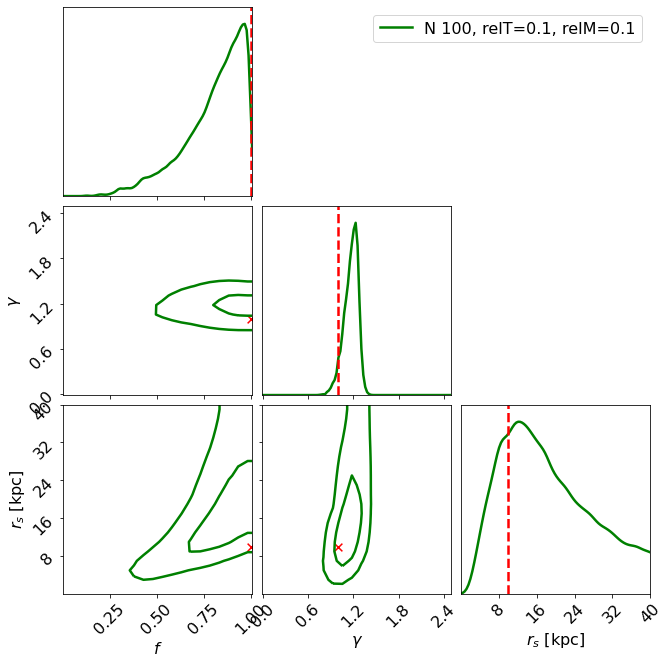

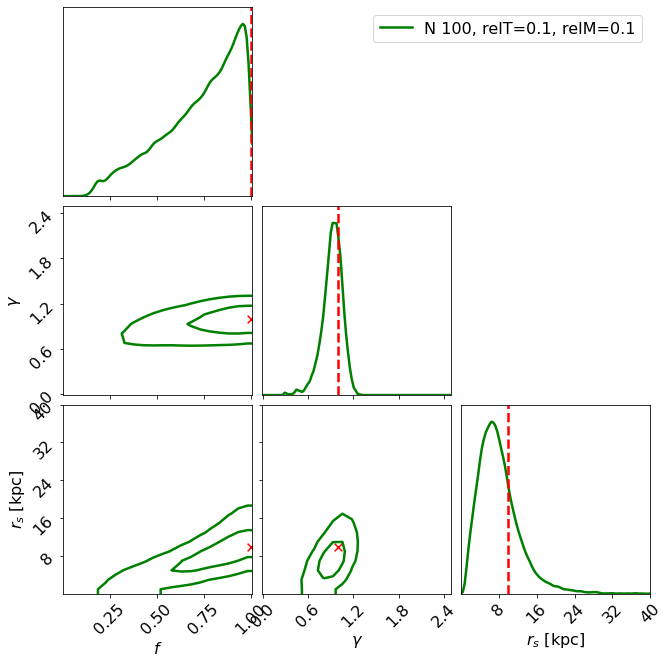

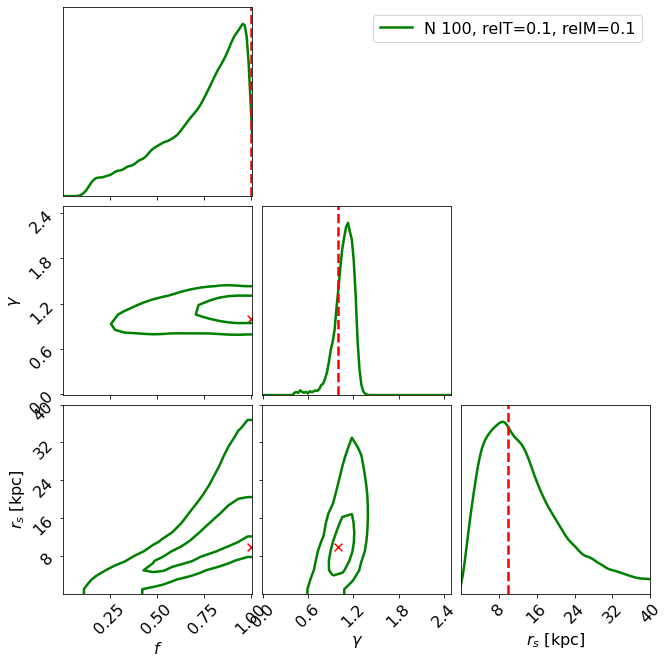

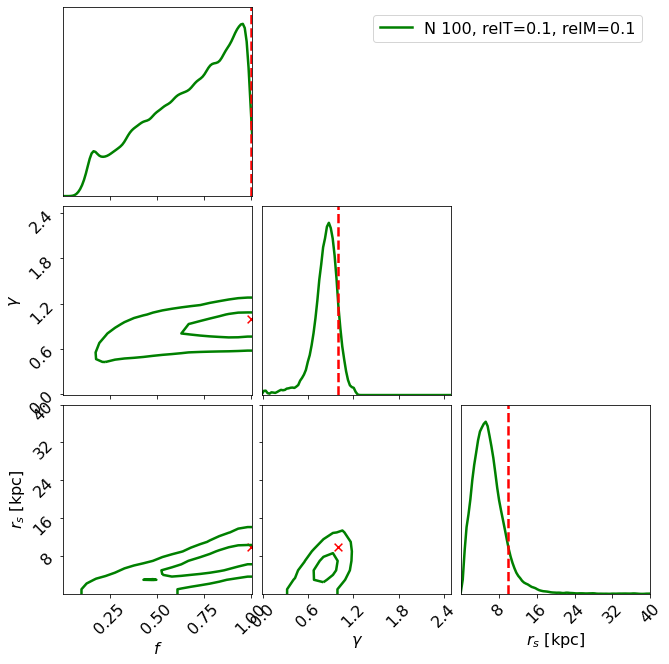

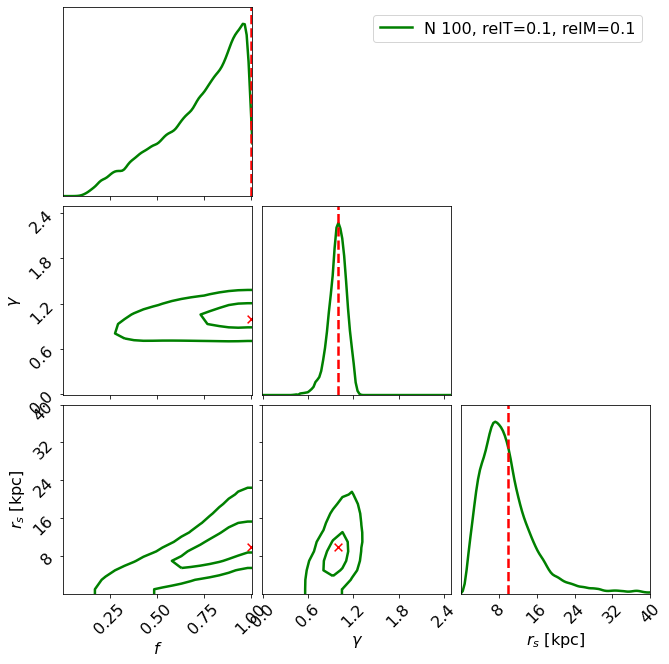

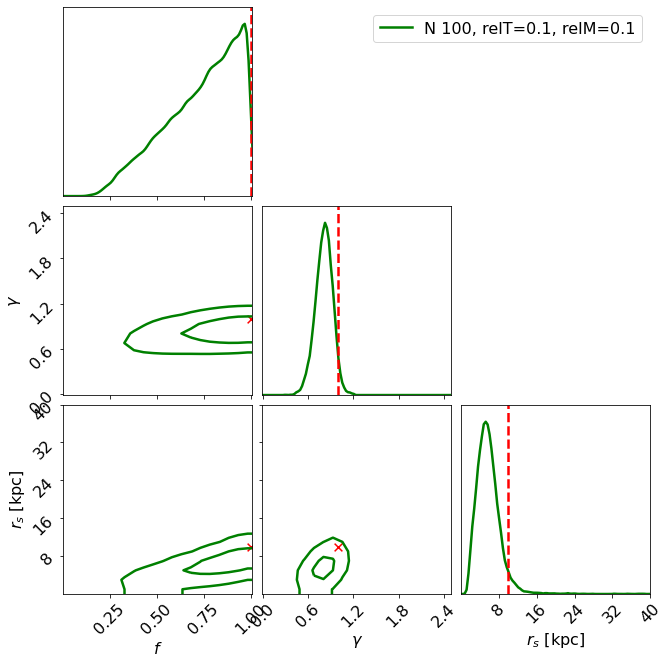

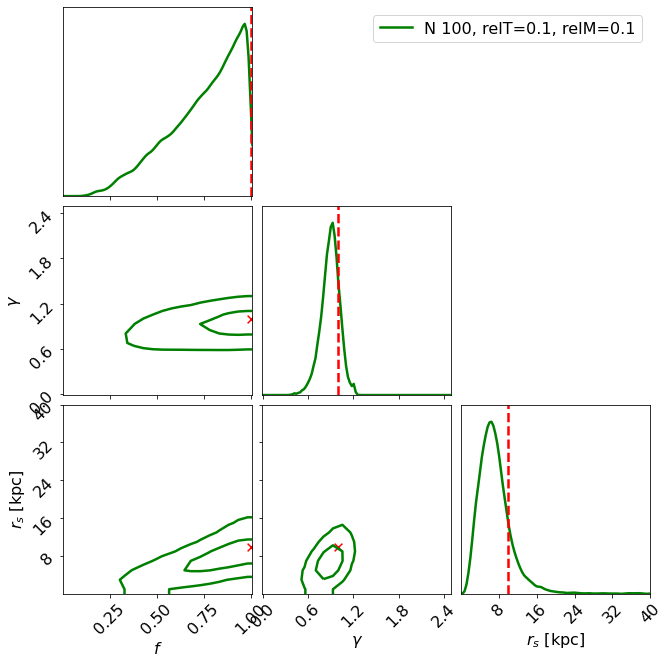

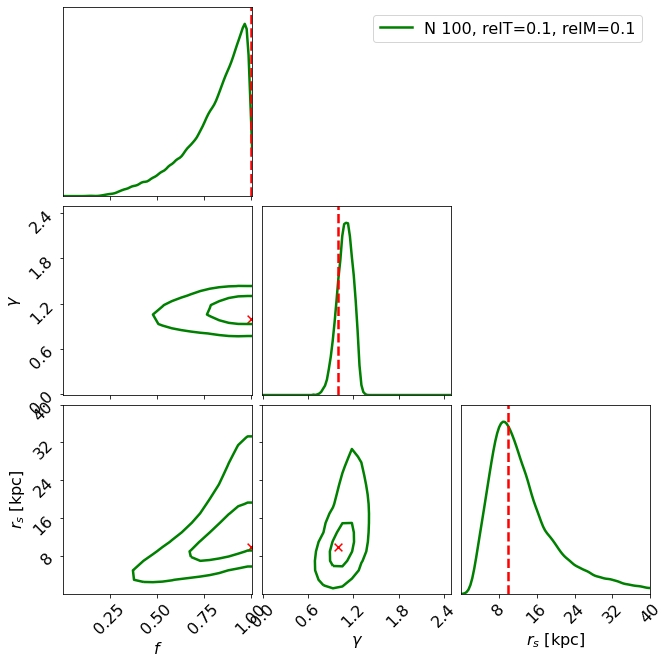

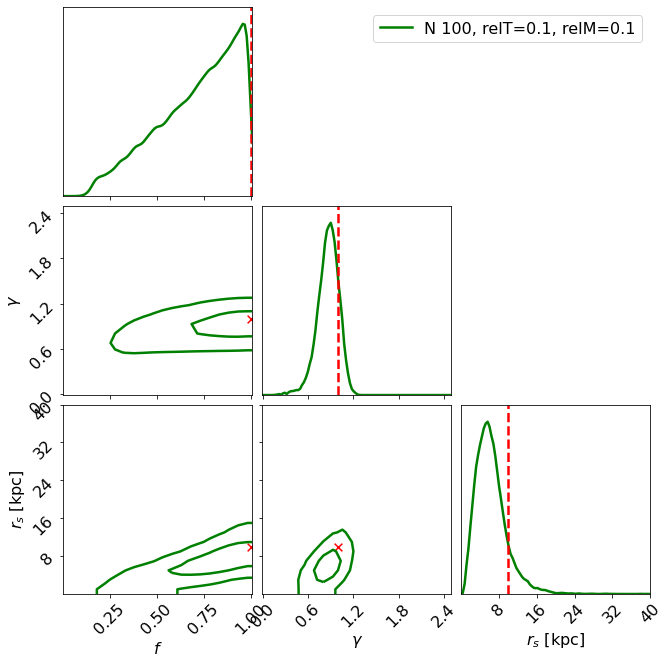

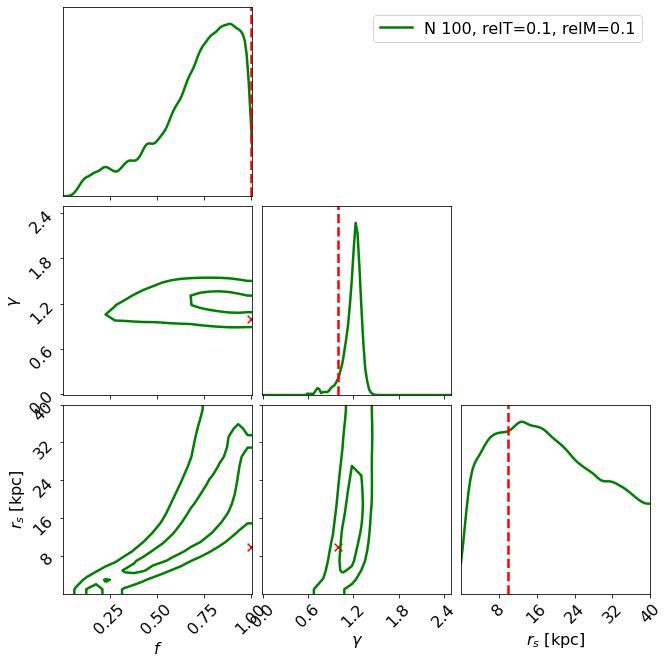

In [8]:
nBDs = 100; relT = 0.10; relM = 0.10
f = 1.; gamma = 1.; rs = 10.

for i in range(40):
    filepath = ("/hdfs/local/mariacst/exoplanets/results/final_round/all_unc/GC/N%irelT%.2frelM%.2f/" %(nBDs, relT, relM))
    _file    = open(filepath + 
                ("posterior_ex11_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv%i" 
                 %(nBDs, relT, relM, gamma, rs, i+1)), "rb") 
    samples  = pickle.load(_file)

    plot_corner(samples, nBDs, relT, relM, f, gamma, rs, i, smooth=1.)

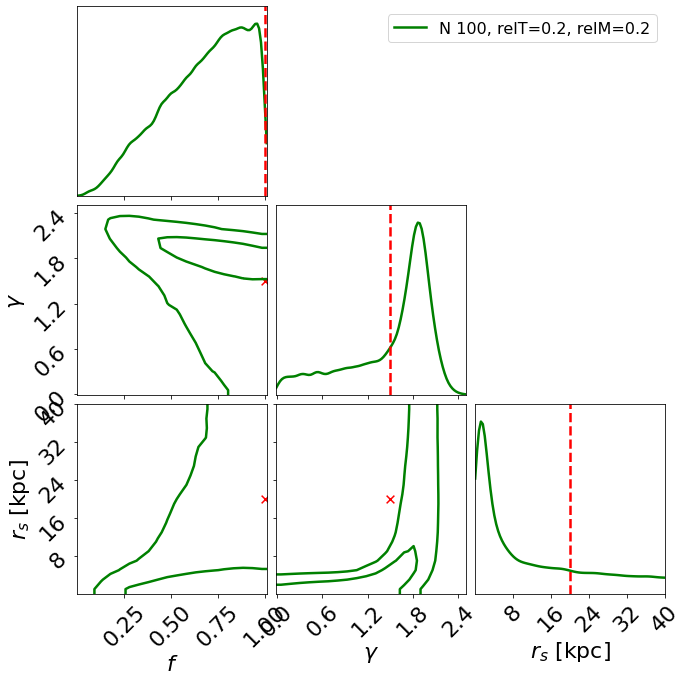

In [10]:
nBDs     = 100
relT     = 0.20
relM     = 0.20
f        = 1.
gamma    = 1.5
rs       = 20.
filepath = ("/hdfs/local/mariacst/exoplanets/results/final_round/Tmin/N%irelT%.2frelM%.2f/" %(nBDs, relT, relM))

_file    = open(filepath + 
                ("posterior_ex5_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="green",
                   range=[(0., 1.01), (-0.01, 2.5), (0., 40.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="green", lw=2.5)    

axes[0, 0].axvline(1., color="r", ls="--", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="--", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

colors = ['green']
lines = [Line2D([0], [0], color=c, linewidth=2.5, linestyle='-') for c in colors]
labels = ['N %i, relT=%.1f, relM=%.1f' %(nBDs, relT, relM)]
axes[0, 2].legend(lines, labels, fontsize=16)

#fig.savefig(("../../Figs/corner_ex5_N%irelT%.2frelM%.2f_g%.1frs%.1f.pdf" %(nBDs, relT, relM, gamma, rs)), 
#            bbox_inches="tight")

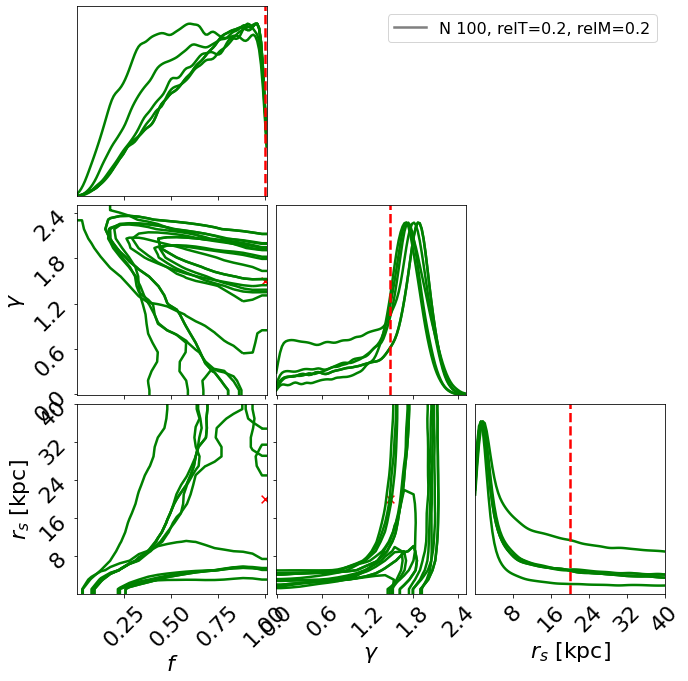

In [11]:
nBDs     = 100
relT     = 0.20
relM     = 0.20
f        = 1.
gamma    = 1.
rs       = 10.
filepath = ("/hdfs/local/mariacst/exoplanets/results/final_round/GC/N%irelT%.2frelM%.2f/" %(nBDs, relT, relM))

_file    = open(filepath + 
                ("posterior_ex4_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="green",
                   range=[(0., 1.01), (-0.01, 2.5), (0., 40.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="green", lw=2.5)    

    
for i in range(5):
    _file    = open(filepath + 
                ("posterior_ex5_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv%i" 
                 %(nBDs, relT, relM, gamma, rs, i+1)), "rb") 
    samples  = pickle.load(_file)
    smooth=1.
    corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                       plot_density=False, fill_contours=False, smooth=smooth, color="green",
                       range=[(0., 1.01), (-0.01, 2.5), (0., 40.)], fig=fig)
    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 4, 8], samples.T):
        kde   = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="green", lw=2.5)  

axes[0, 0].axvline(1., color="r", ls="--", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="--", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

colors = ['grey']
lines = [Line2D([0], [0], color=c, linewidth=2.5, linestyle='-') for c in colors]
labels = ['N %i, relT=%.1f, relM=%.1f' %(nBDs, relT, relM)]
axes[0, 2].legend(lines, labels, fontsize=16)

fig.savefig(("../../Figs/corner_ex5_N%irelT%.2frelM%.2f_g%.1frs%.1f.pdf" %(nBDs, relT, relM, gamma, rs)), 
            bbox_inches="tight")

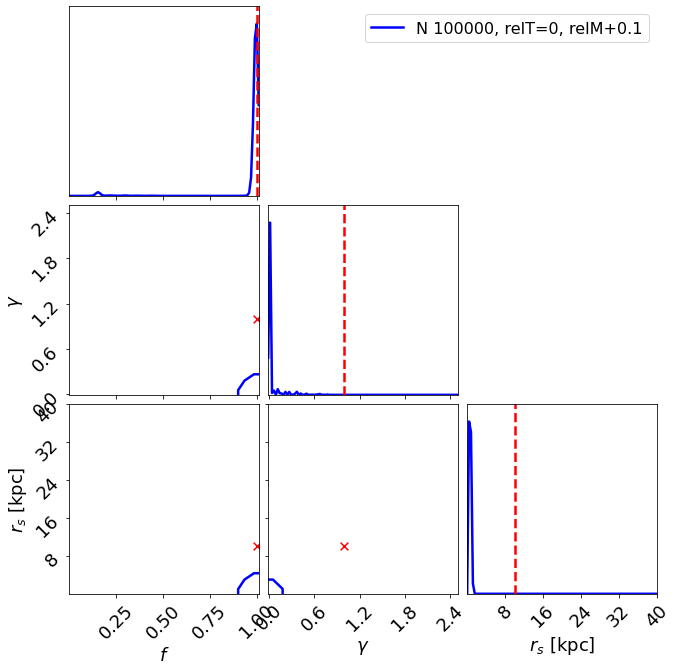

In [27]:
nBDs     = 100000
relT     = 0.10
relM     = 0.10
f        = 1.
gamma    = 1.
rs       = 10.
filepath = ("/hdfs/local/mariacst/exoplanets/results/final_round/Tmin/N%irelT%.2frelM%.2f/" %(nBDs, relT, relM))

_file    = open(filepath + 
                ("posterior_ex5_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="blue",
                   range=[(0., 1.01), (-0.01, 2.5), (0., 40.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="blue", lw=2.5)    

axes[0, 0].axvline(1., color="r", ls="--", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="--", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

colors = ['blue']
lines = [Line2D([0], [0], color=c, linewidth=2.5, linestyle='-') for c in colors]
labels = ['N %i, relT=%.1f, relM=%.1f' %(nBDs, relT, relM)]
axes[0, 2].legend(lines, labels, fontsize=16)

fig.savefig(("../../Figs/corner_ex5_N%irelT%.2frelM%.2f_g%.1frs%.1f.pdf" %(nBDs, relT, relM, gamma, rs)), 
            bbox_inches="tight")

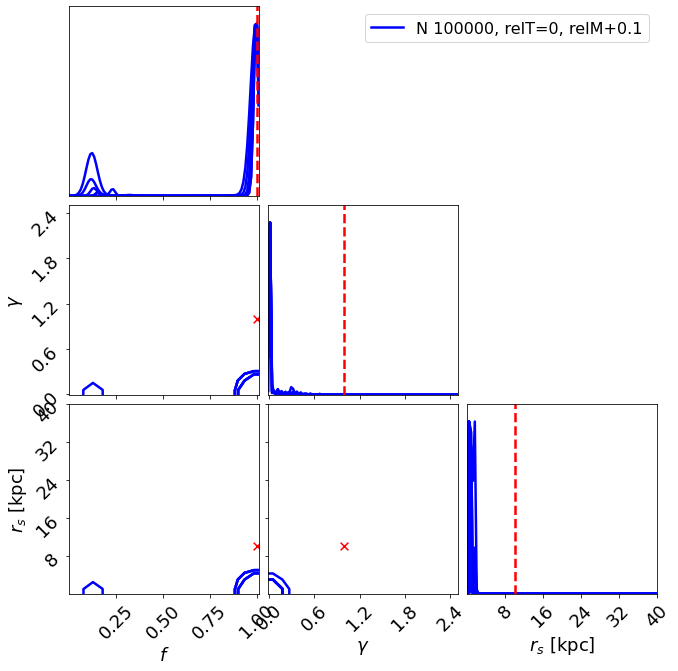

In [28]:
nBDs     = 100000
relT     = 0.10
relM     = 0.10
f        = 1.
gamma    = 1.
rs       = 10.
filepath = ("/hdfs/local/mariacst/exoplanets/results/final_round/Tmin/N%irelT%.2frelM%.2f/" %(nBDs, relT, relM))

_file    = open(filepath + 
                ("posterior_ex5_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv1" 
                 %(nBDs, relT, relM, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="blue",
                   range=[(0., 1.01), (-0.01, 2.5), (0., 40.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="blue", lw=2.5)    

    
for i in range(5):
    _file    = open(filepath + 
                ("posterior_ex5_N%i_relunc%.2f_relM%.2f_f1.0gamma%.1frs%.1fv%i" 
                 %(nBDs, relT, relM, gamma, rs, i+1)), "rb") 
    samples  = pickle.load(_file)
    smooth=1.
    corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                       plot_density=False, fill_contours=False, smooth=smooth, color="blue",
                       range=[(0., 1.01), (-0.01, 2.5), (0., 40.)], fig=fig)
    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 4, 8], samples.T):
        kde   = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="blue", lw=2.5)  

axes[0, 0].axvline(1., color="r", ls="--", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="--", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

colors = ['blue']
lines = [Line2D([0], [0], color=c, linewidth=2.5, linestyle='-') for c in colors]
labels = ['N %i, relT=%.1f, relM=%.1f' %(nBDs, relT, relM)]
axes[0, 2].legend(lines, labels, fontsize=16)

## Modify spatial sampling

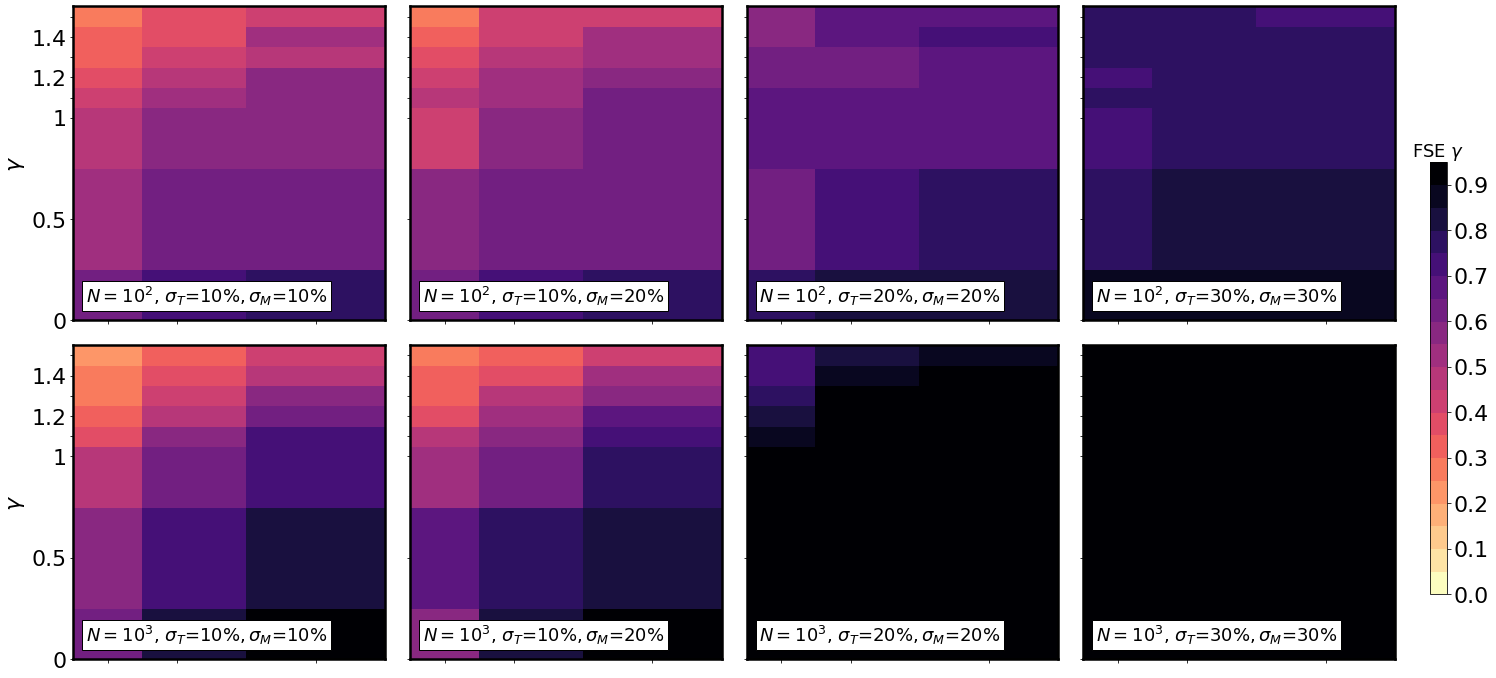

In [5]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12))

path = "/home/mariacst/exoplanets/results/tests/ex8/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex8", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex8", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex8", ax[0, 2], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex8", ax[0, 3], "median", True, False, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex8", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex8", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex8", ax[1, 2], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex8", ax[1, 3], "median", True, False, False, False)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("/home/mariacst/exoplanets/Figs/FSE_f_ex8.pdf", bbox_inches="tight")

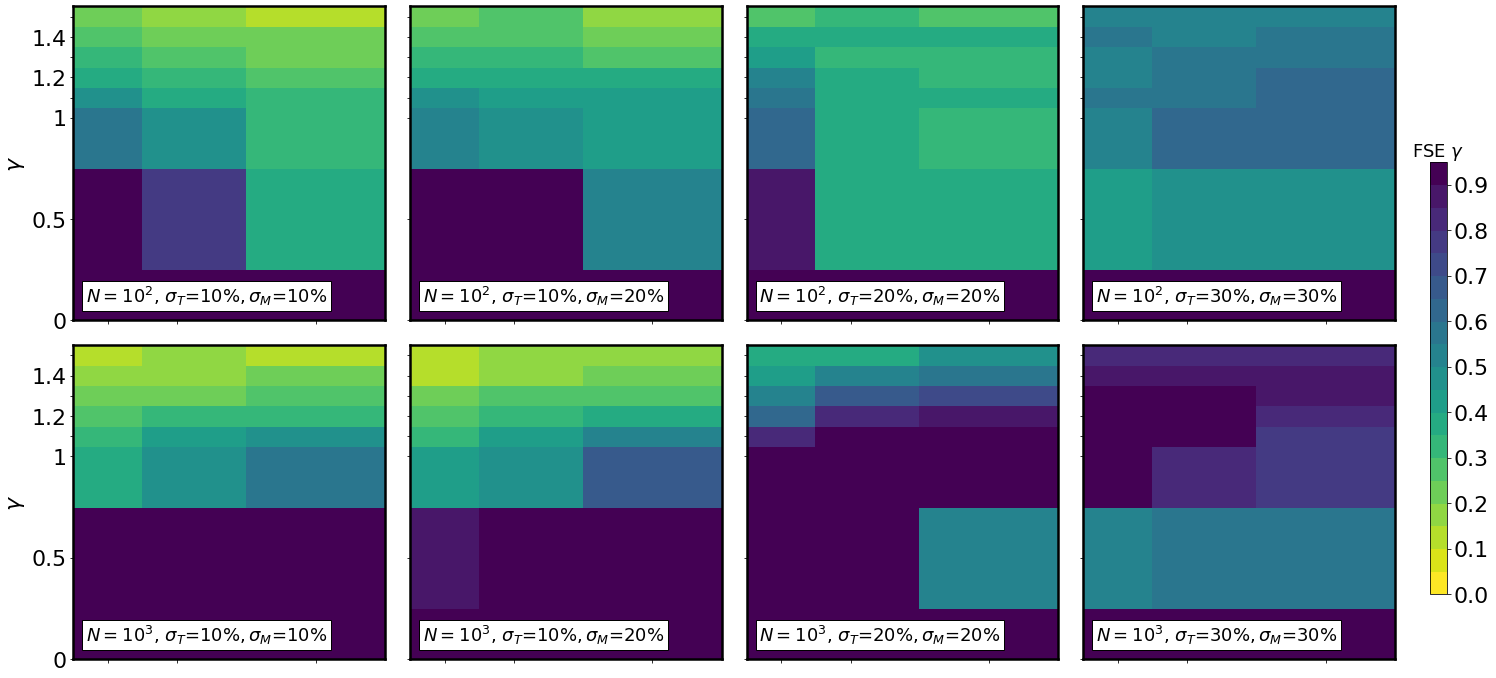

In [3]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12))

path = "/home/mariacst/exoplanets/results/tests/ex8/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex8", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex8", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex8", ax[0, 2], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex8", ax[0, 3], "median", False, True, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex8", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex8", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex8", ax[1, 2], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex8", ax[1, 3], "median", False, True, False, False)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("/home/mariacst/exoplanets/Figs/FSE_gamma_ex8.pdf", bbox_inches="tight")

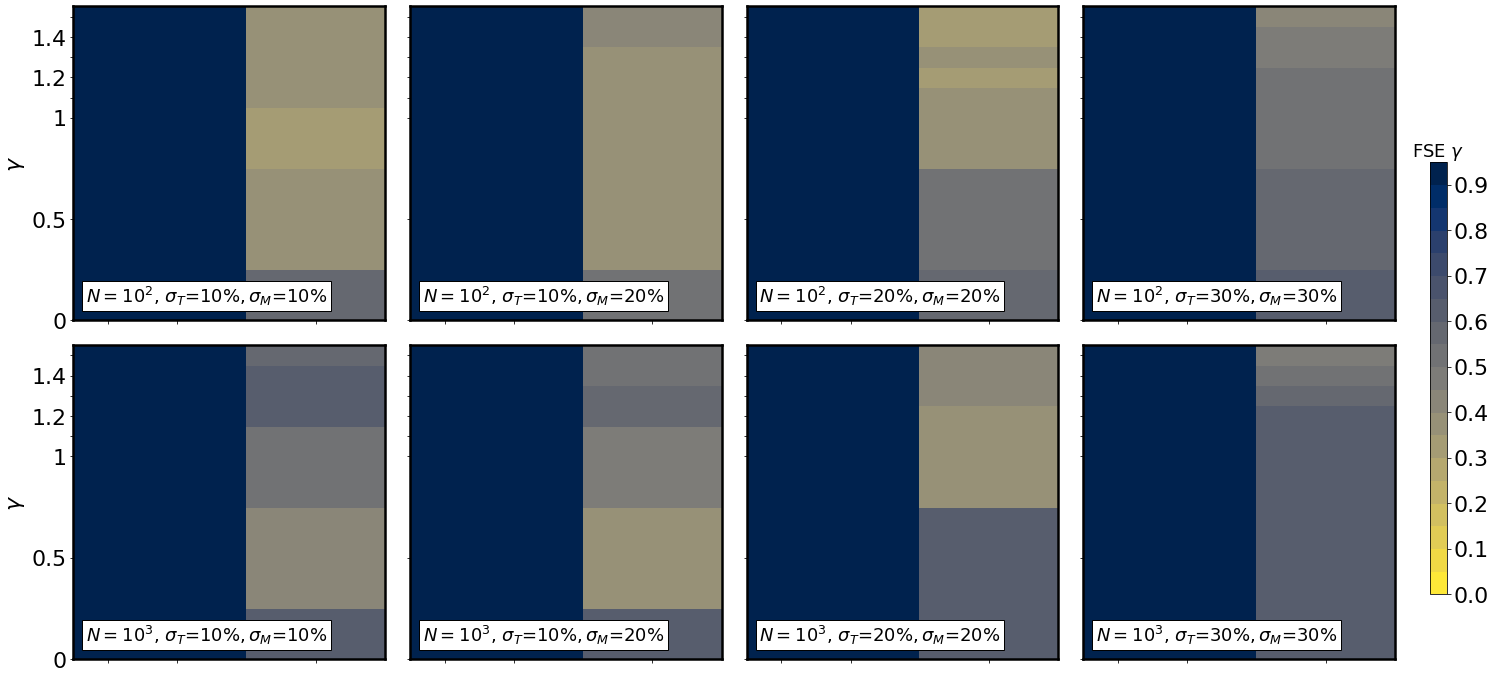

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12))

path = "/home/mariacst/exoplanets/results/tests/ex8/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex8", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex8", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex8", ax[0, 2], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex8", ax[0, 3], "median", False, False, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex8", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex8", ax[1, 1], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex8", ax[1, 2], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex8", ax[1, 3], "median", False, False, False, False)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("/home/mariacst/exoplanets/Figs/FSE_rs_ex8.pdf", bbox_inches="tight")

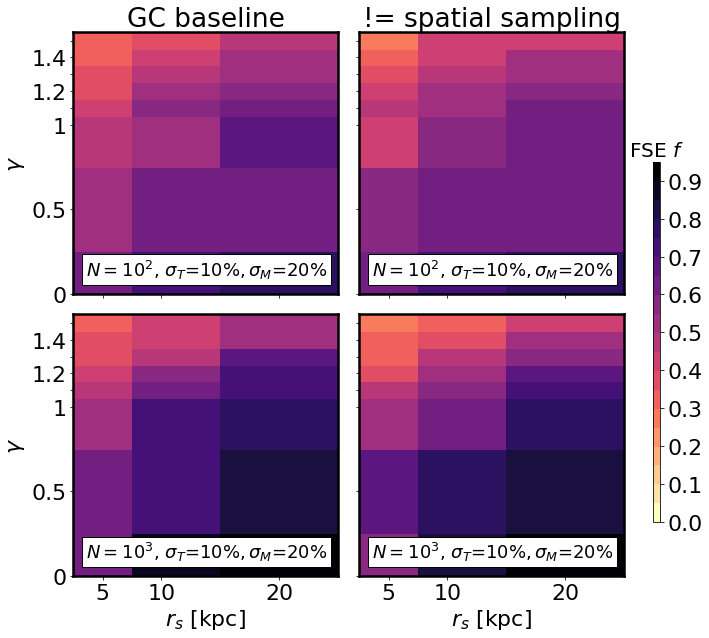

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

relT = 0.1; relM = 0.2

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("!= spatial sampling")

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", True, False, True, True)


path = "/home/mariacst/exoplanets/results/tests/ex8/"
im   = grid_FSE(path, 100, relT, relM, "ex8", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE(path, 1000, relT, relM, "ex8", ax[1, 1], "median", True, False, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $f$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

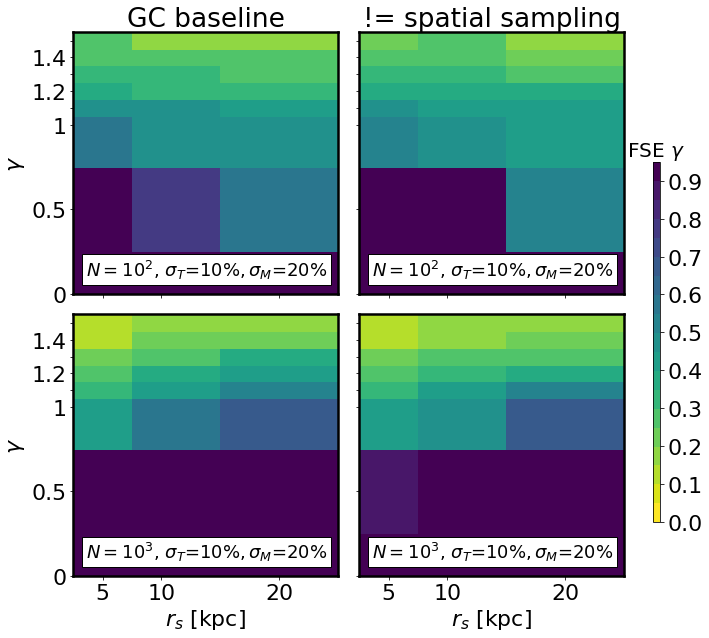

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("!= spatial sampling")

relT =0.1; relM = 0.2

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", False, True, True, True)

path = "/home/mariacst/exoplanets/results/tests/ex8/"
im   = grid_FSE(path, 100, relT, relM, "ex8", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 1000, relT, relM, "ex8", ax[1, 1], "median", False, True, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

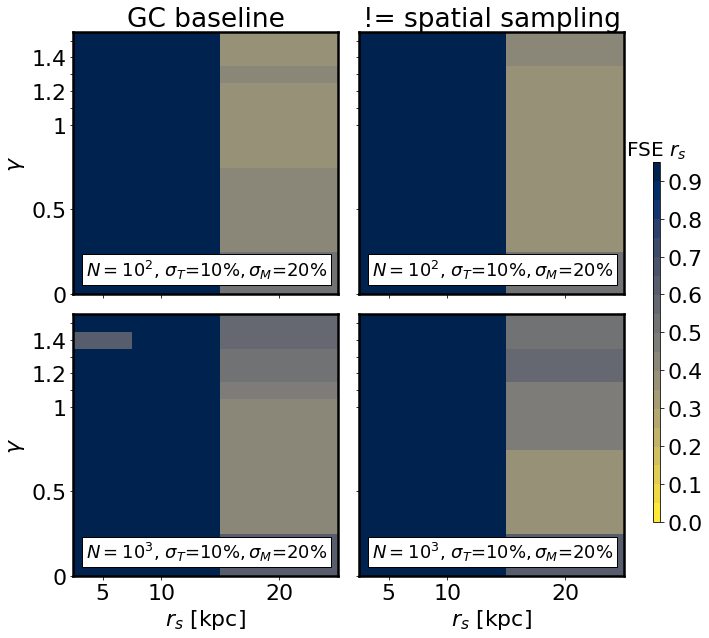

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("!= spatial sampling")

relT = 0.1; relM = 0.2

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", False, False, True, True)


path = "/home/mariacst/exoplanets/results/tests/ex8/"
im   = grid_FSE(path, 100, relT, relM, "ex8", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE(path, 1000, relT, relM, "ex8", ax[1, 1], "median", False, False, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("/home/mariacst/exoplanets/Figs/FSE_rs_compasion_test_sampling.pdf", bbox_inches="tight")

## Adopt older stellar population in bulge

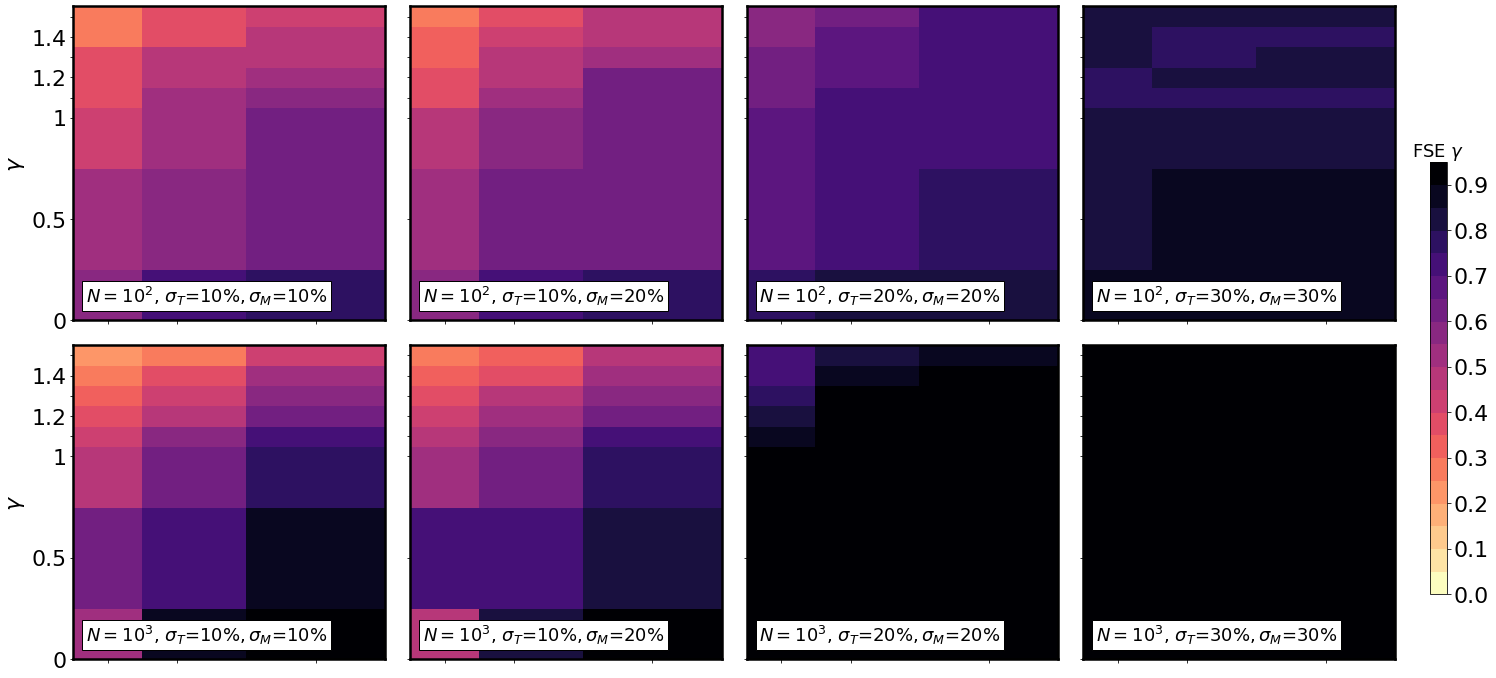

In [11]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12))

path = "/home/mariacst/exoplanets/results/tests/ex9/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex9", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex9", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex9", ax[0, 2], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex9", ax[0, 3], "median", True, False, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex9", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex9", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex9", ax[1, 2], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex9", ax[1, 3], "median", True, False, False, False)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

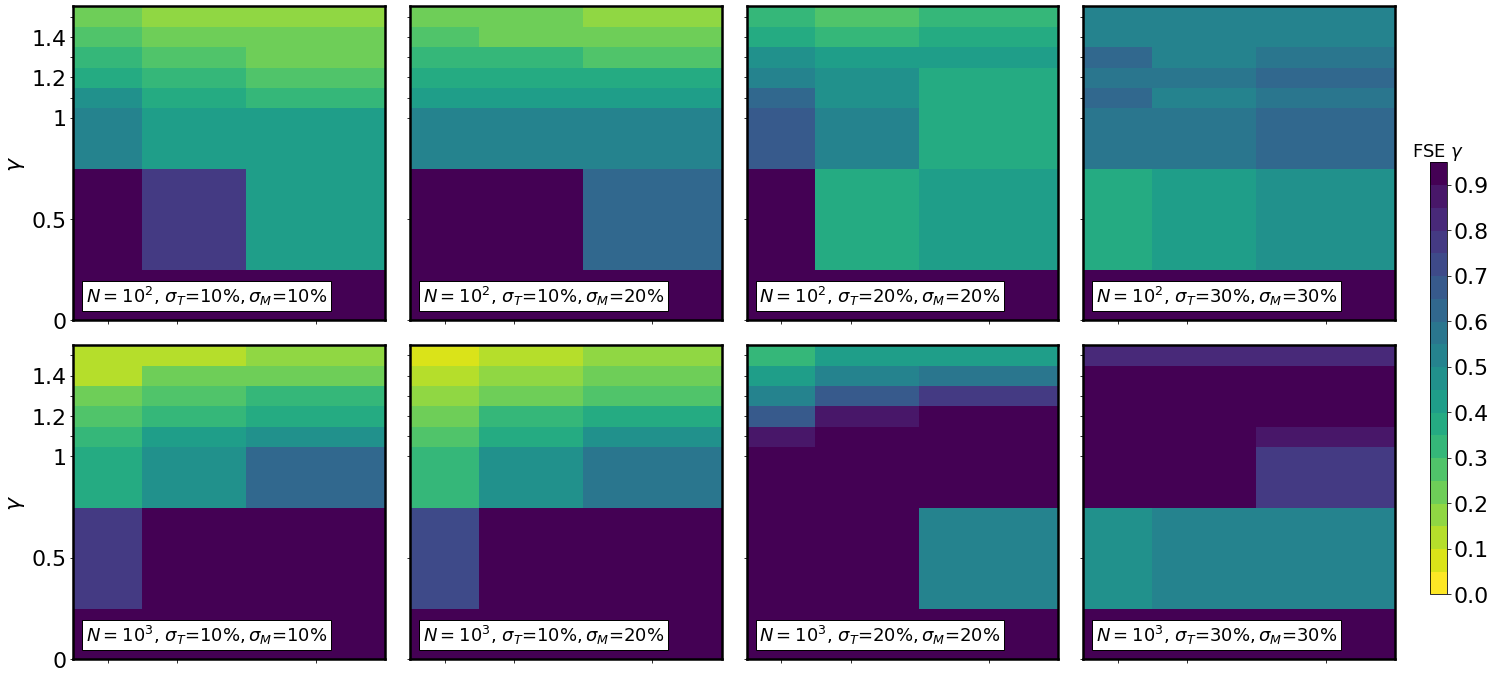

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12))

path = "/home/mariacst/exoplanets/results/tests/ex9/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex9", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex9", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex9", ax[0, 2], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex9", ax[0, 3], "median", False, True, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex9", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex9", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex9", ax[1, 2], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex9", ax[1, 3], "median", False, True, False, False)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

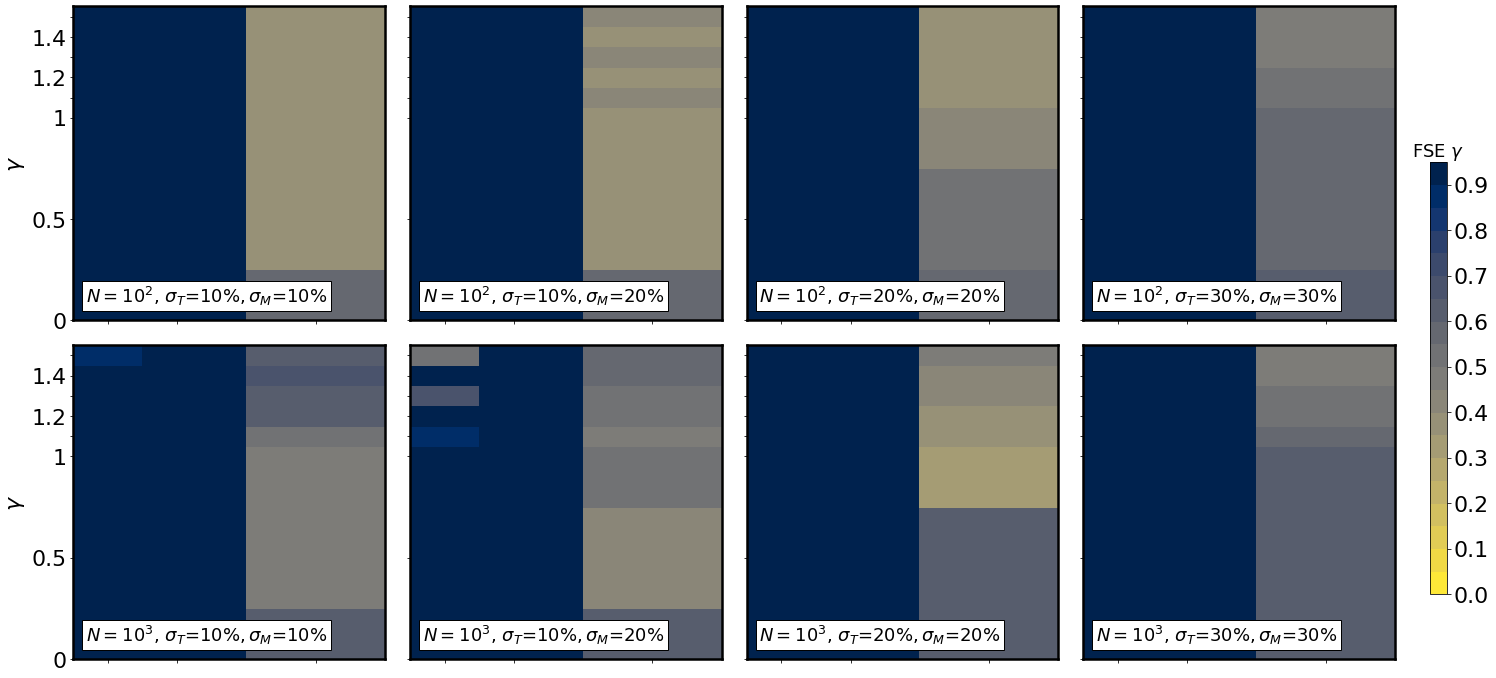

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12))

path = "/home/mariacst/exoplanets/results/tests/ex9/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex9", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex9", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex9", ax[0, 2], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex9", ax[0, 3], "median", False, False, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex9", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex9", ax[1, 1], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex9", ax[1, 2], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex9", ax[1, 3], "median", False, False, False, False)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


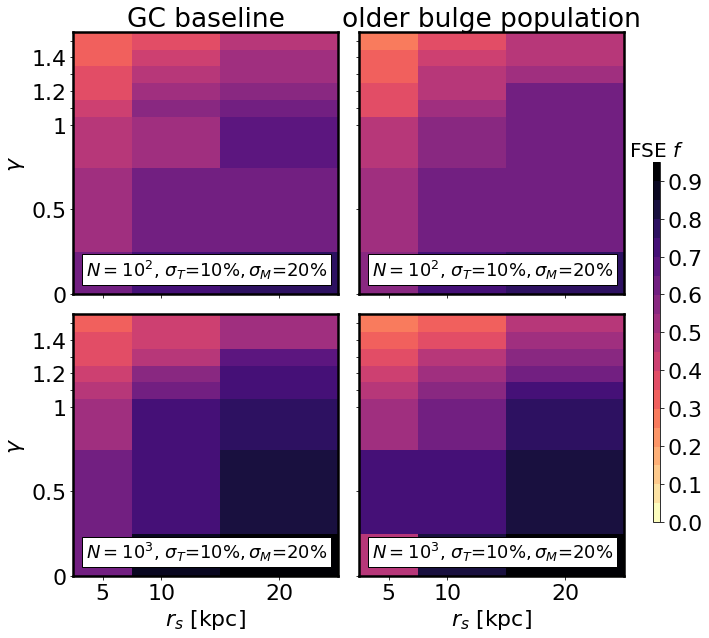

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

relT = 0.1; relM = 0.2

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("older bulge population")

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", True, False, True, True)


path = "/home/mariacst/exoplanets/results/tests/ex9/"
im   = grid_FSE(path, 100, relT, relM, "ex9", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE(path, 1000, relT, relM, "ex9", ax[1, 1], "median", True, False, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $f$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

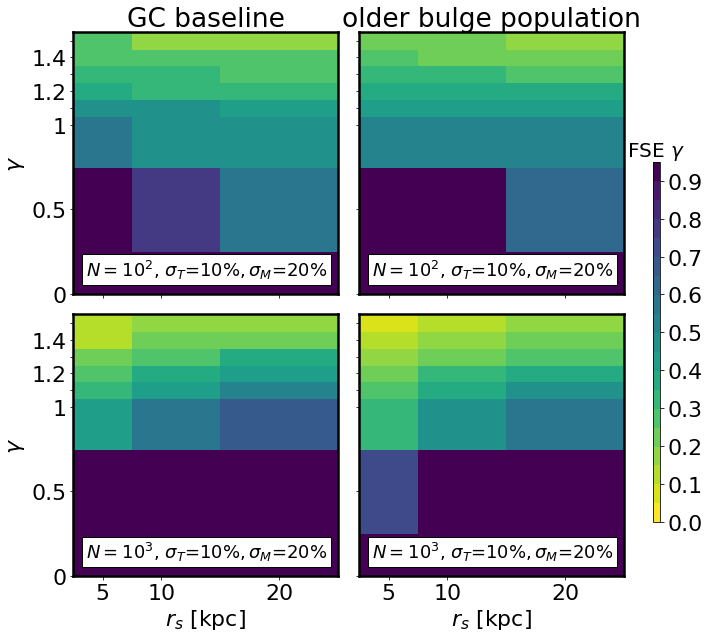

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("older bulge population")

relT =0.1; relM = 0.2

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", False, True, True, True)

path = "/home/mariacst/exoplanets/results/tests/ex9/"
im   = grid_FSE(path, 100, relT, relM, "ex9", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 1000, relT, relM, "ex9", ax[1, 1], "median", False, True, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

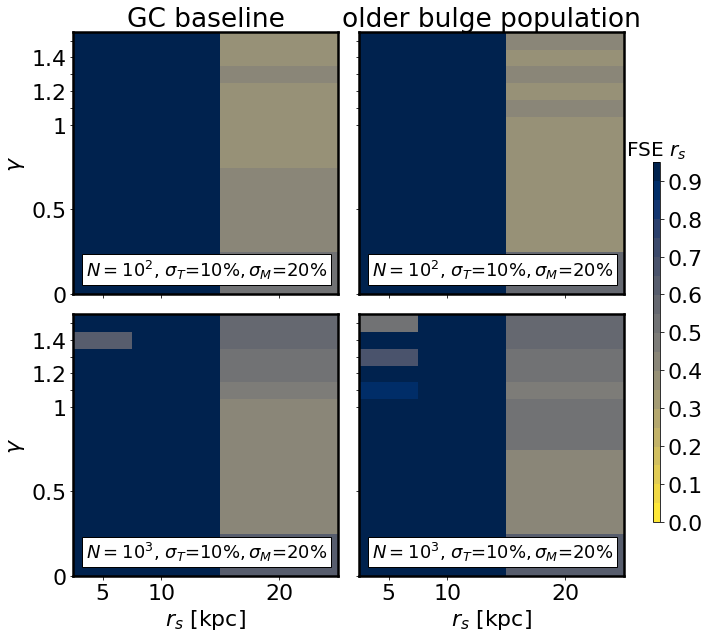

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("older bulge population")

relT = 0.1; relM = 0.2

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", False, False, True, True)


path = "/home/mariacst/exoplanets/results/tests/ex9/"
im   = grid_FSE(path, 100, relT, relM, "ex9", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE(path, 1000, relT, relM, "ex9", ax[1, 1], "median", False, False, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

## Adopt different IMF

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


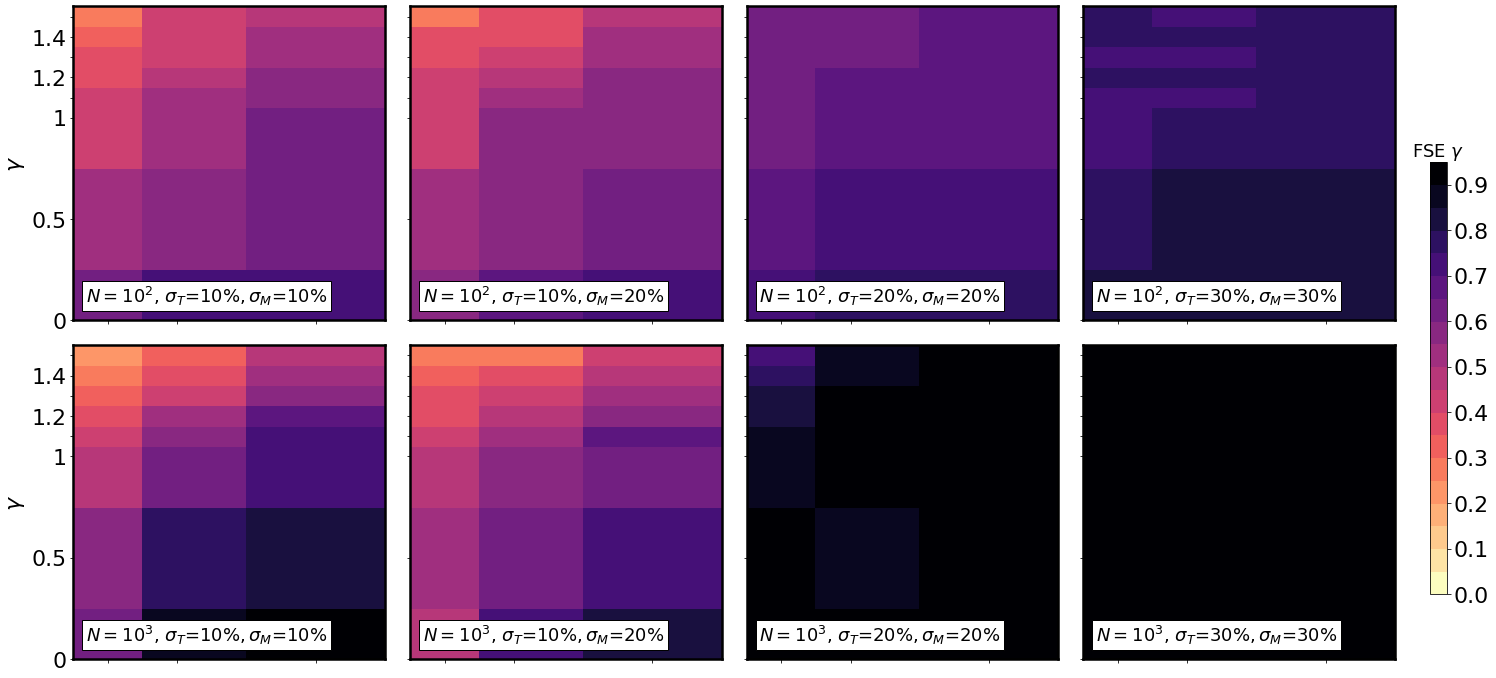

In [15]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12))

path = "/home/mariacst/exoplanets/results/tests/ex10/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex10", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex10", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex10", ax[0, 2], "median", True, False, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex10", ax[0, 3], "median", True, False, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex10", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex10", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex10", ax[1, 2], "median", True, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex10", ax[1, 3], "median", True, False, False, False)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

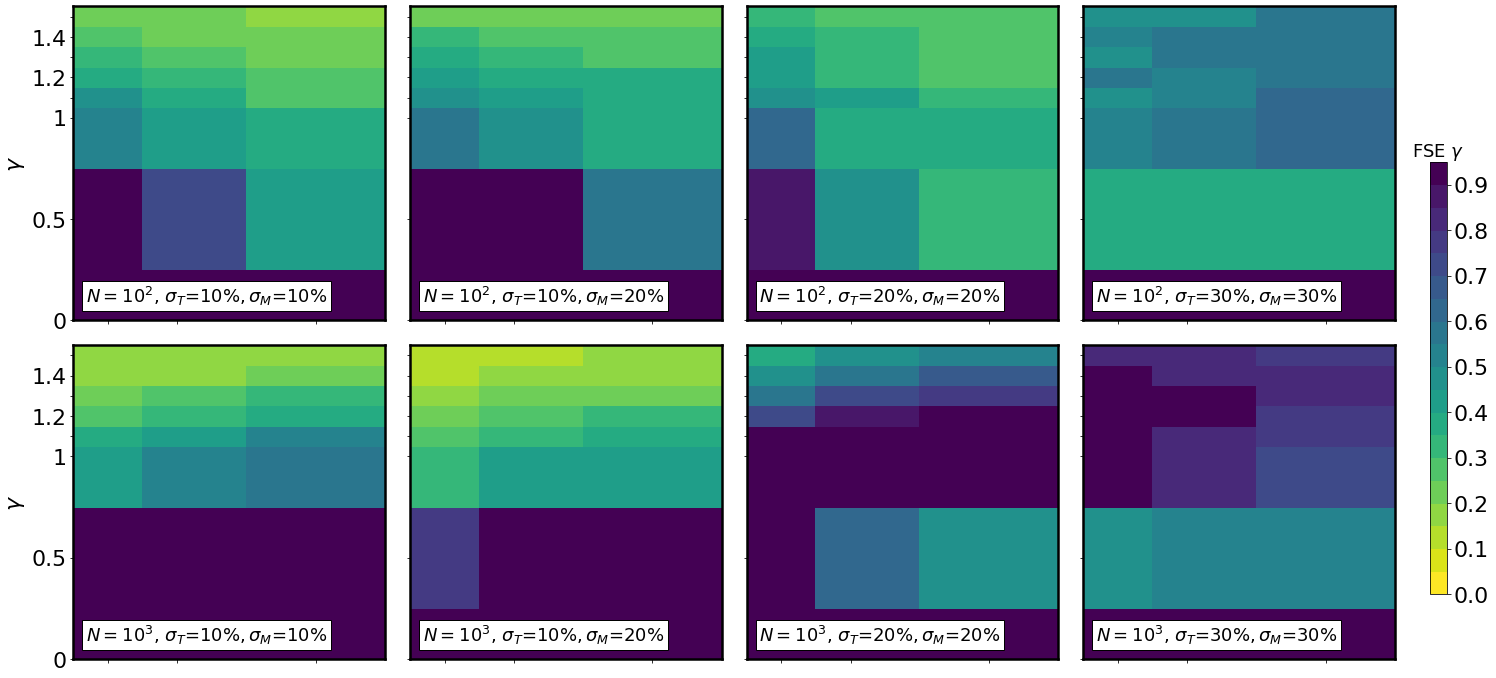

In [16]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12))

path = "/home/mariacst/exoplanets/results/tests/ex10/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex10", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex10", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex10", ax[0, 2], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex10", ax[0, 3], "median", False, True, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex10", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex10", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex10", ax[1, 2], "median", False, True, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex10", ax[1, 3], "median", False, True, False, False)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

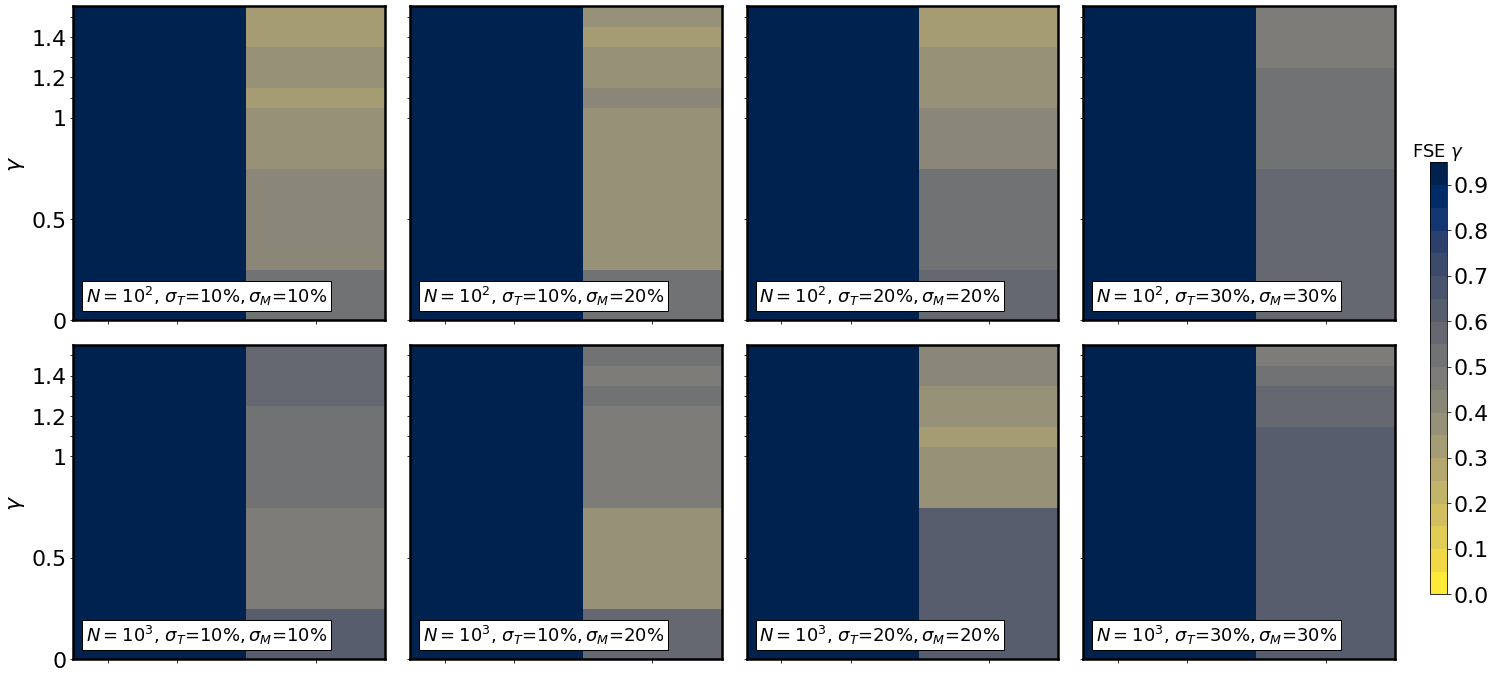

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12))

path = "/home/mariacst/exoplanets/results/tests/ex10/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex10", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 100, 0.1, 0.2, "ex10", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex10", ax[0, 2], "median", False, False, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex10", ax[0, 3], "median", False, False, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex10", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE(path, 1000, 0.1, 0.2, "ex10", ax[1, 1], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex10", ax[1, 2], "median", False, False, False, False)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex10", ax[1, 3], "median", False, False, False, False)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


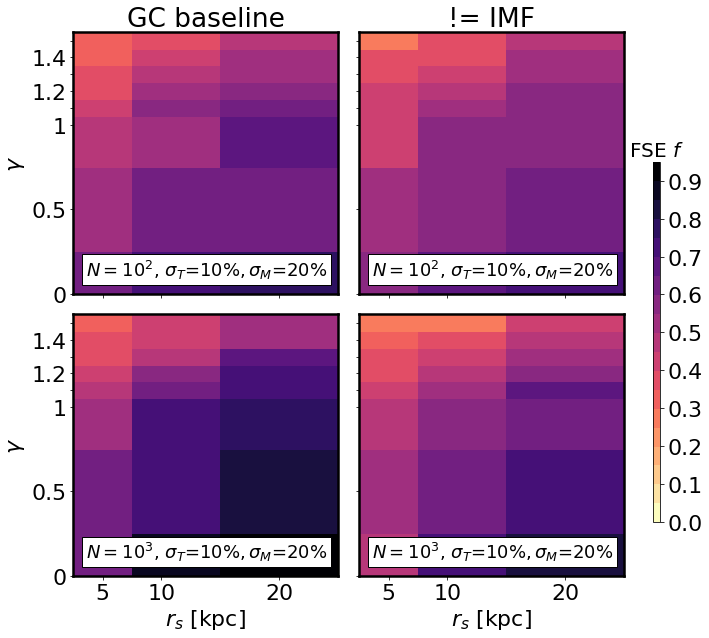

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

relT = 0.1; relM = 0.2

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("!= IMF")

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", True, False, True, True)


path = "/home/mariacst/exoplanets/results/tests/ex10/"
im   = grid_FSE(path, 100, relT, relM, "ex10", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE(path, 1000, relT, relM, "ex10", ax[1, 1], "median", True, False, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $f$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

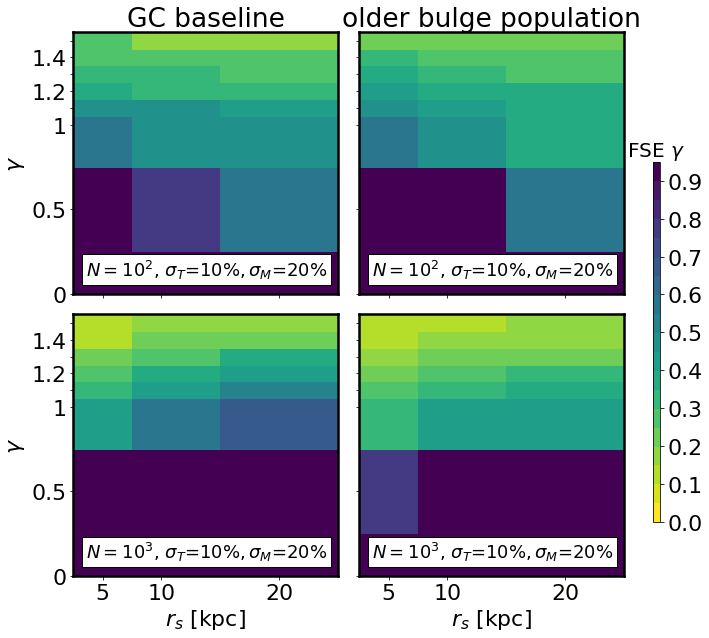

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("older bulge population")

relT =0.1; relM = 0.2

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", False, True, True, True)

path = "/home/mariacst/exoplanets/results/tests/ex10/"
im   = grid_FSE(path, 100, relT, relM, "ex10", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 1000, relT, relM, "ex10", ax[1, 1], "median", False, True, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

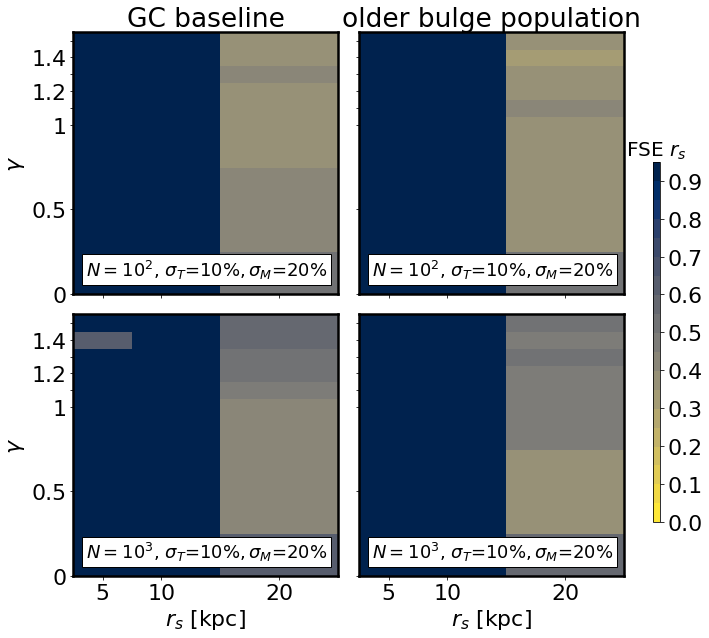

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("older bulge population")

relT = 0.1; relM = 0.2

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", False, False, True, True)


path = "/home/mariacst/exoplanets/results/tests/ex10/"
im   = grid_FSE(path, 100, relT, relM, "ex10", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE(path, 1000, relT, relM, "ex10", ax[1, 1], "median", False, False, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

# Uncertainties in all parameters - GC

In [3]:
imp.reload(utils_plots)
from utils_plots import grid_FSE_all

../python/utils_plots.py:347: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:352: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


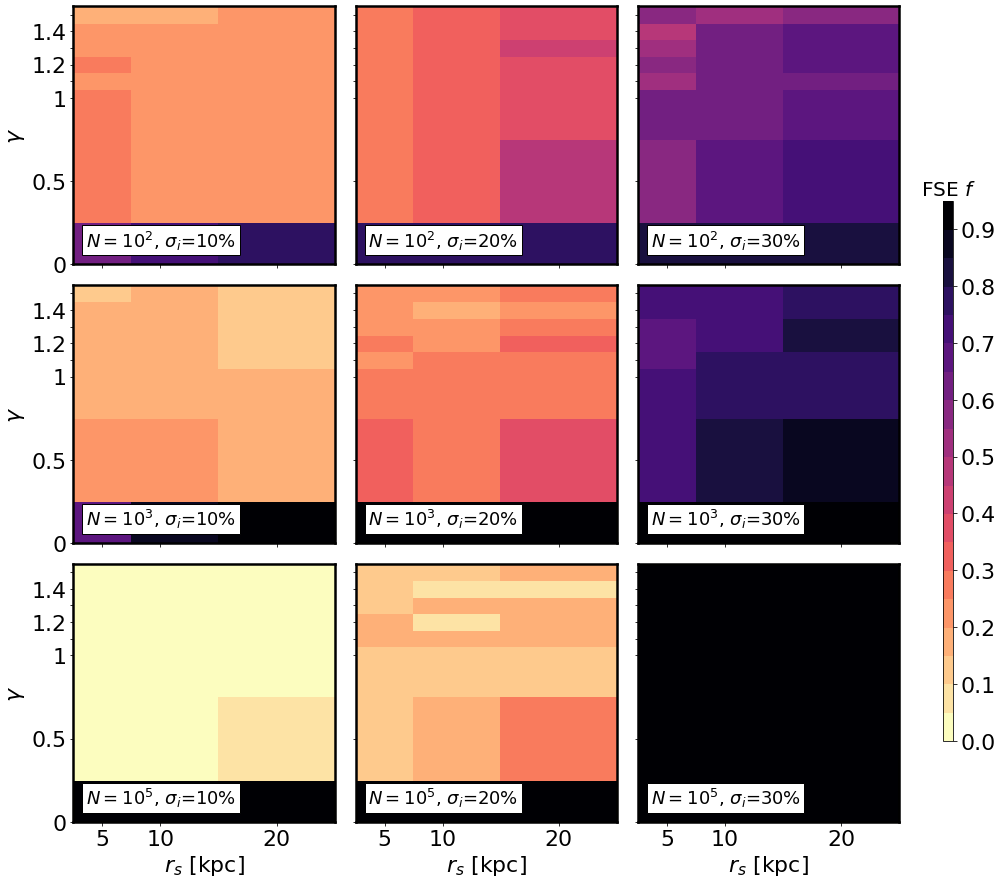

In [28]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))


path = "/home/mariacst/exoplanets/results/all_unc/GC/"
im   = grid_FSE_all(path, 100, 0.1, 0.1, "ex11", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE_all(path, 1000, 0.1, 0.1, "ex11", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE_all(path, 100000, 0.1, 0.1, "ex11", ax[2, 0], "median", True, False, True, True)

im   = grid_FSE_all(path, 100, 0.2, 0.2, "ex11", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE_all(path, 1000, 0.2, 0.2, "ex11", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE_all(path, 100000, 0.2, 0.2, "ex11", ax[2, 1], "median", True, False, False, True)

im   = grid_FSE_all(path, 100, 0.3, 0.3, "ex11", ax[0, 2], "median", True, False, False, False)
im   = grid_FSE_all(path, 1000, 0.3, 0.3, "ex11", ax[1, 2], "median", True, False, False, False)
im   = grid_FSE_all(path, 100000, 0.3, 0.3, "ex11", ax[2, 2], "median", True, False, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $f$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

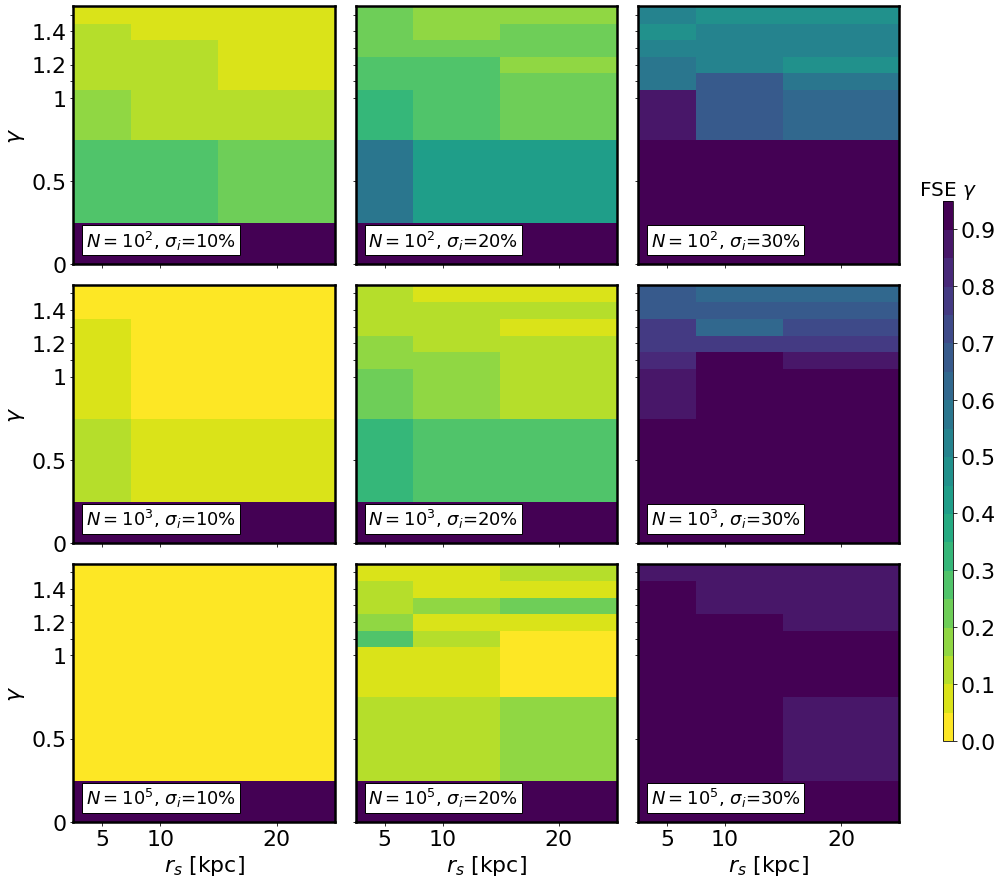

In [29]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))


path = "/home/mariacst/exoplanets/results/all_unc/GC/"
im   = grid_FSE_all(path, 100, 0.1, 0.1, "ex11", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE_all(path, 1000, 0.1, 0.1, "ex11", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE_all(path, 100000, 0.1, 0.1, "ex11", ax[2, 0], "median", False, True, True, True)


im   = grid_FSE_all(path, 100, 0.2, 0.2, "ex11", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE_all(path, 1000, 0.2, 0.2, "ex11", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE_all(path, 100000, 0.2, 0.2, "ex11", ax[2, 1], "median", False, True, False, True)

im   = grid_FSE_all(path, 100, 0.3, 0.3, "ex11", ax[0, 2], "median", False, True, False, False)
im   = grid_FSE_all(path, 1000, 0.3, 0.3, "ex11", ax[1, 2], "median", False, True, False, False)
im   = grid_FSE_all(path, 100000, 0.3, 0.3, "ex11", ax[2, 2], "median", False, True, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("/home/mariacst/exoplanets/Figs/FSE_all_gamma_GC.pdf", bbox_inches="tight")

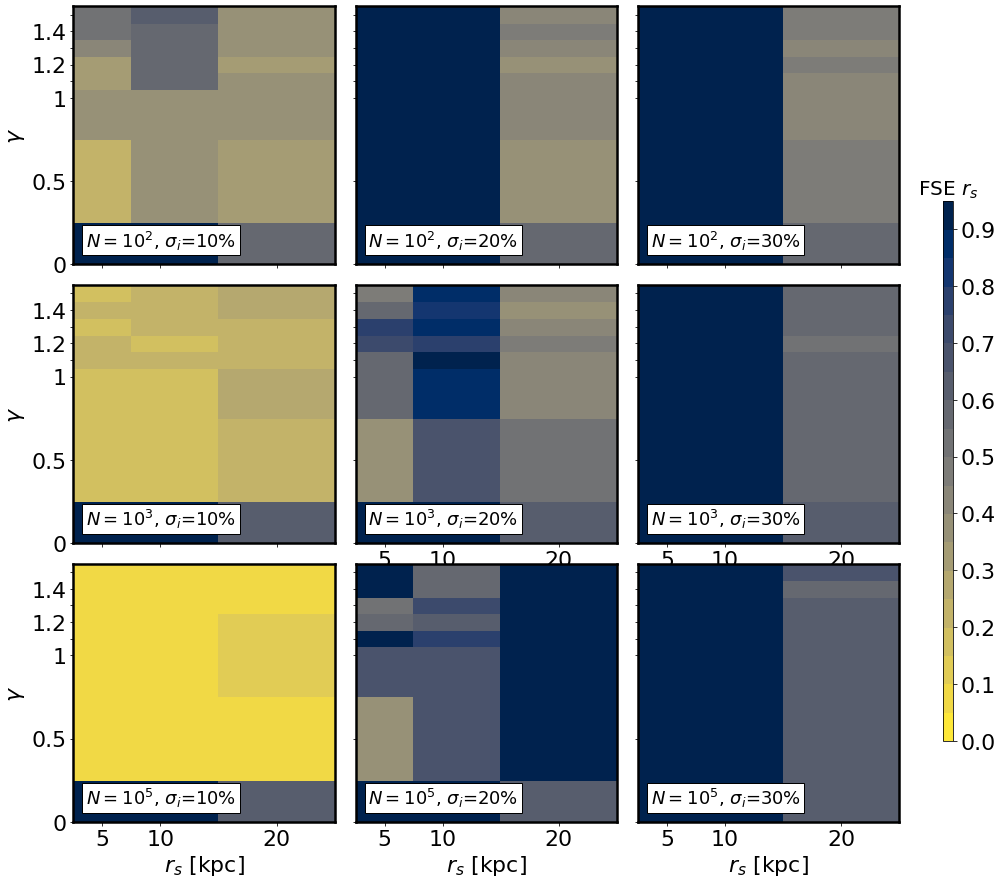

In [30]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))


path = "/home/mariacst/exoplanets/results/all_unc/GC/"
im   = grid_FSE_all(path, 100, 0.1, 0.1, "ex11", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE_all(path, 1000, 0.1, 0.1, "ex11", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE_all(path, 100000, 0.1, 0.1, "ex11", ax[2, 0], "median", False, False, True, True)

im   = grid_FSE_all(path, 100, 0.2, 0.2, "ex11", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE_all(path, 1000, 0.2, 0.2, "ex11", ax[1, 1], "median", False, False, False, True)
im   = grid_FSE_all(path, 100000, 0.2, 0.2, "ex11", ax[2, 1], "median", False, False, False, True)

im   = grid_FSE_all(path, 100, 0.3, 0.3, "ex11", ax[0, 2], "median", False, False, False, False)
im   = grid_FSE_all(path, 1000, 0.3, 0.3, "ex11", ax[1, 2], "median", False, False, False, True)
im   = grid_FSE_all(path, 100000, 0.3, 0.3, "ex11", ax[2, 2], "median", False, False, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("/home/mariacst/exoplanets/Figs/FSE_all_rs_GC.pdf", bbox_inches="tight")

../python/utils_plots.py:347: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:352: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


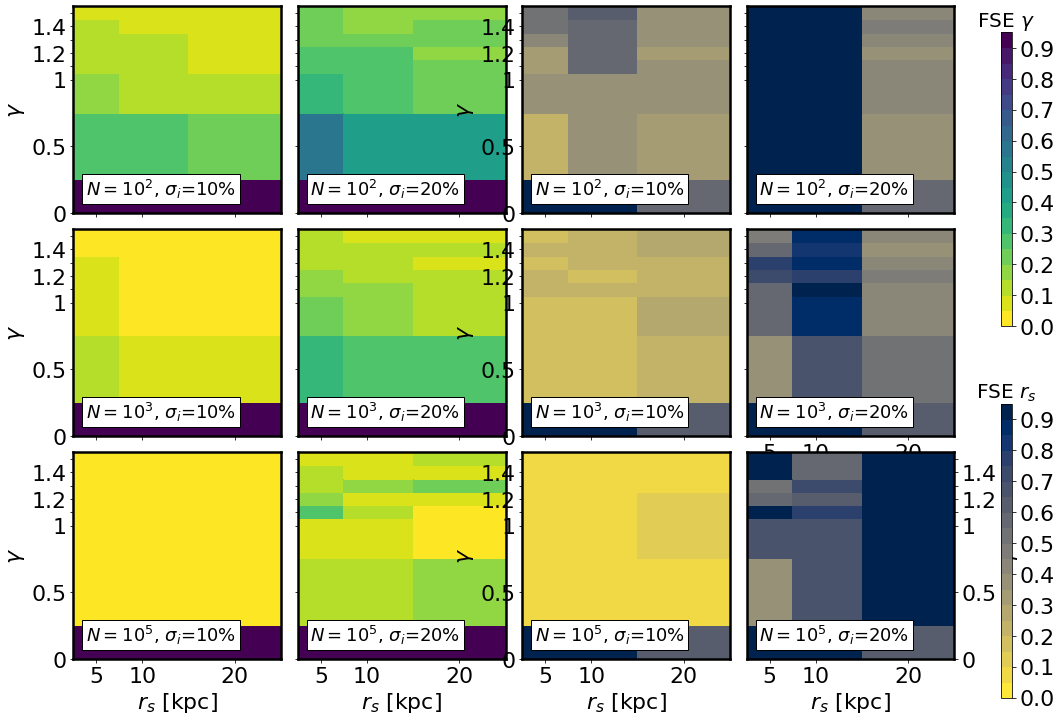

In [21]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))


path = "/home/mariacst/exoplanets/results/all_unc/GC/"
im0   = grid_FSE_all(path, 100, 0.1, 0.1, "ex11", ax[0, 0], "median", False, True, True, False)
im0   = grid_FSE_all(path, 1000, 0.1, 0.1, "ex11", ax[1, 0], "median", False, True, True, False)
im0   = grid_FSE_all(path, 100000, 0.1, 0.1, "ex11", ax[2, 0], "median", False, True, True, True)


im0   = grid_FSE_all(path, 100, 0.2, 0.2, "ex11", ax[0, 1], "median", False, True, False, False)
im0   = grid_FSE_all(path, 1000, 0.2, 0.2, "ex11", ax[1, 1], "median", False, True, False, False)
im0   = grid_FSE_all(path, 100000, 0.2, 0.2, "ex11", ax[2, 1], "median", False, True, False, True)


path = "/home/mariacst/exoplanets/results/all_unc/GC/"
im   = grid_FSE_all(path, 100, 0.1, 0.1, "ex11", ax[0, 2], "median", False, False, True, False)
im   = grid_FSE_all(path, 1000, 0.1, 0.1, "ex11", ax[1, 2], "median", False, False, True, False)
im   = grid_FSE_all(path, 100000, 0.1, 0.1, "ex11", ax[2, 2], "median", False, False, True, True)

im   = grid_FSE_all(path, 100, 0.2, 0.2, "ex11", ax[0, 3], "median", False, False, False, False)
im   = grid_FSE_all(path, 1000, 0.2, 0.2, "ex11", ax[1, 3], "median", False, False, False, True)
im   = grid_FSE_all(path, 100000, 0.2, 0.2, "ex11", ax[2, 3], "median", False, False, True, True)

ax[2, 3].yaxis.tick_right(); ax[2, 3].yaxis.set_label_position("right")

fig.subplots_adjust(right=0.89)

cbar_ax0 = fig.add_axes([0.93, 0.51, 0.01, 0.34])
cbar0 = fig.colorbar(im0, cax=cbar_ax0)
cbar0.ax.set_title(r"FSE $\gamma$", size=20.)

cbar_ax = fig.add_axes([0.93, 0.08, 0.01, 0.34])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)


fig.savefig("/home/mariacst/exoplanets/Figs/FSE_all_gamma_rs_GC.pdf", bbox_inches="tight")

# Uncertainties in all parameters - GC + Tmin

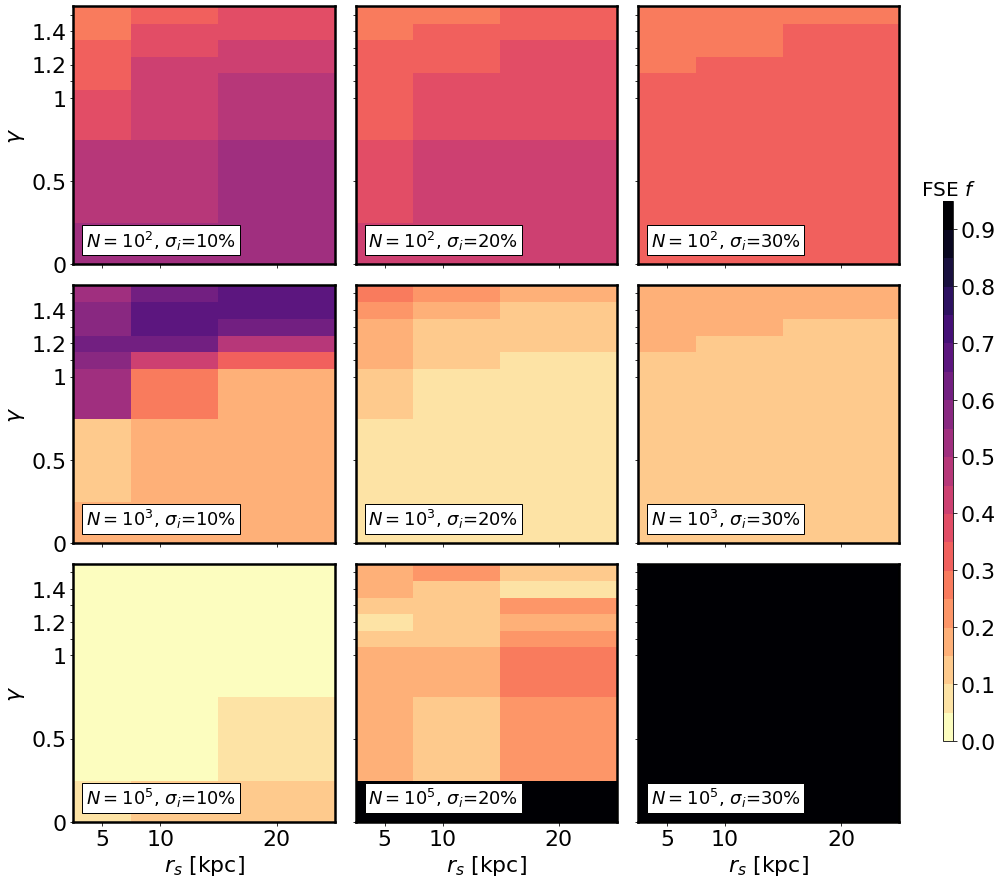

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))


path = "/home/mariacst/exoplanets/results/all_unc/Tmin/"
im   = grid_FSE_all(path, 100, 0.1, 0.1, "ex13", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE_all(path, 1000, 0.1, 0.1, "ex13", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE_all(path, 100000, 0.1, 0.1, "ex13", ax[2, 0], "median", True, False, True, True)

im   = grid_FSE_all(path, 100, 0.2, 0.2, "ex13", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE_all(path, 1000, 0.2, 0.2, "ex13", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE_all(path, 100000, 0.2, 0.2, "ex13", ax[2, 1], "median", True, False, False, True)

im   = grid_FSE_all(path, 100, 0.3, 0.3, "ex13", ax[0, 2], "median", True, False, False, False)
im   = grid_FSE_all(path, 1000, 0.3, 0.3, "ex13", ax[1, 2], "median", True, False, False, False)
im   = grid_FSE_all(path, 100000, 0.3, 0.3, "ex13", ax[2, 2], "median", True, False, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $f$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

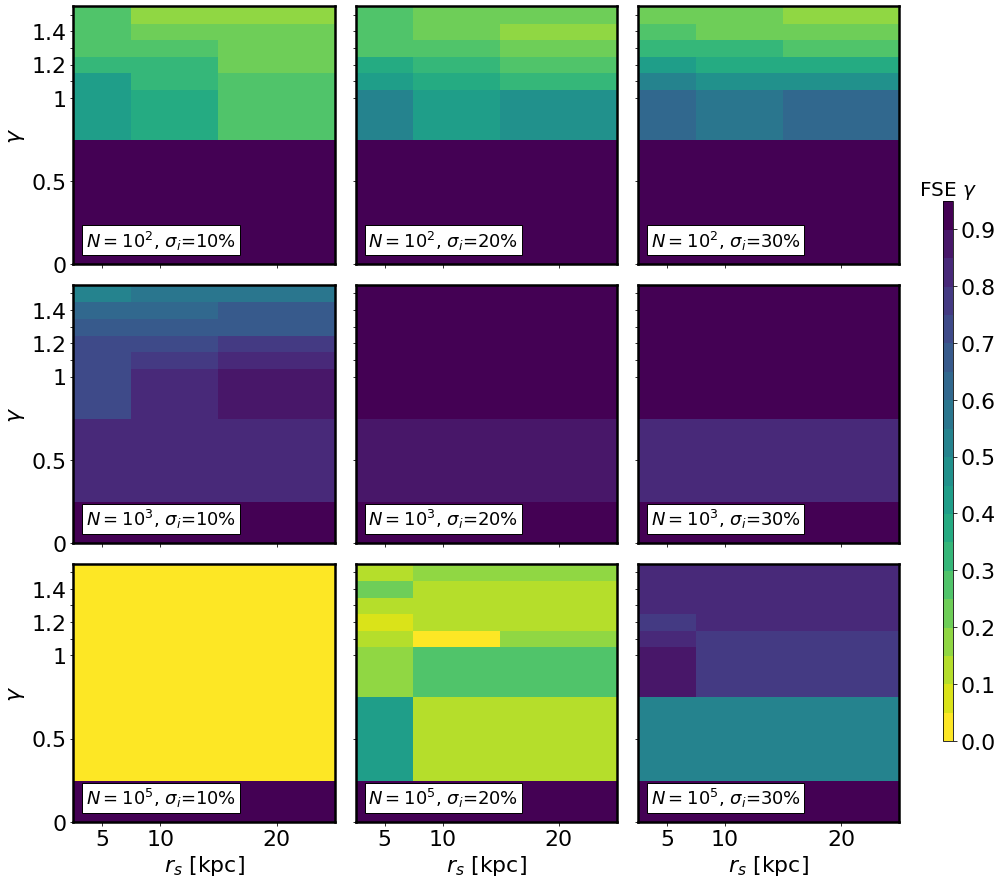

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))


path = "/home/mariacst/exoplanets/results/all_unc/Tmin/"
im   = grid_FSE_all(path, 100, 0.1, 0.1, "ex13", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE_all(path, 1000, 0.1, 0.1, "ex13", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE_all(path, 100000, 0.1, 0.1, "ex13", ax[2, 0], "median", False, True, True, True)


im   = grid_FSE_all(path, 100, 0.2, 0.2, "ex13", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE_all(path, 1000, 0.2, 0.2, "ex13", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE_all(path, 100000, 0.2, 0.2, "ex13", ax[2, 1], "median", False, True, False, True)

im   = grid_FSE_all(path, 100, 0.3, 0.3, "ex13", ax[0, 2], "median", False, True, False, False)
im   = grid_FSE_all(path, 1000, 0.3, 0.3, "ex13", ax[1, 2], "median", False, True, False, False)
im   = grid_FSE_all(path, 100000, 0.3, 0.3, "ex13", ax[2, 2], "median", False, True, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

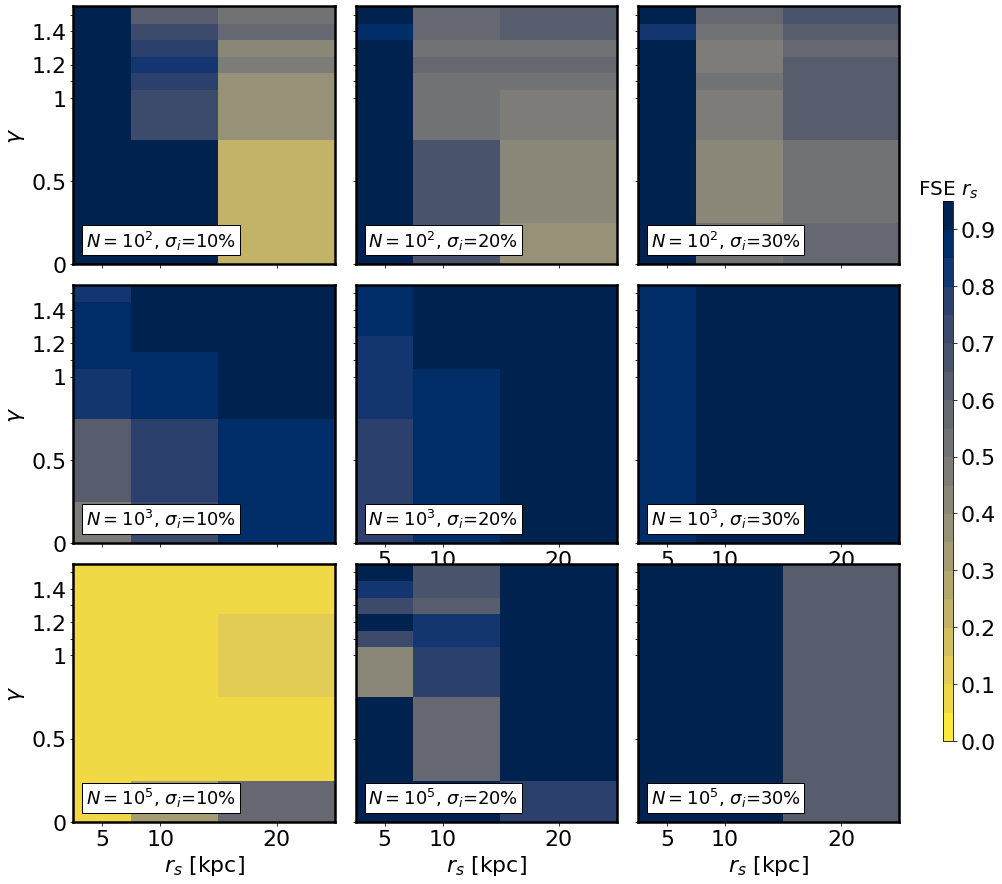

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))


path = "/home/mariacst/exoplanets/results/all_unc/Tmin/"
im   = grid_FSE_all(path, 100, 0.1, 0.1, "ex13", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE_all(path, 1000, 0.1, 0.1, "ex13", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE_all(path, 100000, 0.1, 0.1, "ex13", ax[2, 0], "median", False, False, True, True)

im   = grid_FSE_all(path, 100, 0.2, 0.2, "ex13", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE_all(path, 1000, 0.2, 0.2, "ex13", ax[1, 1], "median", False, False, False, True)
im   = grid_FSE_all(path, 100000, 0.2, 0.2, "ex13", ax[2, 1], "median", False, False, False, True)

im   = grid_FSE_all(path, 100, 0.3, 0.3, "ex13", ax[0, 2], "median", False, False, False, False)
im   = grid_FSE_all(path, 1000, 0.3, 0.3, "ex13", ax[1, 2], "median", False, False, False, True)
im   = grid_FSE_all(path, 100000, 0.3, 0.3, "ex13", ax[2, 2], "median", False, False, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

## Comparisons

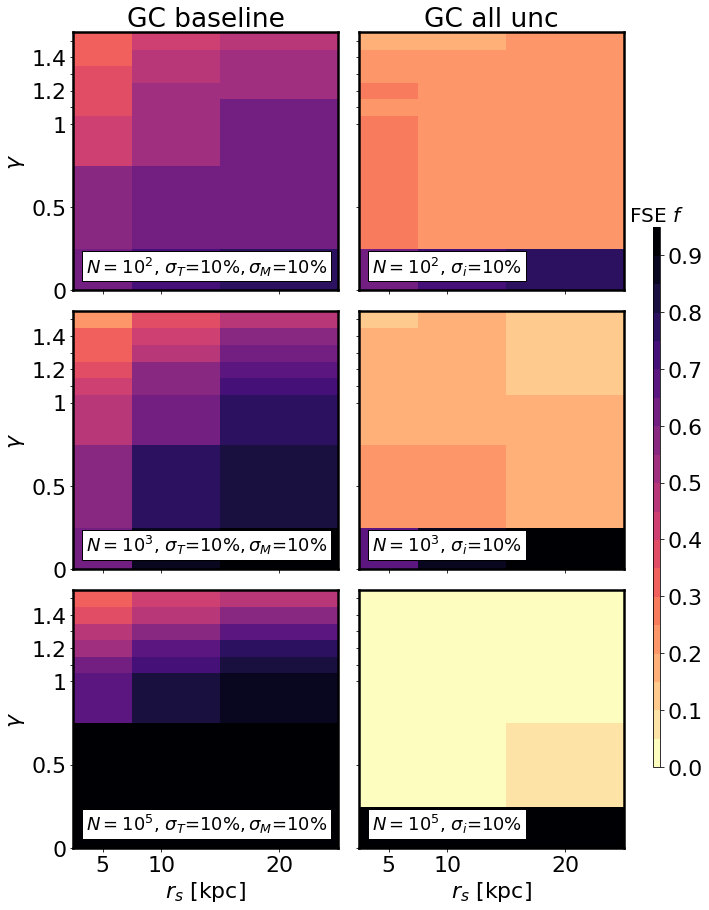

In [25]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("GC all unc")

relT =0.1; relM = 0.1

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE(path, 100000, relT, relM, "ex4", ax[2, 0], "median", True, False, True, True)

path = "/home/mariacst/exoplanets/results/all_unc/GC/"
im   = grid_FSE_all(path, 100, relT, relM, "ex11", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE_all(path, 1000, relT, relM, "ex11", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE_all(path, 100000, relT, relM, "ex11", ax[2, 1], "median", True, False, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $f$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

../python/utils_plots.py:352: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


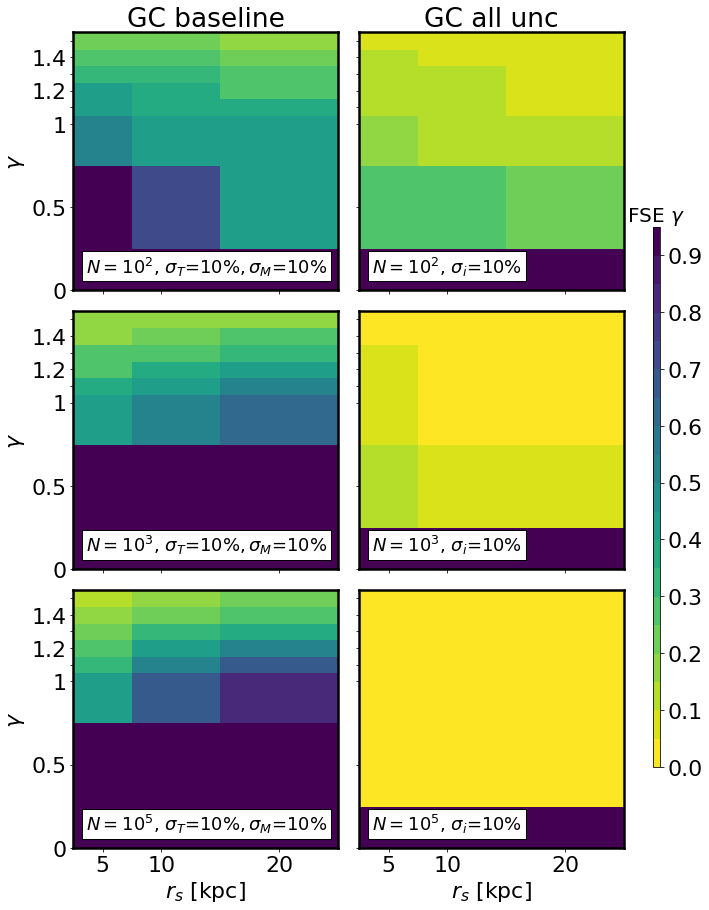

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("GC all unc")

relT =0.1; relM = 0.1

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100000, relT, relM, "ex4", ax[2, 0], "median", False, True, True, True)

path = "/home/mariacst/exoplanets/results/all_unc/GC/"
im   = grid_FSE_all(path, 100, relT, relM, "ex11", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE_all(path, 1000, relT, relM, "ex11", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE_all(path, 100000, relT, relM, "ex11", ax[2, 1], "median", False, True, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

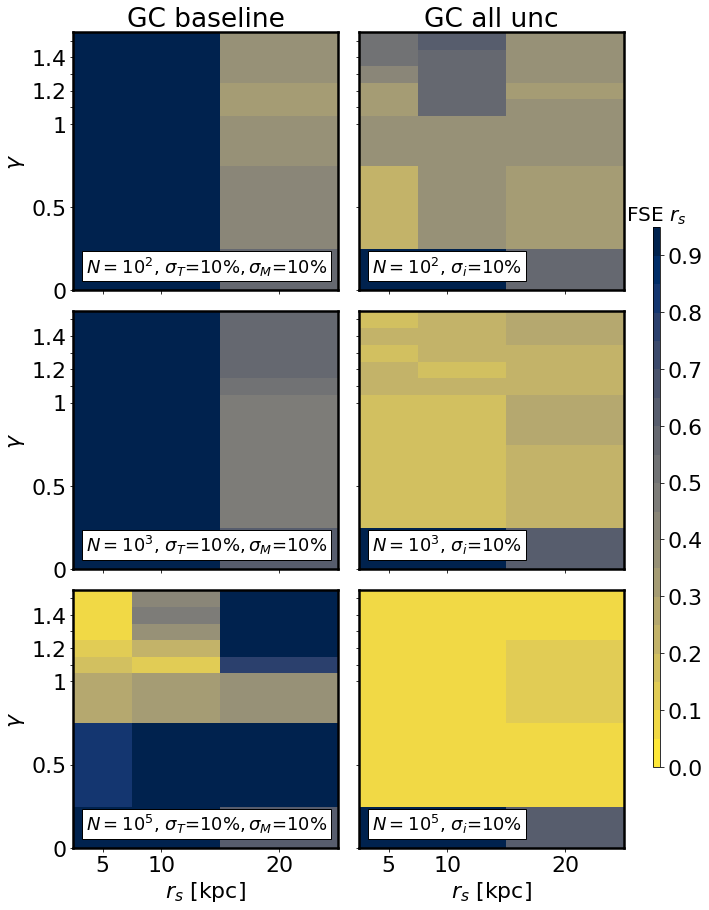

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

ax[0, 0].set_title("GC baseline")
ax[0, 1].set_title("GC all unc")

relT =0.1; relM = 0.1

path = "/home/mariacst/exoplanets/results/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex4", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex4", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE(path, 100000, relT, relM, "ex4", ax[2, 0], "median", False, False, True, True)

path = "/home/mariacst/exoplanets/results/all_unc/GC/"
im   = grid_FSE_all(path, 100, relT, relM, "ex11", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE_all(path, 1000, relT, relM, "ex11", ax[1, 1], "median", False, False, False, False)
im   = grid_FSE_all(path, 100000, relT, relM, "ex11", ax[2, 1], "median", False, False, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

../python/utils_plots.py:299: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:304: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])
findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


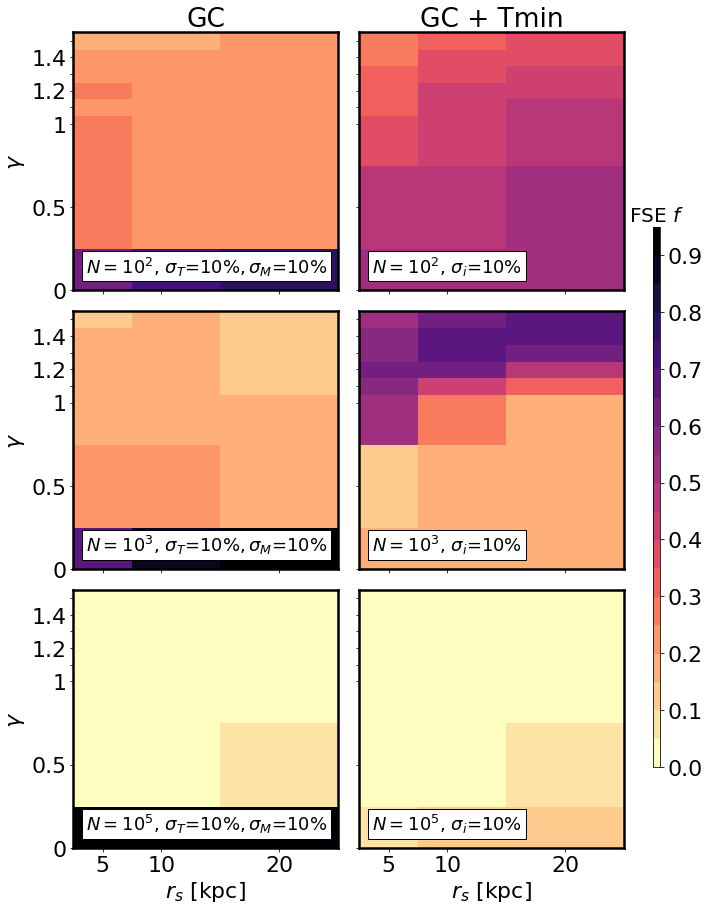

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

ax[0, 0].set_title("GC")
ax[0, 1].set_title("GC + Tmin")

relT =0.1; relM = 0.1

path = "/home/mariacst/exoplanets/results/all_unc/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex11", ax[0, 0], "median", True, False, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex11", ax[1, 0], "median", True, False, True, False)
im   = grid_FSE(path, 100000, relT, relM, "ex11", ax[2, 0], "median", True, False, True, True)

path = "/home/mariacst/exoplanets/results/all_unc/Tmin/"
im   = grid_FSE_all(path, 100, relT, relM, "ex13", ax[0, 1], "median", True, False, False, False)
im   = grid_FSE_all(path, 1000, relT, relM, "ex13", ax[1, 1], "median", True, False, False, False)
im   = grid_FSE_all(path, 100000, relT, relM, "ex13", ax[2, 1], "median", True, False, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $f$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

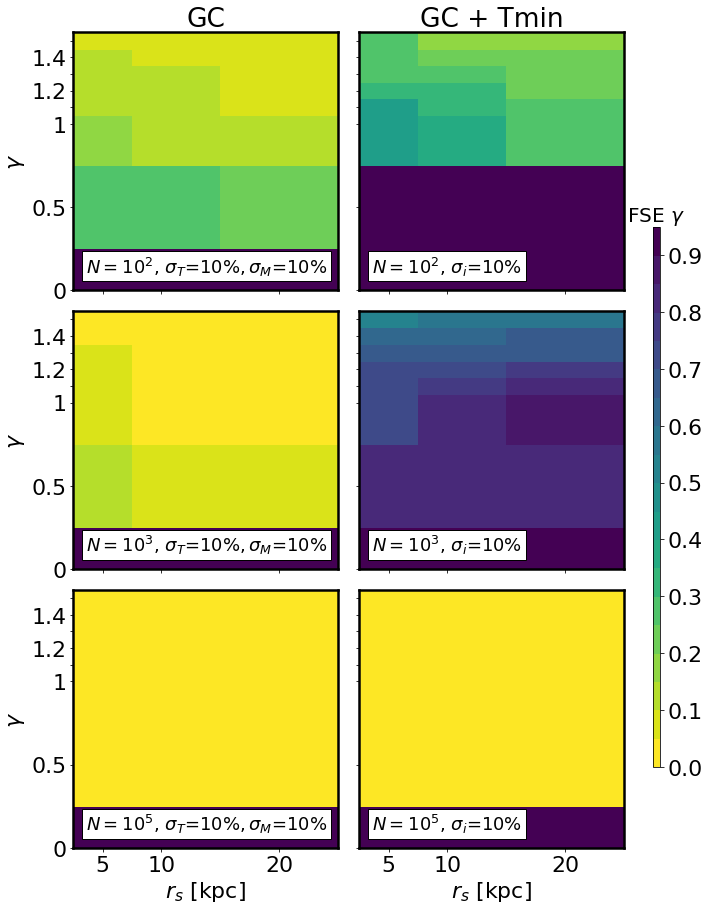

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

ax[0, 0].set_title("GC")
ax[0, 1].set_title("GC + Tmin")

relT =0.1; relM = 0.1

path = "/home/mariacst/exoplanets/results/all_unc/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex11", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex11", ax[1, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100000, relT, relM, "ex11", ax[2, 0], "median", False, True, True, True)

path = "/home/mariacst/exoplanets/results/all_unc/Tmin/"
im   = grid_FSE_all(path, 100, relT, relM, "ex13", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE_all(path, 1000, relT, relM, "ex13", ax[1, 1], "median", False, True, False, False)
im   = grid_FSE_all(path, 100000, relT, relM, "ex13", ax[2, 1], "median", False, True, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

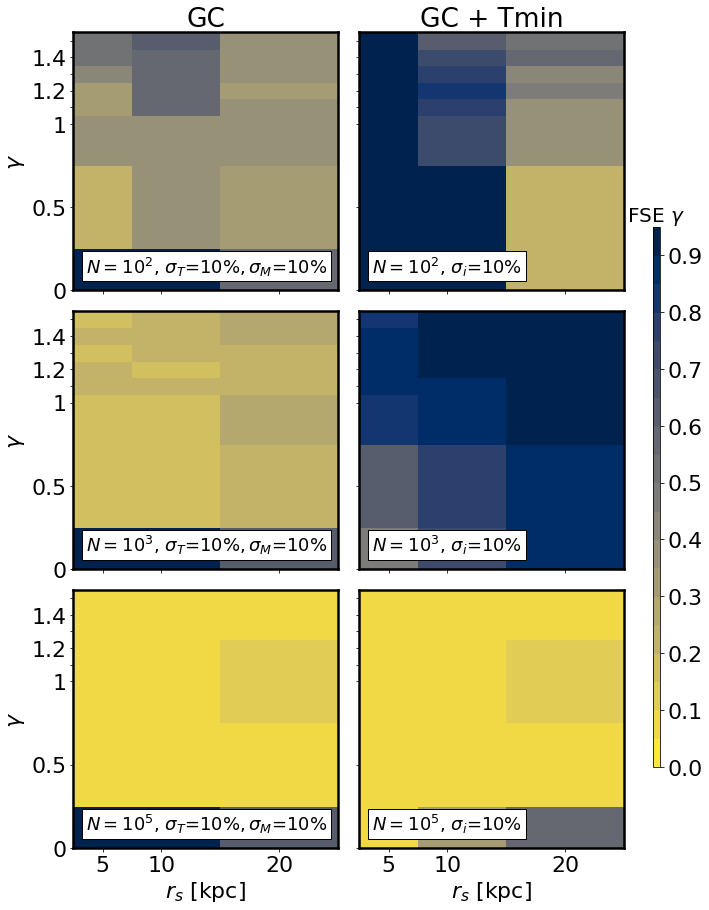

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

ax[0, 0].set_title("GC")
ax[0, 1].set_title("GC + Tmin")

relT =0.1; relM = 0.1

path = "/home/mariacst/exoplanets/results/all_unc/GC/"
im   = grid_FSE(path, 100, relT, relM, "ex11", ax[0, 0], "median", False, False, True, False)
im   = grid_FSE(path, 1000, relT, relM, "ex11", ax[1, 0], "median", False, False, True, False)
im   = grid_FSE(path, 100000, relT, relM, "ex11", ax[2, 0], "median", False, False, True, True)

path = "/home/mariacst/exoplanets/results/all_unc/Tmin/"
im   = grid_FSE_all(path, 100, relT, relM, "ex13", ax[0, 1], "median", False, False, False, False)
im   = grid_FSE_all(path, 1000, relT, relM, "ex13", ax[1, 1], "median", False, False, False, False)
im   = grid_FSE_all(path, 100000, relT, relM, "ex13", ax[2, 1], "median", False, False, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)